# Exploratory Data Analysis

## Introduction

The CheXpert (Chest eXpert) is a large publicly available dataset, consisting of 224,316 chest radiographs from 65,240 patients. Each radiograph is labeled for the presence of 14 distinct observations, categorized as positive, negative, or uncertain. 

These observations include:
1. **No Finding:** Captures the absence of all pathologies.
2. **Enlarged Cardiom.**
3. **Cardiomegaly**
4. **Lung Lesion**
5. **Lung Opacity**
6. **Edema**
7. **Consolidation**
8. **Pneumonia:** Denotes the images that suggest primary infection.
9. **Atelectasis**
10. **Pneumothorax**
11. **Pleural Effusion**
12. **Pleural Other**
13. **Fracture**
14. **Support Devices:** Indicates the presence of medical devices.


First, mentions of specific observations are extracted from the radiology reports. This step identifies the presence or suggestion of various conditions and findings within the images.

Following the extraction, these mentions are classified into three distinct categories: negative, uncertain, and positive. 
A mention is classified as **negative** when the report explicitly indicates the absence of conditions (e.g., "no evidence of pulmonary edema, pleural effusions, or pneumothorax"). **Uncertain** if the report suggests a possible condition with ambiguity or doubt (e.g., "diffuse reticular pattern may represent mild interstitial pulmonary edema"), encapsulating both the radiologist's uncertainty and the inherent vagueness of the report (e.g., "heart size is stable"). A **positive** classification is applied to mentions that definitively indicate the presence of conditions (e.g., "moderate bilateral effusions and bibasilar opacities").

This classification framework is then applied to determine the final label for each of the 14 observations, which includes 12 specific pathologies along with "Support Devices" and "No Finding." An observation receives a **positive (1)** label if it is mentioned in a manner classified as positive at least once within the report. It is labeled **uncertain (u)** if there are one or more uncertain mentions without any positive mentions. A **negative** label is assigned in the presence of at least one negatively classified mention. If an observation is not mentioned at all, it is marked as **blank**.

## Intial setup

### Required libraries

In [9]:
import pandas as pd
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.io import imread

### CheXpert dataset

In [4]:
# Loading the csv files
train_data = pd.read_csv("../../../data_shares/purrlab/CheXpert/CheXpert-v1.0-small/train.csv", index_col=0)
val_data = pd.read_csv("../../../data_shares/purrlab/CheXpert/CheXpert-v1.0-small/valid.csv", index_col=0)
#test_data = pd.read_csv("../../data_shares/purrlab/CheXpert/chexlocalize/CheXpert/test_labels.csv", index_col=0)


# Appending the files to have the whole dataset
data = pd.concat([train_data, val_data])#, #test_data])

In [119]:
# Adjusting the headers column and printing the data
data.reset_index()
display(data)

Path     Sex   Age  \
0       CheXpert-v1.0-small/train/patient00001/study1/...  Female  68.0   
1       CheXpert-v1.0-small/train/patient00002/study2/...  Female  87.0   
2       CheXpert-v1.0-small/train/patient00002/study1/...  Female  83.0   
3       CheXpert-v1.0-small/train/patient00002/study1/...  Female  83.0   
4       CheXpert-v1.0-small/train/patient00003/study1/...    Male  41.0   
...                                                   ...     ...   ...   
224311         test/patient65236/study1/view1_frontal.jpg     NaN   NaN   
224312         test/patient65237/study1/view1_frontal.jpg     NaN   NaN   
224313         test/patient65238/study1/view1_frontal.jpg     NaN   NaN   
224314         test/patient65239/study1/view1_frontal.jpg     NaN   NaN   
224315         test/patient65240/study1/view1_frontal.jpg     NaN   NaN   

       Frontal/Lateral AP/PA  No Finding  Enlarged Cardiomediastinum  \
0              Frontal    AP         1.0                         NaN   
1              Frontal    AP         NaN                         NaN   
2              Frontal    AP         NaN                         NaN   
3              Lateral   NaN         NaN                         NaN   
4              Frontal    AP         NaN                         NaN   
...                ...   ...         ...                         ...   
224311             NaN   NaN         0.0                         1.0   
224312             NaN   NaN         0.0                         1.0   
224313             NaN   NaN         0.0                         0.0   
224314             NaN   NaN         0.0                         1.0   
224315             NaN   NaN         0.0                         0.0   

        Cardiomegaly  Lung Opacity  Lung Lesion  Edema  Consolidation  \
0                NaN           NaN          NaN    NaN            NaN   
1               -1.0           1.0          NaN   -1.0           -1.0   
2                NaN           1.0          NaN    NaN           -1.0   
3                NaN           1.0          NaN    NaN           -1.0   
4                NaN           NaN          NaN    1.0            NaN   
...              ...           ...          ...    ...            ...   
224311           1.0           1.0          0.0    1.0            0.0   
224312           0.0           0.0          0.0    0.0            0.0   
224313           0.0           0.0          0.0    0.0            0.0   
224314           1.0           1.0          0.0    1.0            0.0   
224315           0.0           1.0          0.0    0.0            0.0   

        Pneumonia  Atelectasis  Pneumothorax  Pleural Effusion  Pleural Other  \
0             NaN          NaN           0.0               NaN            NaN   
1             NaN         -1.0           NaN              -1.0            NaN   
2             NaN          NaN           NaN               NaN            NaN   
3             NaN          NaN           NaN               NaN            NaN   
4             NaN          NaN           0.0               NaN            NaN   
...           ...          ...           ...               ...            ...   
224311        0.0          0.0           0.0               0.0            0.0   
224312        0.0          0.0           0.0               0.0            0.0   
224313        0.0          0.0           0.0               0.0            0.0   
224314        0.0          1.0           0.0               0.0            0.0   
224315        0.0          1.0           0.0               1.0            0.0   

        Fracture  Support Devices  
0            NaN              1.0  
1            1.0              NaN  
2            1.0              NaN  
3            1.0              NaN  
4            NaN              NaN  
...          ...              ...  
224311       0.0              1.0  
224312       0.0              0.0  
224313       0.0              1.0  
224314       0.0              1.0  
224315       0.0              1.0  

[224

## The shape of the data

In [4]:
num_observations, num_features = data.shape

print("The size of the data:")
print(f"\t - The number of observations (rows) is {num_observations}.")
print(f"\t - The number of features (columns) is {num_features}.")

The size of the data:
	 - The number of observations (rows) is 224316.
	 - The number of features (columns) is 18.


In [5]:
print("The type of the data:\n")
print(data.dtypes)

The type of the data:

Sex                            object
Age                           float64
Frontal/Lateral                object
AP/PA                          object
No Finding                    float64
Enlarged Cardiomediastinum    float64
Cardiomegaly                  float64
Lung Opacity                  float64
Lung Lesion                   float64
Edema                         float64
Consolidation                 float64
Pneumonia                     float64
Atelectasis                   float64
Pneumothorax                  float64
Pleural Effusion              float64
Pleural Other                 float64
Fracture                      float64
Support Devices               float64
dtype: object


In [6]:
print("Checking for the number of missing values:\n")
print(data.isnull().sum())

Checking for the number of missing values:

Sex                              668
Age                              668
Frontal/Lateral                  668
AP/PA                          33087
No Finding                    201033
Enlarged Cardiomediastinum    178575
Cardiomegaly                  177211
Lung Opacity                  105636
Lung Lesion                   211470
Edema                         137458
Consolidation                 152792
Pneumonia                     195806
Atelectasis                   154971
Pneumothorax                  144480
Pleural Effusion               90203
Pleural Other                 216922
Fracture                      211220
Support Devices               100197
dtype: int64


#### NOTE: we need to handle the missing values by replacing them with 0?? or maybe droping the rows?


## Summary of the data

In [94]:
numerical_data = data.select_dtypes(include=['int64', 'float64'])

print("Analysis of the numerical variables:")
display(numerical_data.describe().round(2))

Analysis of the numerical variables:


Age  No Finding  Enlarged Cardiomediastinum  Cardiomegaly  \
count  223648.00    23283.00                    45741.00      47105.00   
mean       60.43        0.97                       -0.03          0.41   
std        17.82        0.18                        0.72          0.76   
min         0.00        0.00                       -1.00         -1.00   
25%        49.00        1.00                       -1.00          0.00   
50%        62.00        1.00                        0.00          1.00   
75%        74.00        1.00                        0.00          1.00   
max        90.00        1.00                        1.00          1.00   

       Lung Opacity  Lung Lesion     Edema  Consolidation  Pneumonia  \
count     118680.00     12846.00  86858.00       71524.00   28510.00   
mean           0.85         0.60      0.45          -0.18      -0.45   
std            0.47         0.69      0.74           0.75       0.82   
min           -1.00        -1.00     -1.00          -1.00      -1.00   
25%            1.00         0.00      0.00          -1.00      -1.00   
50%            1.00         1.00      1.00           0.00      -1.00   
75%            1.00         1.00      1.00           0.00       0.00   
max            1.00         1.00      1.00           1.00       1.00   

       Atelectasis  Pneumothorax  Pleural Effusion  Pleural Other  Fracture  \
count     69345.00      79836.00         134113.00        7394.00  13096.00   
mean         -0.00          0.20              0.56           0.12      0.64   
std           0.99          0.49              0.65           0.91      0.57   
min          -1.00         -1.00             -1.00          -1.00     -1.00   
25%          -1.00          0.00              0.00          -1.00      0.00   
50%           0.00          0.00              1.00           0.00      1.00   
75%           1.00          0.00              1.00           1.00      1.00   
max           1.00          1.00              1.00           1.00      1.00   

       Support Devices  
count        124119.00  
mean              0.93  
std               0.29  
min              -1.00  
25%               1.00  
50%               1.00  
75%               1.00  
max               1.00

NOTE: age 0

In [ ]:
print("Skewness of the numerical variables:\n")
print(numerical_data.skew())

In [ ]:
print("Kurtosis of the numerical variables:\n")
print(numerical_data.kurtosis())

In [10]:
pathologies = [
    "No Finding", "Enlarged Cardiomediastinum", "Cardiomegaly", "Lung Lesion",
    "Lung Opacity", "Edema", "Consolidation", "Pneumonia",
    "Atelectasis", "Pneumothorax", "Pleural Effusion", "Pleural Other",
    "Fracture", "Support Devices"
]

report_data = []

for pathology in pathologies:
    total = len(data[pathology])
    positive = (data[pathology] == 1).sum()
    uncertain = (data[pathology] == -1).sum()
    negative = (data[pathology] == 0).sum()
    nan_values = data[pathology].isna().sum()
    
    positive_pct = (positive / total) * 100
    uncertain_pct = (uncertain / total) * 100
    negative_pct = (negative / total) * 100
    nan_pct = (nan_values / total) * 100
    
    report_data.append([pathology, f"{positive} ({positive_pct:.2f}%)", f"{uncertain} ({uncertain_pct:.2f}%)", f"{negative} ({negative_pct:.2f}%)", f"{nan_values} ({nan_pct:.2f}%)"])

report_df = pd.DataFrame(report_data, columns=["Pathology", "Positive (%)", "Uncertain (%)", "Negative (%)", "NaN (%)"], index=range(1, len(pathologies) + 1))

print("Summary of the 14 labeled observations:")
display(report_df)

Summary of the 14 labeled observations:


Pathology     Positive (%)   Uncertain (%)  \
1                   No Finding   22528 (10.04%)       0 (0.00%)   
2   Enlarged Cardiomediastinum    11205 (5.00%)   12403 (5.53%)   
3                 Cardiomegaly   27243 (12.14%)    8087 (3.61%)   
4                  Lung Lesion     9201 (4.10%)    1488 (0.66%)   
5                 Lung Opacity  106017 (47.26%)    5598 (2.50%)   
6                        Edema   52376 (23.35%)   12984 (5.79%)   
7                Consolidation    14851 (6.62%)  27742 (12.37%)   
8                    Pneumonia     6061 (2.70%)   18770 (8.37%)   
9                  Atelectasis   33634 (14.99%)  33739 (15.04%)   
10                Pneumothorax    19466 (8.68%)    3145 (1.40%)   
11            Pleural Effusion   86374 (38.51%)   11628 (5.18%)   
12               Pleural Other     3532 (1.57%)    2653 (1.18%)   
13                    Fracture     9046 (4.03%)     642 (0.29%)   
14             Support Devices  116423 (51.90%)    1079 (0.48%)   

      Negative (%)          NaN (%)  
1      755 (0.34%)  201033 (89.62%)  
2    22133 (9.87%)  178575 (79.61%)  
3    11775 (5.25%)  177211 (79.00%)  
4     2157 (0.96%)  211470 (94.27%)  
5     7065 (3.15%)  105636 (47.09%)  
6    21498 (9.58%)  137458 (61.28%)  
7   28931 (12.90%)  152792 (68.11%)  
8     3679 (1.64%)  195806 (87.29%)  
9     1972 (0.88%)  154971 (69.09%)  
10  57225 (25.51%)  144480 (64.41%)  
11  36111 (16.10%)   90203 (40.21%)  
12    1209 (0.54%)  216922 (96.70%)  
13    3408 (1.52%)  211220 (94.16%)  
14    6617 (2.95%)  100197 (44.67%)

## Individual variables

### Overview

Histogram and boxplot for numerical variables:


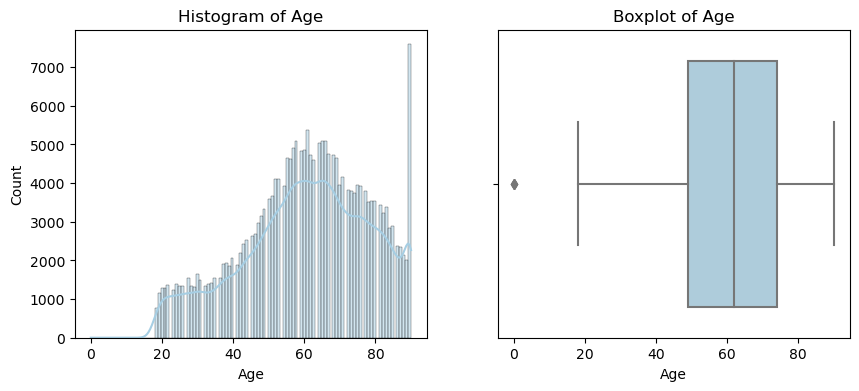

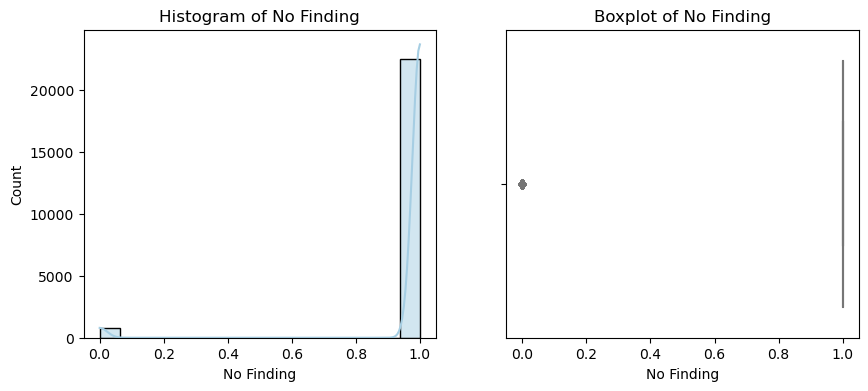

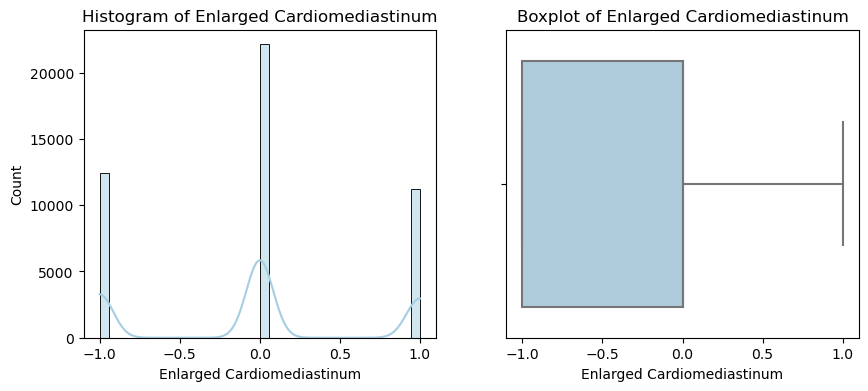

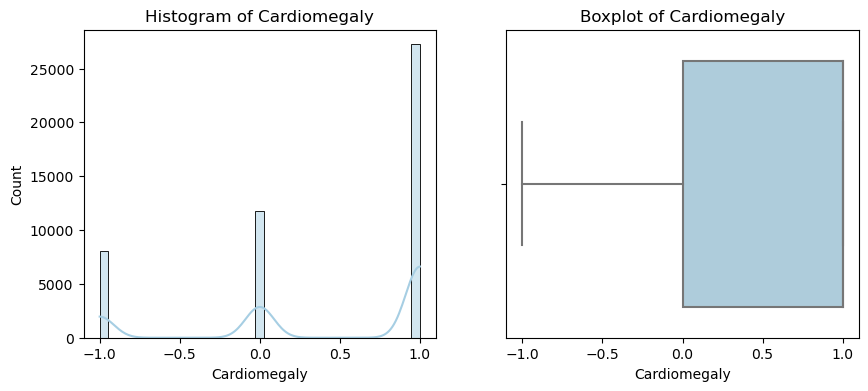

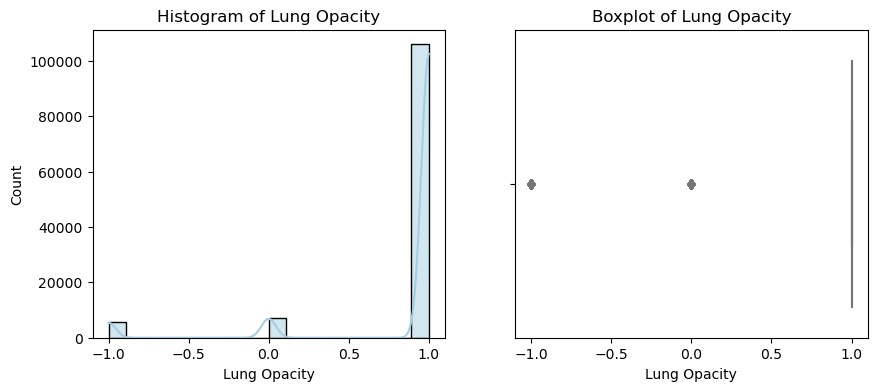

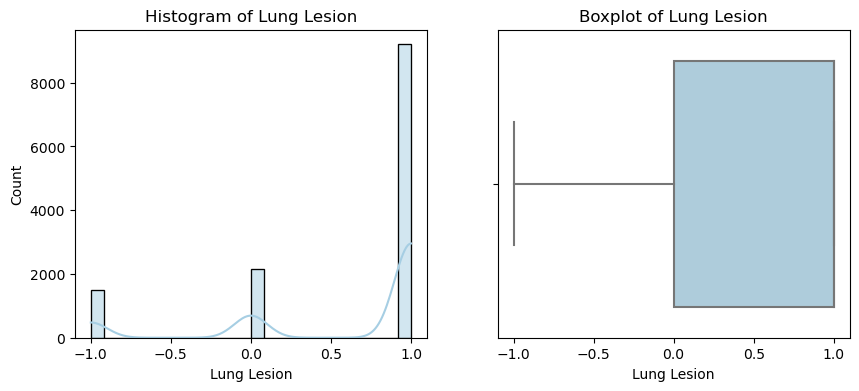

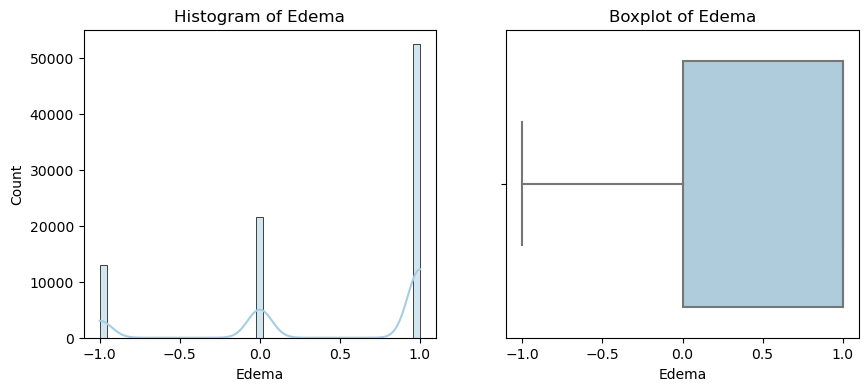

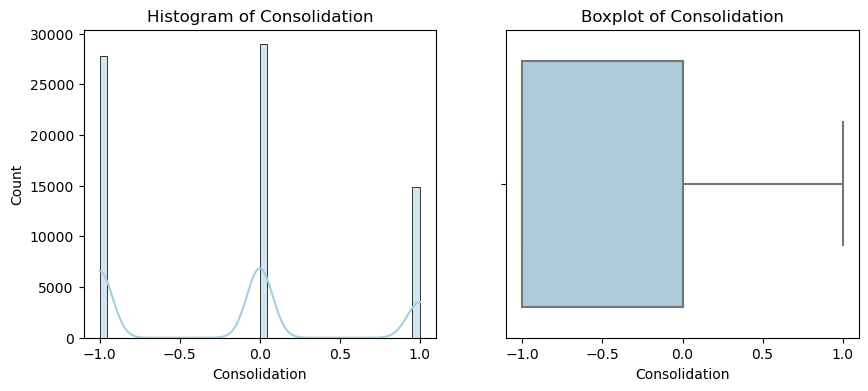

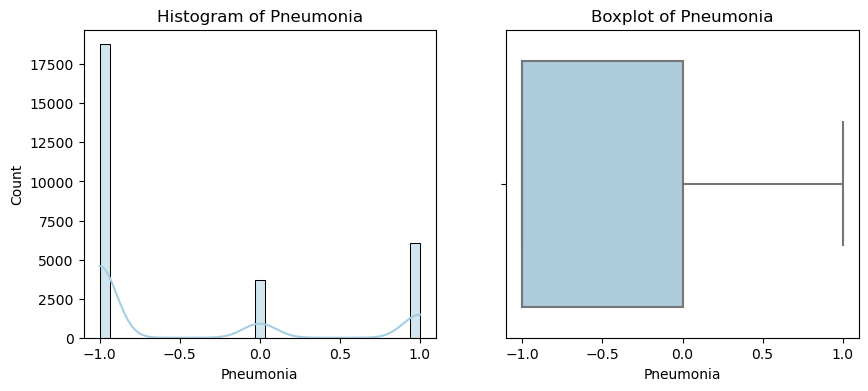

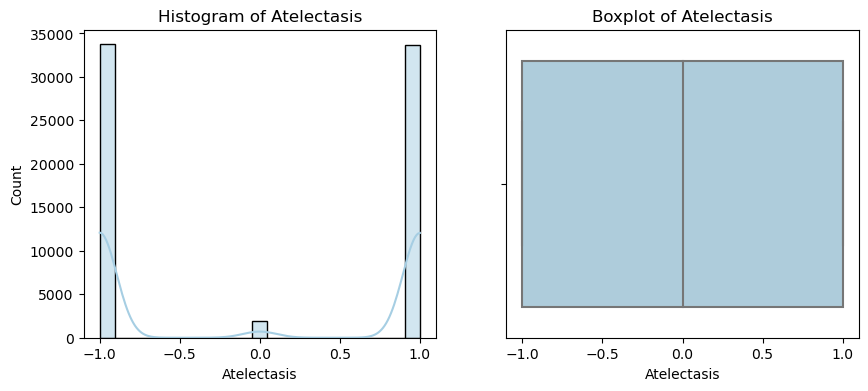

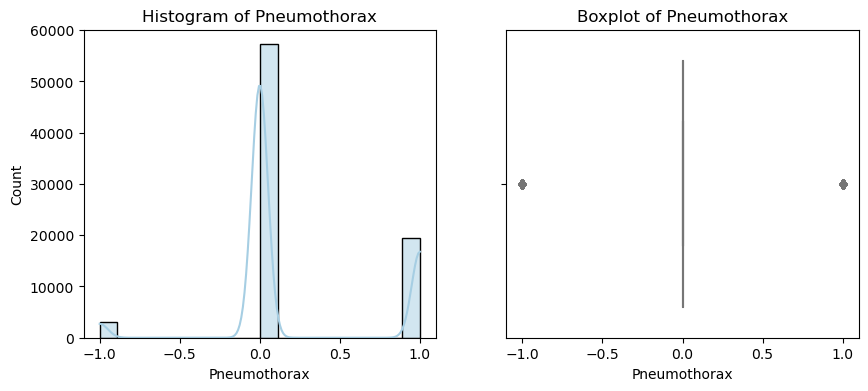

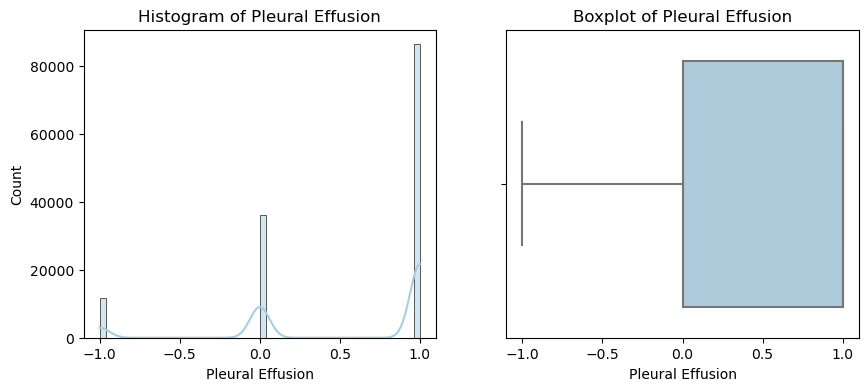

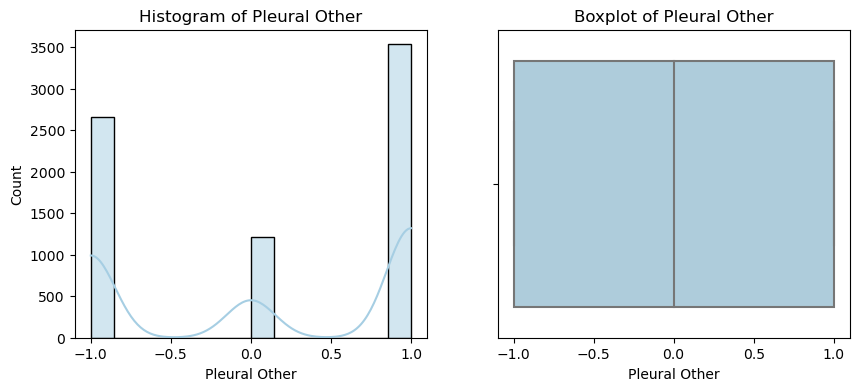

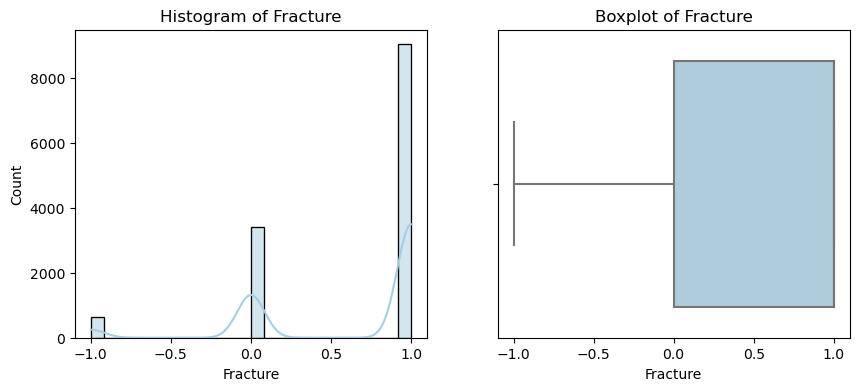

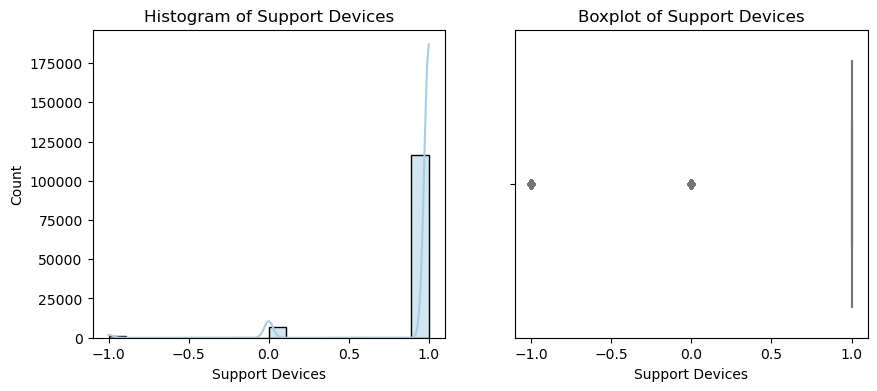

In [21]:
print("Histogram and boxplot for numerical variables:")

palette = sns.color_palette("pastel")
sns.set_palette("Paired")

for column in numerical_data.columns:
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(numerical_data[column], kde=True)
    plt.title(f'Histogram of {column}')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=numerical_data[column])
    plt.title(f'Boxplot of {column}')
    plt.show()

Barchart for categorical variables:


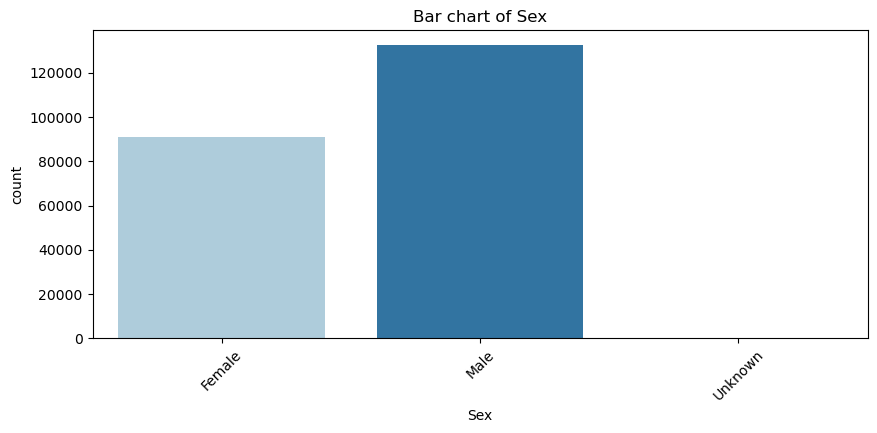

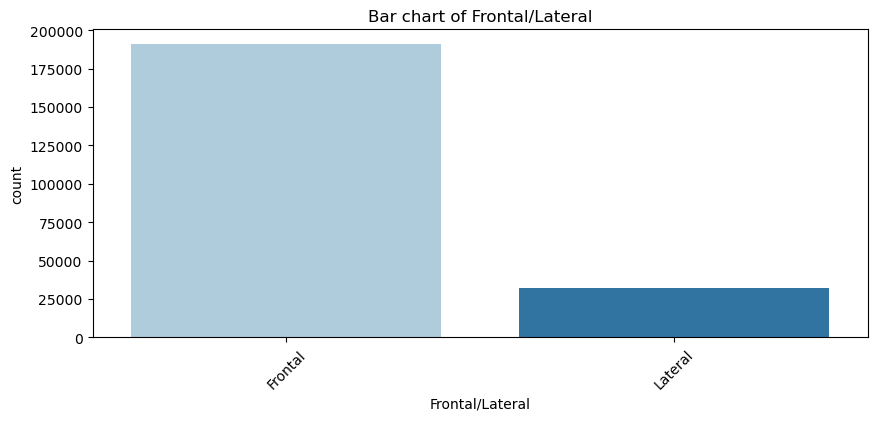

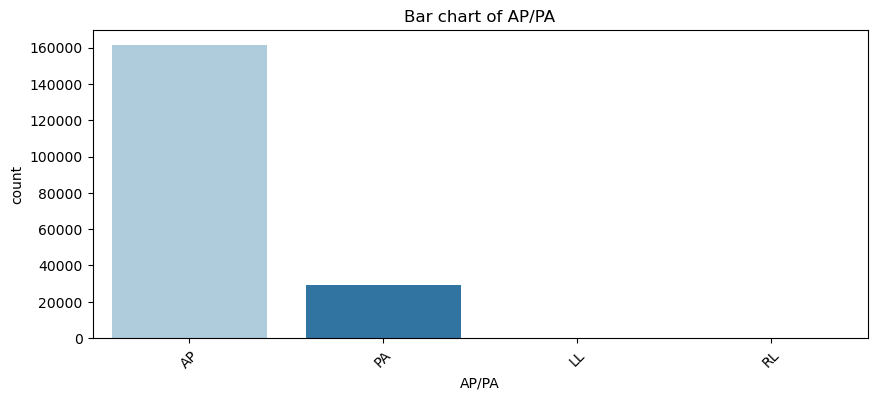

In [22]:
print("Barchart for categorical variables:")

categorical_data = train_data.select_dtypes(include=['object'])
for column in categorical_data.columns:
    plt.figure(figsize=(10, 4))
    sns.countplot(x=categorical_data[column])
    plt.title(f'Bar chart of {column}')
    plt.xticks(rotation=45)
    plt.show()

### In depth: 'Sex' and 'Age'

In [124]:
data['PatientID'] = data['Path'].str.extract('(patient\d+)/')
data_by_patient = data.groupby('PatientID').agg({
    'Age': 'mean', 
    'Sex': 'first'
}).reset_index()

display(data_by_patient)

PatientID        Age     Sex
0      patient00001  68.000000  Female
1      patient00002  84.333333  Female
2      patient00003  41.000000    Male
3      patient00004  20.000000  Female
4      patient00005  33.000000    Male
...             ...        ...     ...
65235  patient65236        NaN    None
65236  patient65237        NaN    None
65237  patient65238        NaN    None
65238  patient65239        NaN    None
65239  patient65240        NaN    None

[65240 rows x 3 columns]

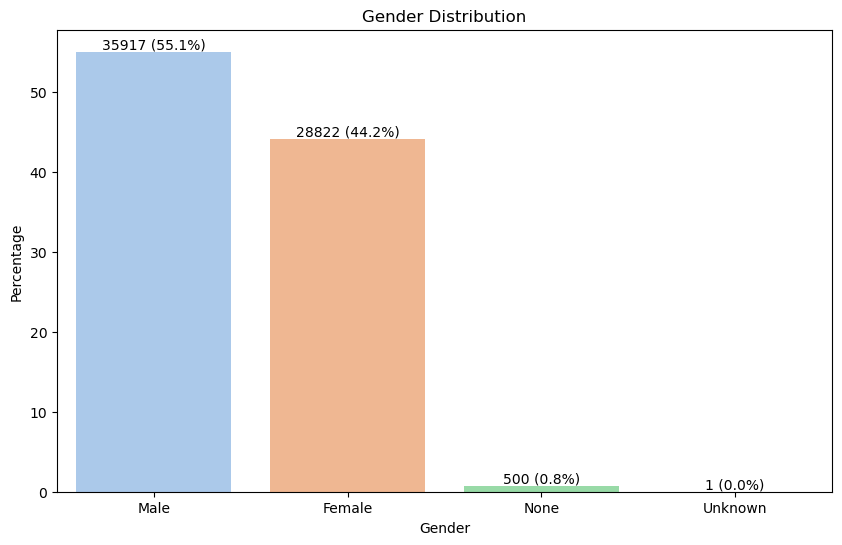

In [129]:
data_by_patient['Sex'].replace({None: 'None'}, inplace=True)

counts = data_by_patient['Sex'].value_counts(dropna=False)  # Includes 'None' values

total = data_by_patient['Sex'].size  # Total count, including 'None'
percentages = (counts / total) * 100

plt.figure(figsize=(10, 6))
bars = sns.barplot(x=percentages.index, y=percentages.values, palette="pastel")
plt.ylabel('Percentage')

for bar, count in zip(bars.patches, counts.values):
    text_x = bar.get_x() + bar.get_width() / 2
    text_y = bar.get_height()
    text = f'{count} ({text_y:.1f}%)'
    bars.text(text_x, text_y, text, ha='center', va='bottom')

plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.show()


In [130]:
bins = [0,10,20,30,40,50,60,70,80,90,110]
labels = ['0-9', '10-19','20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+']
data_by_patient['AgeGroup'] = pd.cut(data_by_patient['Age'], bins=bins, labels=labels, right=False)

In [131]:
age = data_by_patient.groupby(["AgeGroup"]).size().reset_index()
age = age.rename(columns={0: "Count"})
age["Percentage"] = (age['Count'] / age['Count'].sum()) * 100
age

AgeGroup  Count  Percentage
0      0-9      3    0.004634
1    10-19    697    1.076614
2    20-29   4285    6.618783
3    30-39   5012    7.741736
4    40-49   7709   11.907631
5    50-59  11865   18.327155
6    60-69  12815   19.794563
7    70-79  10995   16.983318
8    80-89   8926   13.787458
9      90+   2433    3.758109

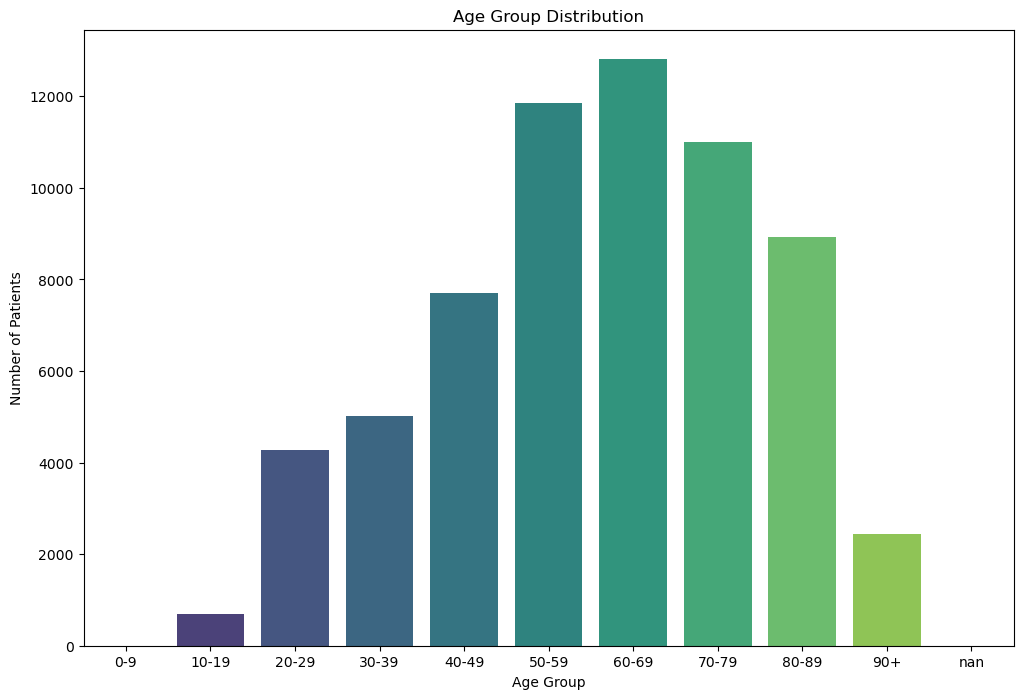

In [138]:
plt.figure(figsize=(12, 8))

age_group_order = data_by_patient['AgeGroup'].sort_values().unique()
sns.countplot(data=data_by_patient, x='AgeGroup', order=age_group_order, palette='viridis')

plt.title('Age Group Distribution')
plt.xlabel('Age Group')
plt.ylabel('Number of Patients')

plt.show()


<Axes: xlabel='AgeGroup'>

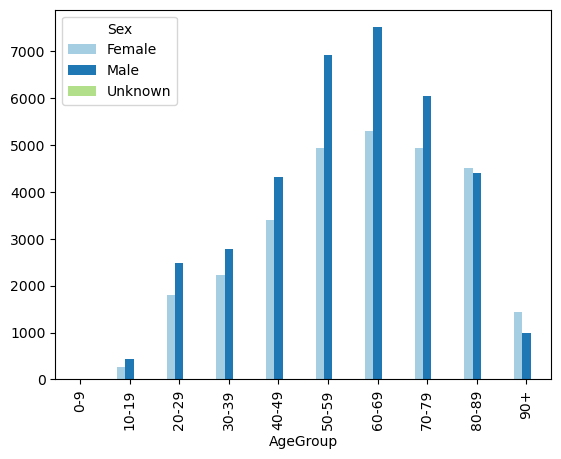

In [140]:
pd.crosstab(data_by_patient['AgeGroup'],data_by_patient['Sex']).plot.bar()

### In depth: 'Frontal/Lateral'

In [58]:
view_counts = data['Frontal/Lateral'].value_counts(dropna=False)
view_percentages = view_counts / len(data) * 100

view_df = pd.DataFrame({
    'Counts': view_counts,
    'Percentages': view_percentages
}).rename(columns={'index': 'Frontal/Lateral'})

view_df['Percentages'] = view_df['Percentages'].apply(lambda x: f"{x:.2f}%")

display(view_df)

Counts Percentages
Frontal  191229      85.25%
Lateral   32419      14.45%
NaN         668       0.30%

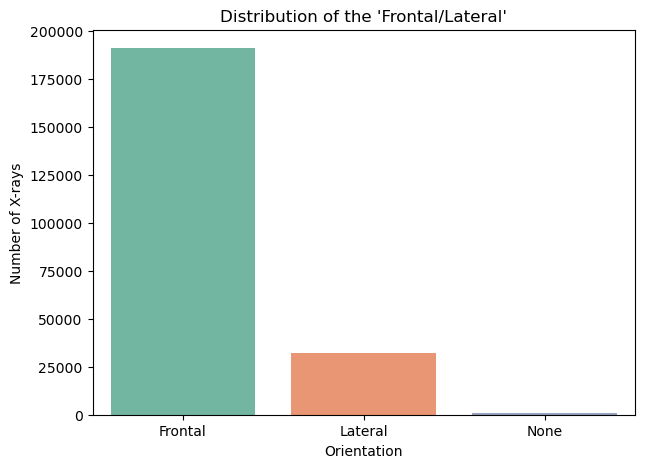

In [157]:
data['Frontal/Lateral'].fillna('None', inplace=True)

orientation_counts = data['Frontal/Lateral'].value_counts(dropna=False)

plt.figure(figsize=(7, 5))
sns.barplot(x=orientation_counts.index, y=orientation_counts.values, palette='Set2')
plt.title("Distribution of the 'Frontal/Lateral' column")
plt.xlabel('Orientation')
plt.ylabel('Number of X-rays')
plt.show()

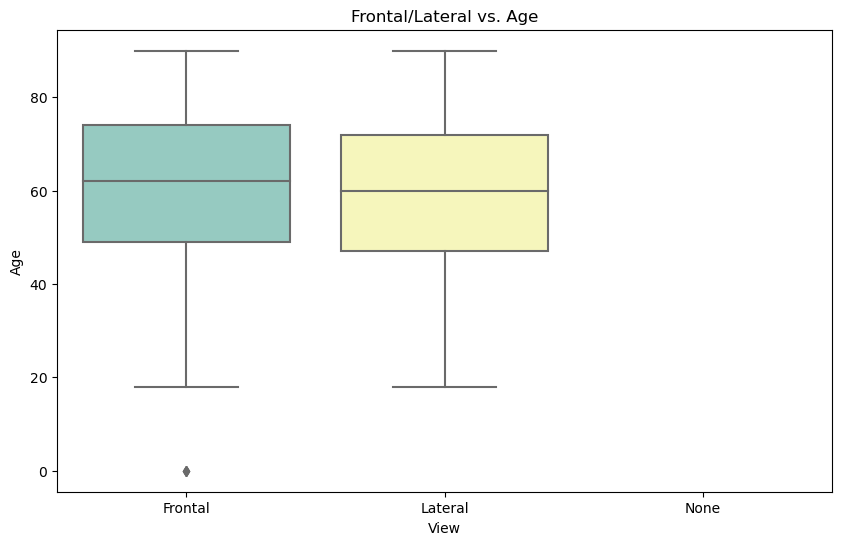

In [161]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Frontal/Lateral', y='Age', data=data, palette='Set3')
plt.title('Frontal/Lateral vs. Age')
plt.xlabel('View')
plt.ylabel('Age')
plt.show()

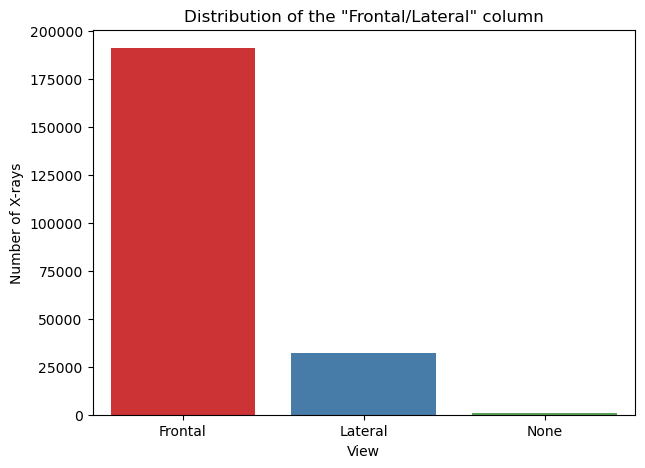

In [169]:
data['Frontal/Lateral'].fillna('None', inplace=True)

orientation_counts = data['Frontal/Lateral'].value_counts(dropna=False)

plt.figure(figsize=(7, 5))
sns.barplot(x=orientation_counts.index, y=orientation_counts.values, palette='Set1')
plt.title('Distribution of the "Frontal/Lateral" column')
plt.xlabel('View')
plt.ylabel('Number of X-rays')
plt.show()

### In depth: 'AP/PA'

The "AP/PA" column indicates the orientation of the X-ray beam relative to the patient's body:
* **AP (Anteroposterior):** X-ray beam enters the front of the chest and exits the back. Commonly used when patients cannot stand.

* **PA (Posteroanterior):** X-ray beam enters the back of the chest and exits the front. This is the standard chest X-ray view, preferred for diagnostic accuracy.

* **LL (Left Lateral):** In a left lateral view, the patient's left side is closest to the X-ray plate, and the X-ray beam travels from the patient's right side to their left side.

* **RL (Right Lateral):** Conversely, in a right lateral view, the patient's right side is closest to the X-ray plate, with the X-ray beam passing from the patient's left side to their right side.

In [147]:
orientation_counts = data['AP/PA'].value_counts(dropna=False)
orientation_percentages = orientation_counts / len(data) * 100

orientation_df = pd.DataFrame({
    'Counts': orientation_counts,
    'Percentages': orientation_percentages
}).rename(columns={'index': 'AP/PA'})

orientation_df['Percentages'] = orientation_df['Percentages'].apply(lambda x: f"{x:.2f}%")

display(orientation_df)


Counts Percentages
AP   161759      72.11%
NaN   33087      14.75%
PA    29453      13.13%
LL       16       0.01%
RL        1       0.00%

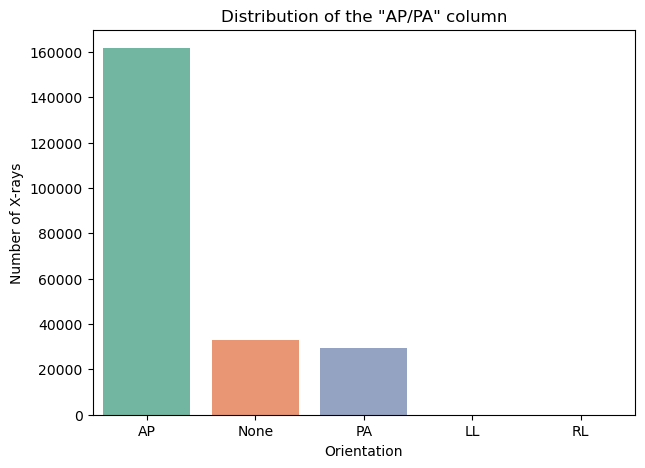

In [165]:
data['AP/PA'].fillna('None', inplace=True)

orientation_counts = data['AP/PA'].value_counts(dropna=False)

plt.figure(figsize=(7, 5))
sns.barplot(x=orientation_counts.index, y=orientation_counts.values, palette='Set2')
plt.title('Distribution of the "AP/PA" column')
plt.xlabel('Orientation')
plt.ylabel('Number of X-rays')
plt.show()

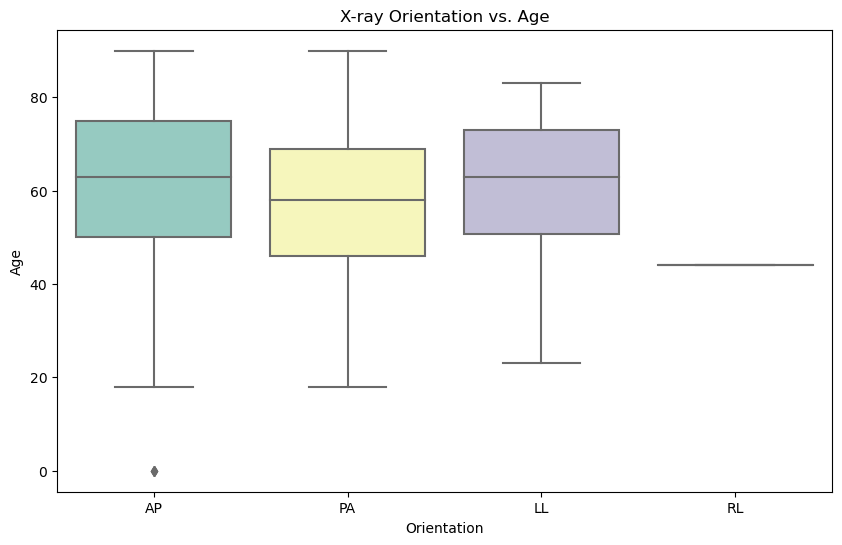

In [142]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='AP/PA', y='Age', data=data, palette='Set3')
plt.title('AP/PA vs. Age')
plt.xlabel('Orientation')
plt.ylabel('Age')
plt.show()

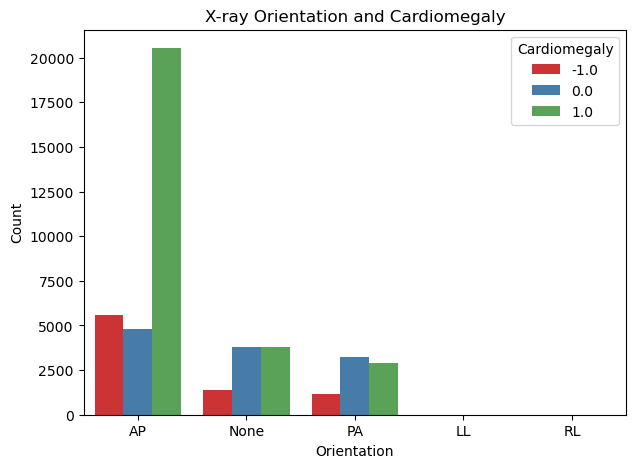

In [167]:
plt.figure(figsize=(7, 5))
sns.countplot(x='AP/PA', hue='Cardiomegaly', data=data, palette='Set1')
plt.title('X-ray Orientation and Cardiomegaly')
plt.xlabel('Orientation')
plt.ylabel('Count')
plt.legend(title='Cardiomegaly', loc='upper right')
plt.show()

## Relationship between variables

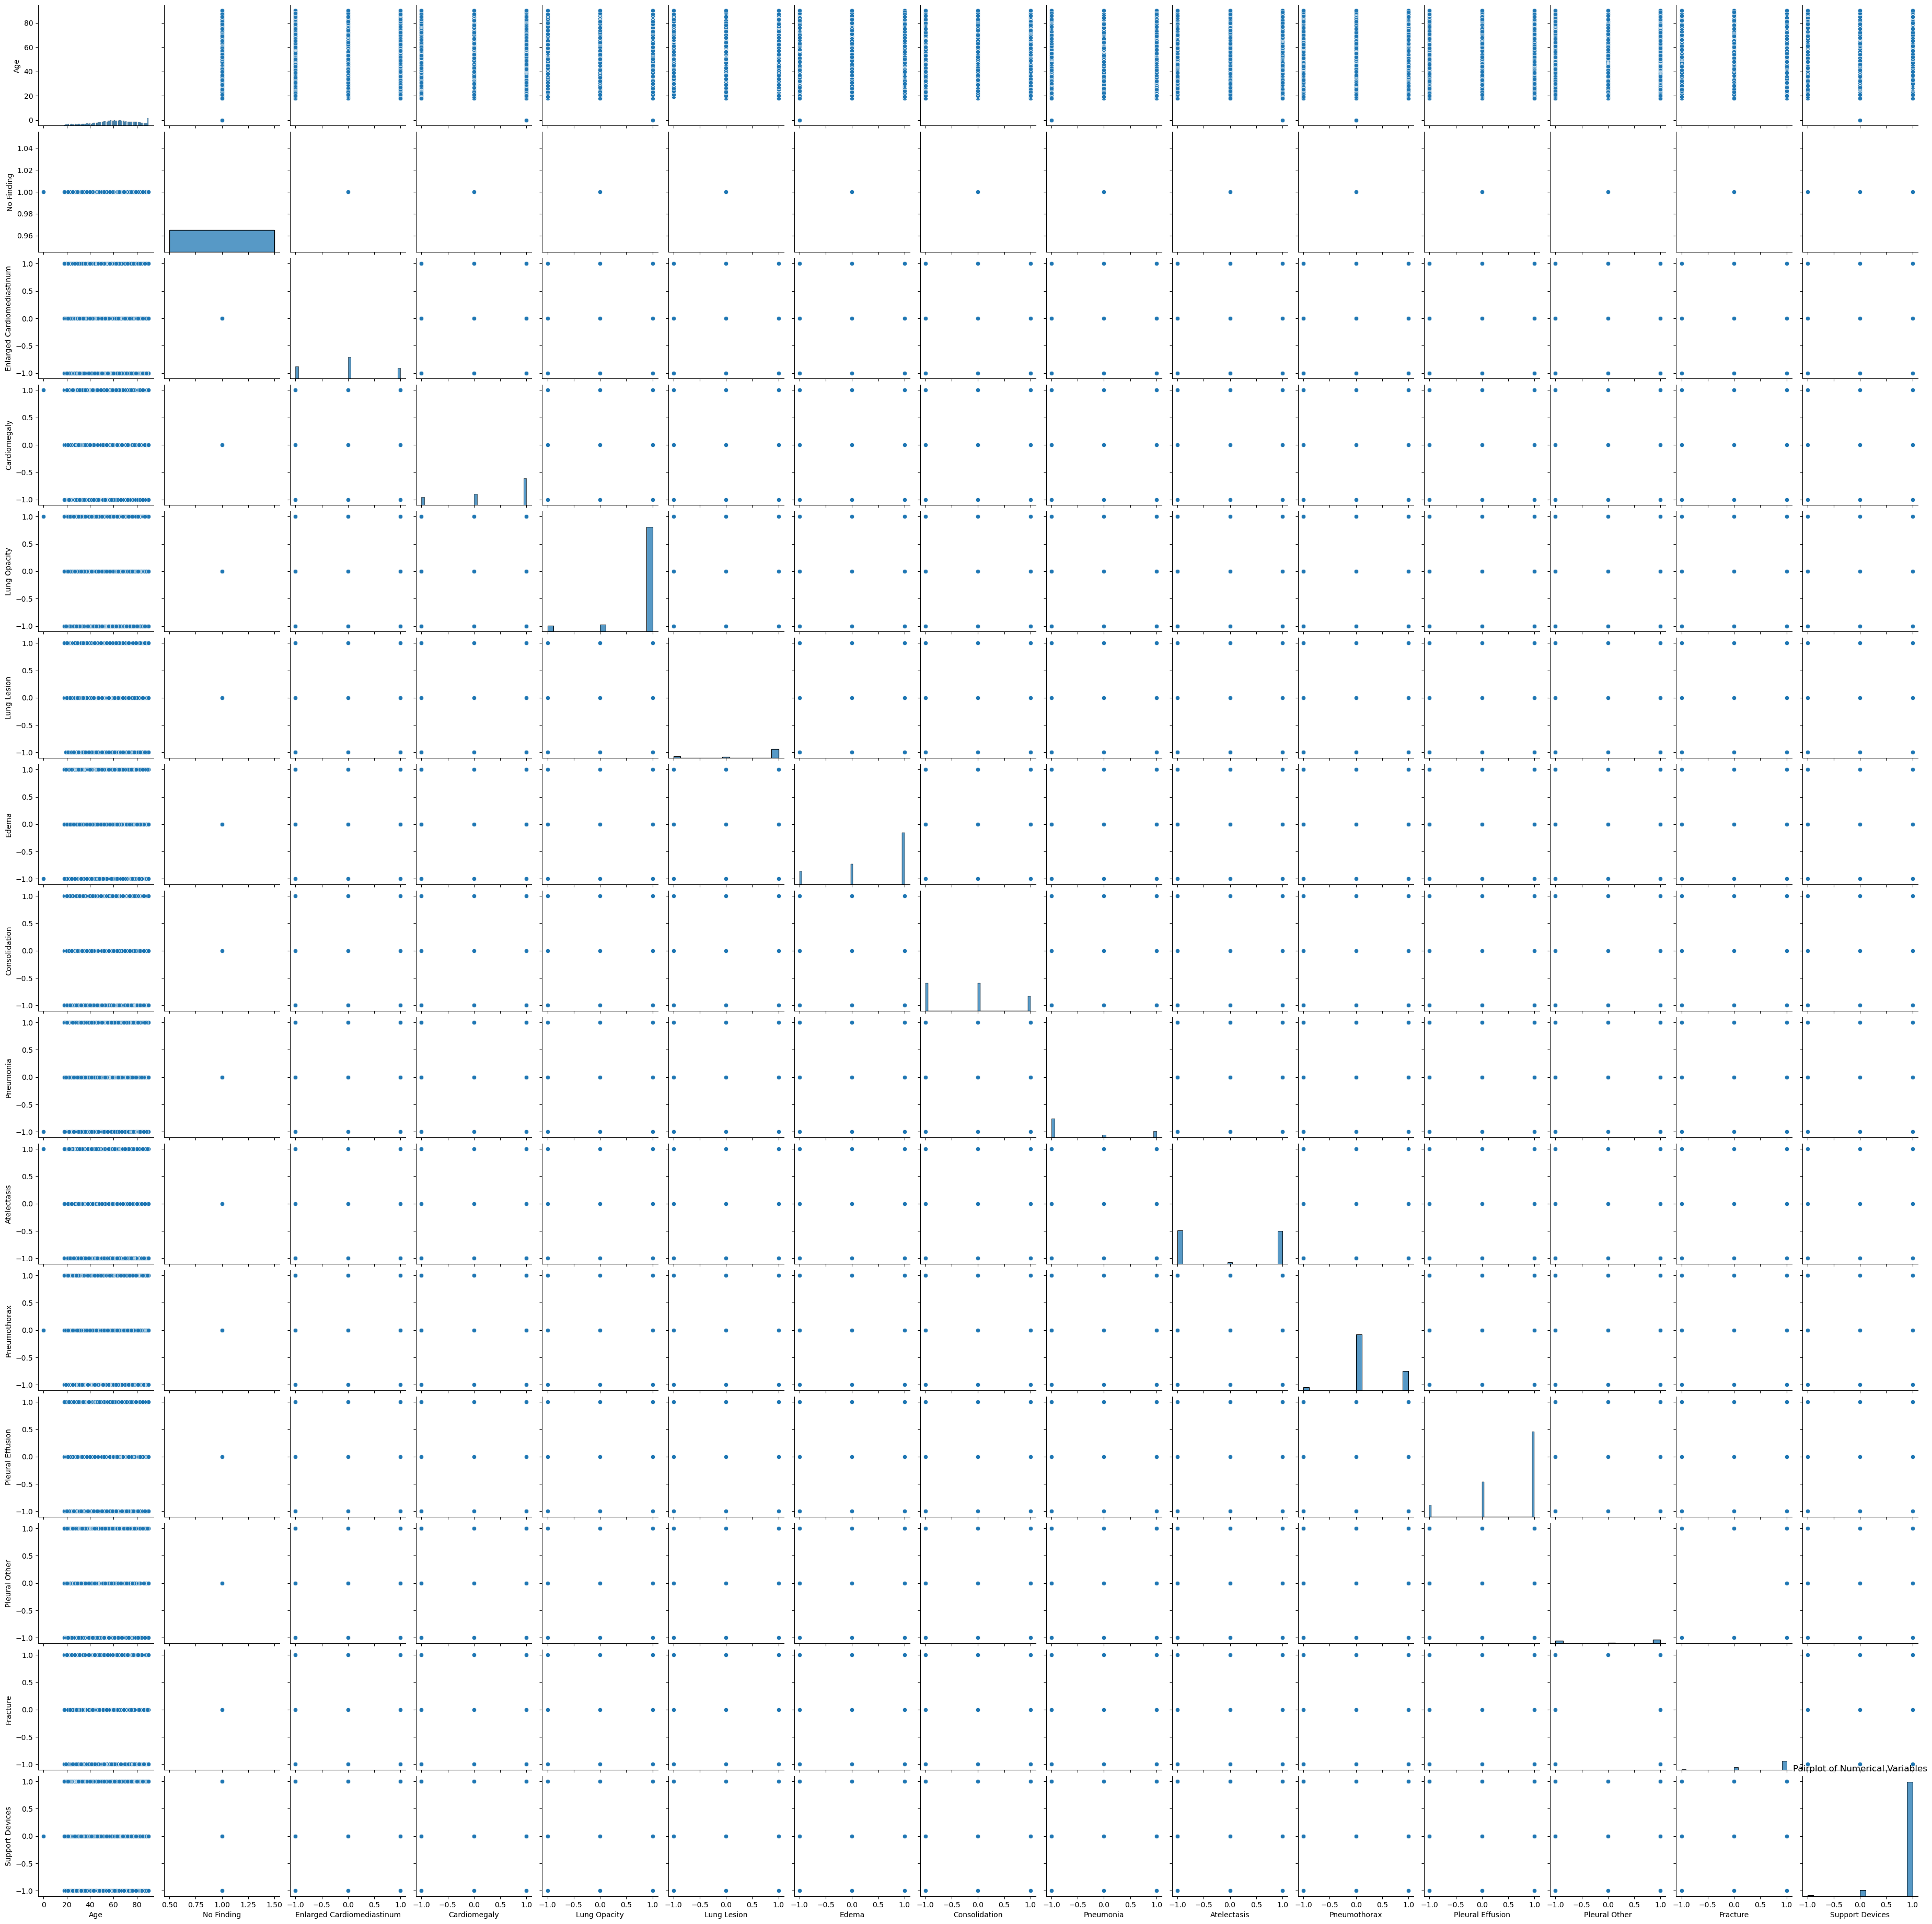

In [21]:
##trying to find potential connections tal vez... or correlation matrix!!

sns.pairplot(numerical_data)
plt.title('Pairplot of Numerical Variables')
plt.show()

The correlation matrix:


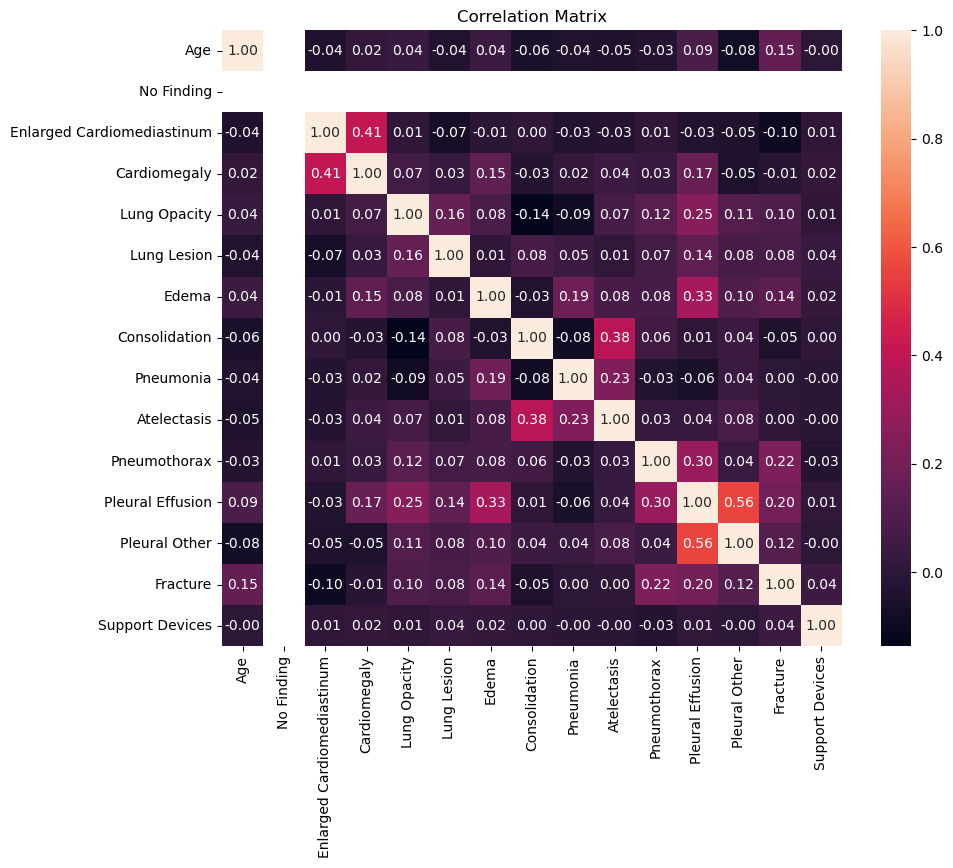

In [22]:
print("The correlation matrix:")

plt.figure(figsize=(10, 8))
sns.heatmap(numerical_data.corr(), annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

#### **5.  Patterns or anomalies**

- Look for outliers, unusual observations, or patterns in your data through plots and statistical summaries.
- Investigate any anomalies to understand their cause — they could be data entry errors, exceptional cases, or important discoveries.

## Visualizing the chest X-rays


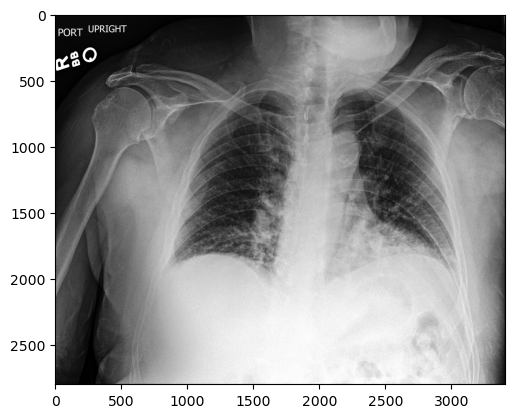

In [23]:
img_id = "view1_frontal.jpg"
img_dir = "patient64813/study1"
img_path = '../../data_shares/purrlab/CheXpert/chexlocalize/CheXpert/test/' + img_dir + '/' + img_id
img = imread(img_path)

plt.imshow(img, cmap='gray')
plt.show()

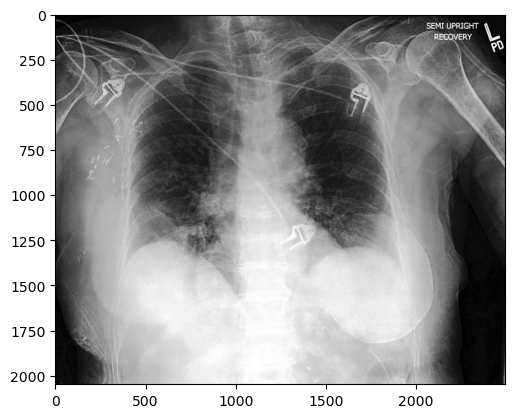

In [24]:
img_id = "view1_frontal.jpg"
img_dir = "patient64742/study1"
img_path = '../../data_shares/purrlab/CheXpert/chexlocalize/CheXpert/test/' + img_dir + '/' + img_id
img = imread(img_path)

plt.imshow(img, cmap='gray')
plt.show()

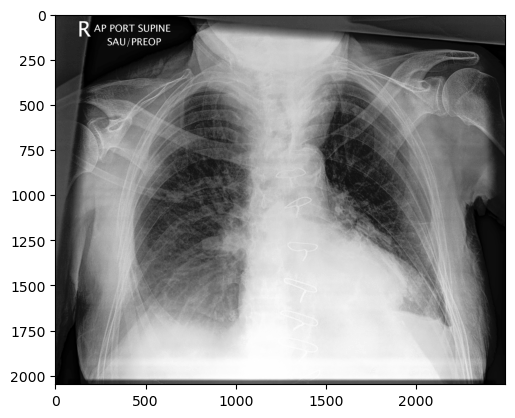

In [25]:
img_id = "view1_frontal.jpg"
img_dir = "patient64743/study1"
img_path = '../../data_shares/purrlab/CheXpert/chexlocalize/CheXpert/test/' + img_dir + '/' + img_id
img = imread(img_path)

plt.imshow(img, cmap='gray')
plt.show()

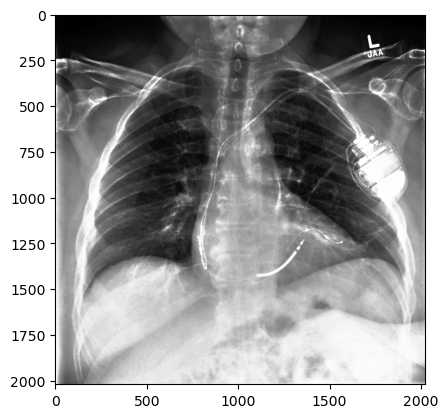

In [26]:
img_id = "view1_frontal.jpg"
img_dir = "patient64744/study1"
img_path = '../../data_shares/purrlab/CheXpert/chexlocalize/CheXpert/test/' + img_dir + '/' + img_id
img = imread(img_path)

plt.imshow(img, cmap='gray')
plt.show()

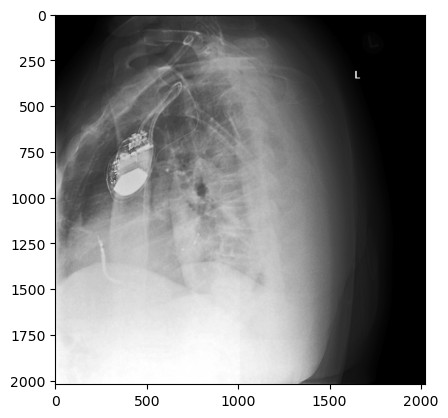

In [27]:
img_id = "view2_lateral.jpg"
img_dir = "patient64744/study1"
img_path = '../../data_shares/purrlab/CheXpert/chexlocalize/CheXpert/test/' + img_dir + '/' + img_id
img = imread(img_path)

plt.imshow(img, cmap='gray')
plt.show()

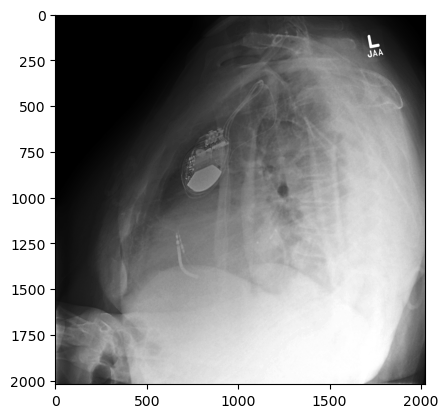

In [28]:
img_id = "view3_lateral.jpg"
img_dir = "patient64744/study1"
img_path = '../../data_shares/purrlab/CheXpert/chexlocalize/CheXpert/test/' + img_dir + '/' + img_id
img = imread(img_path)

plt.imshow(img, cmap='gray')
plt.show()

## Random, Balanced, Biased Data Splits

### Train Data

In [4]:
import pandas as pd
from tabulate import tabulate

original_train_data = pd.read_csv("../../../data_shares/purrlab/CheXpert/CheXpert-v1.0-small/train.csv", index_col=0)

original_train_data = original_train_data[original_train_data['Sex'] != 'Unknown']

sex_distribution_counts = original_train_data['Sex'].value_counts(dropna=False)
sex_distribution_percentages = original_train_data['Sex'].value_counts(normalize=True, dropna=False) * 100

sex_distribution_table = pd.DataFrame({
    'Count': sex_distribution_counts,
    'Percentage': sex_distribution_percentages.map('{:.2f}%'.format)
})

print("Sex Distribution:")
print(tabulate(sex_distribution_table, headers='keys', tablefmt='fancy_grid'))

original_train_data['Pneumothorax'] = original_train_data['Pneumothorax'].replace([-1, 0], "Negative")
original_train_data['Pneumothorax'] = original_train_data['Pneumothorax'].fillna("Negative")
original_train_data['Pneumothorax'] = original_train_data['Pneumothorax'].replace([1], "Positive")

pneumothorax_distribution_counts = original_train_data['Pneumothorax'].value_counts(dropna=False)
pneumothorax_distribution_percentages = original_train_data['Pneumothorax'].value_counts(normalize=True, dropna=False) * 100

pneumothorax_distribution_table = pd.DataFrame({
    'Count': pneumothorax_distribution_counts,
    'Percentage': pneumothorax_distribution_percentages.map('{:.2f}%'.format)
})

print("\nPneumothorax Distribution:")
print(tabulate(pneumothorax_distribution_table, headers='keys', tablefmt='fancy_grid'))


Sex Distribution:
╒════════╤═════════╤══════════════╕
│        │   Count │ Percentage   │
╞════════╪═════════╪══════════════╡
│ Male   │  132636 │ 59.37%       │
├────────┼─────────┼──────────────┤
│ Female │   90777 │ 40.63%       │
╘════════╧═════════╧══════════════╛

Pneumothorax Distribution:
╒══════════╤═════════╤══════════════╕
│          │   Count │ Percentage   │
╞══════════╪═════════╪══════════════╡
│ Negative │  203965 │ 91.30%       │
├──────────┼─────────┼──────────────┤
│ Positive │   19448 │ 8.70%        │
╘══════════╧═════════╧══════════════╛


### Random

In [5]:
random_train_data = pd.read_csv("../shortcuts-chest-xray/preprocess/datasets/random_dataset_train.csv", index_col=0)

sex_distribution_counts = random_train_data['Sex'].value_counts(dropna=False)
sex_distribution_percentages = random_train_data['Sex'].value_counts(normalize=True, dropna=False) * 100

sex_distribution_table = pd.DataFrame({
    'Count': sex_distribution_counts,
    'Percentage': sex_distribution_percentages.map('{:.2f}%'.format)
})

print("Sex Distribution:")
print(tabulate(sex_distribution_table, headers='keys', tablefmt='fancy_grid'))

random_train_data['Pneumothorax'] = random_train_data['Pneumothorax'].replace([-1, 0], "Negative")
random_train_data['Pneumothorax'] = random_train_data['Pneumothorax'].fillna("Negative")
random_train_data['Pneumothorax'] = random_train_data['Pneumothorax'].replace([1], "Positive")

pneumothorax_distribution_counts = random_train_data['Pneumothorax'].value_counts(dropna=False)
pneumothorax_distribution_percentages = random_train_data['Pneumothorax'].value_counts(normalize=True, dropna=False) * 100

pneumothorax_distribution_table = pd.DataFrame({
    'Count': pneumothorax_distribution_counts,
    'Percentage': pneumothorax_distribution_percentages.map('{:.2f}%'.format)
})

print("\nPneumothorax Distribution:")
print(tabulate(pneumothorax_distribution_table, headers='keys', tablefmt='fancy_grid'))


Sex Distribution:
╒════════╤═════════╤══════════════╕
│        │   Count │ Percentage   │
╞════════╪═════════╪══════════════╡
│ Male   │    9005 │ 57.18%       │
├────────┼─────────┼──────────────┤
│ Female │    6744 │ 42.82%       │
╘════════╧═════════╧══════════════╛

Pneumothorax Distribution:
╒══════════╤═════════╤══════════════╕
│          │   Count │ Percentage   │
╞══════════╪═════════╪══════════════╡
│ Negative │   14456 │ 91.79%       │
├──────────┼─────────┼──────────────┤
│ Positive │    1293 │ 8.21%        │
╘══════════╧═════════╧══════════════╛


In [6]:
pneumothorax_by_sex_distribution = random_train_data.groupby('Sex')['Pneumothorax'].value_counts(normalize=False, dropna=False)
pneumothorax_by_sex_percentage = random_train_data.groupby('Sex')['Pneumothorax'].value_counts(normalize=True, dropna=False) * 100

print("Pneumothorax Distribution within Each Gender:\n")
for (sex, pneumothorax), count in pneumothorax_by_sex_distribution.items():
    percentage = pneumothorax_by_sex_percentage[(sex, pneumothorax)]
    print(f"{sex}, Pneumothorax={pneumothorax}: {count} ({percentage:.2f}%)")


Pneumothorax Distribution within Each Gender:

Female, Pneumothorax=Negative: 6216 (92.17%)
Female, Pneumothorax=Positive: 528 (7.83%)
Male, Pneumothorax=Negative: 8240 (91.50%)
Male, Pneumothorax=Positive: 765 (8.50%)


In [11]:
pneumothorax_by_sex_distribution = random_train_data.groupby(['Sex', 'Pneumothorax']).size().unstack(fill_value=0)
pneumothorax_by_sex_percentage = pneumothorax_by_sex_distribution.div(pneumothorax_by_sex_distribution.sum(axis=1), axis=0) * 100

combined_table = pneumothorax_by_sex_distribution.astype(str) + ' (' + pneumothorax_by_sex_percentage.round(2).astype(str) + '%)'

print("Combined Pneumothorax Distribution within Each Gender:")
print(tabulate(combined_table, headers='keys', tablefmt='fancy_grid'))


Combined Pneumothorax Distribution within Each Gender:
╒════════╤═══════════════╤═════════════╕
│ Sex    │ Negative      │ Positive    │
╞════════╪═══════════════╪═════════════╡
│ Female │ 6216 (92.17%) │ 528 (7.83%) │
├────────┼───────────────┼─────────────┤
│ Male   │ 8240 (91.5%)  │ 765 (8.5%)  │
╘════════╧═══════════════╧═════════════╛


In [8]:
random_data_val = pd.read_csv("../shortcuts-chest-xray/random_dataset_train.csv", index_col=0)

sex_distribution_counts = random_data_val['Sex'].value_counts(dropna=False)
sex_distribution_percentages = random_data_val['Sex'].value_counts(normalize=True, dropna=False) * 100

print("Sex Distribution:")
for index in sex_distribution_counts.index:
    print(f"{index}: {sex_distribution_counts[index]} ({sex_distribution_percentages[index]:.2f}%)")

pneumothorax_distribution_counts = random_data_val['Pneumothorax'].value_counts(dropna=False)
pneumothorax_distribution_percentages = random_data_val['Pneumothorax'].value_counts(normalize=True, dropna=False) * 100

print("\nPneumothorax Distribution:")
for index in pneumothorax_distribution_counts.index:
    print(f"{index}: {pneumothorax_distribution_counts[index]} ({pneumothorax_distribution_percentages[index]:.2f}%)")

Sex Distribution:
Male: 9005 (57.18%)
Female: 6744 (42.82%)

Pneumothorax Distribution:
nan: 9991 (63.44%)
0.0: 4251 (26.99%)
1.0: 1293 (8.21%)
-1.0: 214 (1.36%)


In [9]:
random_data_test = pd.read_csv("../shortcuts-chest-xray/random_dataset_test.csv", index_col=0)

sex_distribution_counts = random_data_test['Sex'].value_counts(dropna=False)
sex_distribution_percentages = random_data_test['Sex'].value_counts(normalize=True, dropna=False) * 100

print("Sex Distribution:")
for index in sex_distribution_counts.index:
    print(f"{index}: {sex_distribution_counts[index]} ({sex_distribution_percentages[index]:.2f}%)")

pneumothorax_distribution_counts = random_data_test['Pneumothorax'].value_counts(dropna=False)
pneumothorax_distribution_percentages = random_data_test['Pneumothorax'].value_counts(normalize=True, dropna=False) * 100

print("\nPneumothorax Distribution:")
for index in pneumothorax_distribution_counts.index:
    print(f"{index}: {pneumothorax_distribution_counts[index]} ({pneumothorax_distribution_percentages[index]:.2f}%)")

Sex Distribution:
Male: 2307 (59.97%)
Female: 1540 (40.03%)

Pneumothorax Distribution:
nan: 2440 (63.43%)
0.0: 1010 (26.25%)
1.0: 345 (8.97%)
-1.0: 52 (1.35%)


### Balanced data

In [16]:
balanced_train_data = pd.read_csv("../shortcuts-chest-xray/preprocess/datasets/balanced_dataset_train.csv", index_col=0)

sex_distribution_counts = balanced_train_data['Sex'].value_counts(dropna=False)
sex_distribution_percentages = balanced_train_data['Sex'].value_counts(normalize=True, dropna=False) * 100

sex_distribution_table = pd.DataFrame({
    'Count': sex_distribution_counts,
    'Percentage': sex_distribution_percentages.map('{:.2f}%'.format)
})

print("Sex Distribution:")
print(tabulate(sex_distribution_table, headers='keys', tablefmt='fancy_grid'))

balanced_train_data['Pneumothorax'] = balanced_train_data['Pneumothorax'].replace([-1, 0], "Negative")
balanced_train_data['Pneumothorax'] = balanced_train_data['Pneumothorax'].fillna("Negative")
balanced_train_data['Pneumothorax'] = balanced_train_data['Pneumothorax'].replace([1], "Positive")

pneumothorax_distribution_counts = balanced_train_data['Pneumothorax'].value_counts(dropna=False)
pneumothorax_distribution_percentages = balanced_train_data['Pneumothorax'].value_counts(normalize=True, dropna=False) * 100

pneumothorax_distribution_table = pd.DataFrame({
    'Count': pneumothorax_distribution_counts,
    'Percentage': pneumothorax_distribution_percentages.map('{:.2f}%'.format)
})

print("\nPneumothorax Distribution:")
print(tabulate(pneumothorax_distribution_table, headers='keys', tablefmt='fancy_grid'))


Sex Distribution:
╒════════╤═════════╤══════════════╕
│        │   Count │ Percentage   │
╞════════╪═════════╪══════════════╡
│ Male   │   10552 │ 51.18%       │
├────────┼─────────┼──────────────┤
│ Female │   10066 │ 48.82%       │
╘════════╧═════════╧══════════════╛

Pneumothorax Distribution:
╒══════════╤═════════╤══════════════╕
│          │   Count │ Percentage   │
╞══════════╪═════════╪══════════════╡
│ Negative │   10420 │ 50.54%       │
├──────────┼─────────┼──────────────┤
│ Positive │   10198 │ 49.46%       │
╘══════════╧═════════╧══════════════╛


In [19]:
pneumothorax_by_sex_distribution = balanced_train_data.groupby(['Sex', 'Pneumothorax']).size().unstack(fill_value=0)
pneumothorax_by_sex_percentage = pneumothorax_by_sex_distribution.div(pneumothorax_by_sex_distribution.sum(axis=1), axis=0) * 100

combined_table = pneumothorax_by_sex_distribution.astype(str) + ' (' + pneumothorax_by_sex_percentage.round(2).astype(str) + '%)'

print("Combined Pneumothorax Distribution within Each Gender:")
print(tabulate(combined_table, headers='keys', tablefmt='fancy_grid'))


Combined Pneumothorax Distribution within Each Gender:
╒════════╤═══════════════╤═══════════════╕
│ Sex    │ Negative      │ Positive      │
╞════════╪═══════════════╪═══════════════╡
│ Female │ 5198 (51.64%) │ 4868 (48.36%) │
├────────┼───────────────┼───────────────┤
│ Male   │ 5222 (49.49%) │ 5330 (50.51%) │
╘════════╧═══════════════╧═══════════════╛


In [4]:
balanced_data_val = pd.read_csv("../shortcuts-chest-xray/balanced_dataset_val.csv", index_col=0)

sex_distribution_counts = balanced_data_val['Sex'].value_counts(dropna=False)
sex_distribution_percentages = balanced_data_val['Sex'].value_counts(normalize=True, dropna=False) * 100

print("Sex Distribution:")
for index in sex_distribution_counts.index:
    print(f"{index}: {sex_distribution_counts[index]} ({sex_distribution_percentages[index]:.2f}%)")

pneumothorax_distribution_counts = balanced_data_val['Pneumothorax'].value_counts(dropna=False)
pneumothorax_distribution_percentages = balanced_data_val['Pneumothorax'].value_counts(normalize=True, dropna=False) * 100

print("\nPneumothorax Distribution:")
for index in pneumothorax_distribution_counts.index:
    print(f"{index}: {pneumothorax_distribution_counts[index]} ({pneumothorax_distribution_percentages[index]:.2f}%)")

Sex Distribution:
Female: 2239 (50.29%)
Male: 2213 (49.71%)

Pneumothorax Distribution:
1.0: 2166 (48.65%)
nan: 1626 (36.52%)
0.0: 613 (13.77%)
-1.0: 47 (1.06%)


In [5]:
balanced_data_test = pd.read_csv("../shortcuts-chest-xray/balanced_dataset_test.csv", index_col=0)

sex_distribution_counts = balanced_data_test['Sex'].value_counts(dropna=False)
sex_distribution_percentages = balanced_data_test['Sex'].value_counts(normalize=True, dropna=False) * 100

print("Sex Distribution:")
for index in sex_distribution_counts.index:
    print(f"{index}: {sex_distribution_counts[index]} ({sex_distribution_percentages[index]:.2f}%)")

pneumothorax_distribution_counts = balanced_data_test['Pneumothorax'].value_counts(dropna=False)
pneumothorax_distribution_percentages = balanced_data_test['Pneumothorax'].value_counts(normalize=True, dropna=False) * 100

print("\nPneumothorax Distribution:")
for index in pneumothorax_distribution_counts.index:
    print(f"{index}: {pneumothorax_distribution_counts[index]} ({pneumothorax_distribution_percentages[index]:.2f}%)")

Sex Distribution:
Male: 2235 (51.10%)
Female: 2139 (48.90%)

Pneumothorax Distribution:
1.0: 2080 (47.55%)
nan: 1631 (37.29%)
0.0: 638 (14.59%)
-1.0: 25 (0.57%)


### Biased

In [20]:
biased_train_data = pd.read_csv("../shortcuts-chest-xray/preprocess/datasets/biased_dataset_train.csv", index_col=0)

sex_distribution_counts = biased_train_data['Sex'].value_counts(dropna=False)
sex_distribution_percentages = biased_train_data['Sex'].value_counts(normalize=True, dropna=False) * 100

sex_distribution_table = pd.DataFrame({
    'Count': sex_distribution_counts,
    'Percentage': sex_distribution_percentages.map('{:.2f}%'.format)
})

print("Sex Distribution:")
print(tabulate(sex_distribution_table, headers='keys', tablefmt='fancy_grid'))

biased_train_data['Pneumothorax'] = biased_train_data['Pneumothorax'].replace([-1, 0], "Negative")
biased_train_data['Pneumothorax'] = biased_train_data['Pneumothorax'].fillna("Negative")
biased_train_data['Pneumothorax'] = biased_train_data['Pneumothorax'].replace([1], "Positive")

pneumothorax_distribution_counts = biased_train_data['Pneumothorax'].value_counts(dropna=False)
pneumothorax_distribution_percentages = biased_train_data['Pneumothorax'].value_counts(normalize=True, dropna=False) * 100

pneumothorax_distribution_table = pd.DataFrame({
    'Count': pneumothorax_distribution_counts,
    'Percentage': pneumothorax_distribution_percentages.map('{:.2f}%'.format)
})

print("\nPneumothorax Distribution:")
print(tabulate(pneumothorax_distribution_table, headers='keys', tablefmt='fancy_grid'))


Sex Distribution:
╒════════╤═════════╤══════════════╕
│        │   Count │ Percentage   │
╞════════╪═════════╪══════════════╡
│ Male   │   16184 │ 79.75%       │
├────────┼─────────┼──────────────┤
│ Female │    4110 │ 20.25%       │
╘════════╧═════════╧══════════════╛

Pneumothorax Distribution:
╒══════════╤═════════╤══════════════╕
│          │   Count │ Percentage   │
╞══════════╪═════════╪══════════════╡
│ Negative │   10528 │ 51.88%       │
├──────────┼─────────┼──────────────┤
│ Positive │    9766 │ 48.12%       │
╘══════════╧═════════╧══════════════╛


In [21]:
pneumothorax_by_sex_distribution = biased_train_data.groupby(['Sex', 'Pneumothorax']).size().unstack(fill_value=0)
pneumothorax_by_sex_percentage = pneumothorax_by_sex_distribution.div(pneumothorax_by_sex_distribution.sum(axis=1), axis=0) * 100

combined_table = pneumothorax_by_sex_distribution.astype(str) + ' (' + pneumothorax_by_sex_percentage.round(2).astype(str) + '%)'

print("Combined Pneumothorax Distribution within Each Gender:")
print(tabulate(combined_table, headers='keys', tablefmt='fancy_grid'))


Combined Pneumothorax Distribution within Each Gender:
╒════════╤═══════════════╤═══════════════╕
│ Sex    │ Negative      │ Positive      │
╞════════╪═══════════════╪═══════════════╡
│ Female │ 2064 (50.22%) │ 2046 (49.78%) │
├────────┼───────────────┼───────────────┤
│ Male   │ 8464 (52.3%)  │ 7720 (47.7%)  │
╘════════╧═══════════════╧═══════════════╛


In [12]:
biased_data_val = pd.read_csv("../shortcuts-chest-xray/biased_dataset_val.csv", index_col=0)

sex_distribution_counts = biased_data_val['Sex'].value_counts(dropna=False)
sex_distribution_percentages = biased_data_val['Sex'].value_counts(normalize=True, dropna=False) * 100

print("Sex Distribution:")
for index in sex_distribution_counts.index:
    print(f"{index}: {sex_distribution_counts[index]} ({sex_distribution_percentages[index]:.2f}%)")

pneumothorax_distribution_counts = biased_data_val['Pneumothorax'].value_counts(dropna=False)
pneumothorax_distribution_percentages = biased_data_val['Pneumothorax'].value_counts(normalize=True, dropna=False) * 100

print("\nPneumothorax Distribution:")
for index in pneumothorax_distribution_counts.index:
    print(f"{index}: {pneumothorax_distribution_counts[index]} ({pneumothorax_distribution_percentages[index]:.2f}%)")

Sex Distribution:
Male: 3317 (78.23%)
Female: 923 (21.77%)

Pneumothorax Distribution:
1.0: 2002 (47.22%)
nan: 1582 (37.31%)
0.0: 620 (14.62%)
-1.0: 36 (0.85%)


In [13]:
biased_data_test = pd.read_csv("../shortcuts-chest-xray/biased_dataset_test.csv", index_col=0)

sex_distribution_counts = biased_data_test['Sex'].value_counts(dropna=False)
sex_distribution_percentages = biased_data_test['Sex'].value_counts(normalize=True, dropna=False) * 100

print("Sex Distribution:")
for index in sex_distribution_counts.index:
    print(f"{index}: {sex_distribution_counts[index]} ({sex_distribution_percentages[index]:.2f}%)")

pneumothorax_distribution_counts = biased_data_test['Pneumothorax'].value_counts(dropna=False)
pneumothorax_distribution_percentages = biased_data_test['Pneumothorax'].value_counts(normalize=True, dropna=False) * 100

print("\nPneumothorax Distribution:")
for index in pneumothorax_distribution_counts.index:
    print(f"{index}: {pneumothorax_distribution_counts[index]} ({pneumothorax_distribution_percentages[index]:.2f}%)")

Sex Distribution:
Male: 3248 (77.06%)
Female: 967 (22.94%)

Pneumothorax Distribution:
1.0: 1981 (47.00%)
nan: 1610 (38.20%)
0.0: 601 (14.26%)
-1.0: 23 (0.55%)


### Biased Pneumothorax data

In [23]:
biased_train_data = pd.read_csv("../shortcuts-chest-xray/preprocess/datasets/biased_pneumothorax_dataset_train.csv", index_col=0)

sex_distribution_counts = biased_train_data['Sex'].value_counts(dropna=False)
sex_distribution_percentages = biased_train_data['Sex'].value_counts(normalize=True, dropna=False) * 100

sex_distribution_table = pd.DataFrame({
    'Count': sex_distribution_counts,
    'Percentage': sex_distribution_percentages.map('{:.2f}%'.format)
})

print("Sex Distribution:")
print(tabulate(sex_distribution_table, headers='keys', tablefmt='fancy_grid'))

biased_train_data['Pneumothorax'] = biased_train_data['Pneumothorax'].replace([-1, 0], "Negative")
biased_train_data['Pneumothorax'] = biased_train_data['Pneumothorax'].fillna("Negative")
biased_train_data['Pneumothorax'] = biased_train_data['Pneumothorax'].replace([1], "Positive")

pneumothorax_distribution_counts = biased_train_data['Pneumothorax'].value_counts(dropna=False)
pneumothorax_distribution_percentages = biased_train_data['Pneumothorax'].value_counts(normalize=True, dropna=False) * 100

pneumothorax_distribution_table = pd.DataFrame({
    'Count': pneumothorax_distribution_counts,
    'Percentage': pneumothorax_distribution_percentages.map('{:.2f}%'.format)
})

print("\nPneumothorax Distribution:")
print(tabulate(pneumothorax_distribution_table, headers='keys', tablefmt='fancy_grid'))


Sex Distribution:
╒════════╤═════════╤══════════════╕
│        │   Count │ Percentage   │
╞════════╪═════════╪══════════════╡
│ Female │   10442 │ 52.07%       │
├────────┼─────────┼──────────────┤
│ Male   │    9612 │ 47.93%       │
╘════════╧═════════╧══════════════╛

Pneumothorax Distribution:
╒══════════╤═════════╤══════════════╕
│          │   Count │ Percentage   │
╞══════════╪═════════╪══════════════╡
│ Negative │   10418 │ 51.95%       │
├──────────┼─────────┼──────────────┤
│ Positive │    9636 │ 48.05%       │
╘══════════╧═════════╧══════════════╛


In [45]:
pneumothorax_by_sex_distribution = biased_data_train.groupby('Sex')['Pneumothorax'].value_counts(normalize=False, dropna=False)
pneumothorax_by_sex_percentage = biased_data_train.groupby('Sex')['Pneumothorax'].value_counts(normalize=True, dropna=False) * 100

print("Pneumothorax Distribution within Each Gender:\n")
for (sex, pneumothorax), count in pneumothorax_by_sex_distribution.items():
    percentage = pneumothorax_by_sex_percentage[(sex, pneumothorax)]
    print(f"{sex}, Pneumothorax={pneumothorax}: {count} ({percentage:.2f}%)")

Pneumothorax Distribution within Each Gender:

Female, Pneumothorax=nan: 6011 (57.57%)
Female, Pneumothorax=0.0: 2202 (21.09%)
Female, Pneumothorax=1.0: 2115 (20.25%)
Female, Pneumothorax=-1.0: 114 (1.09%)
Male, Pneumothorax=1.0: 7521 (78.25%)
Male, Pneumothorax=nan: 1445 (15.03%)
Male, Pneumothorax=0.0: 607 (6.32%)
Male, Pneumothorax=-1.0: 39 (0.41%)


In [24]:
pneumothorax_by_sex_distribution = biased_train_data.groupby(['Sex', 'Pneumothorax']).size().unstack(fill_value=0)
pneumothorax_by_sex_percentage = pneumothorax_by_sex_distribution.div(pneumothorax_by_sex_distribution.sum(axis=1), axis=0) * 100

combined_table = pneumothorax_by_sex_distribution.astype(str) + ' (' + pneumothorax_by_sex_percentage.round(2).astype(str) + '%)'

print("Combined Pneumothorax Distribution within Each Gender:")
print(tabulate(combined_table, headers='keys', tablefmt='fancy_grid'))


Combined Pneumothorax Distribution within Each Gender:
╒════════╤═══════════════╤═══════════════╕
│ Sex    │ Negative      │ Positive      │
╞════════╪═══════════════╪═══════════════╡
│ Female │ 8327 (79.75%) │ 2115 (20.25%) │
├────────┼───────────────┼───────────────┤
│ Male   │ 2091 (21.75%) │ 7521 (78.25%) │
╘════════╧═══════════════╧═══════════════╛


In [48]:
biased_data_val = pd.read_csv("../shortcuts-chest-xray/preprocess/datasets/biased_pneumothorax_dataset_val.csv", index_col=0)

sex_distribution_counts = biased_data_val['Sex'].value_counts(dropna=False)
sex_distribution_percentages = biased_data_val['Sex'].value_counts(normalize=True, dropna=False) * 100

print("Sex Distribution:")
for index in sex_distribution_counts.index:
    print(f"{index}: {sex_distribution_counts[index]} ({sex_distribution_percentages[index]:.2f}%)")

pneumothorax_distribution_counts = biased_data_val['Pneumothorax'].value_counts(dropna=False)
pneumothorax_distribution_percentages = biased_data_val['Pneumothorax'].value_counts(normalize=True, dropna=False) * 100

print("\nPneumothorax Distribution:")
for index in pneumothorax_distribution_counts.index:
    print(f"{index}: {pneumothorax_distribution_counts[index]} ({pneumothorax_distribution_percentages[index]:.2f}%)")

Sex Distribution:
Female: 2329 (52.02%)
Male: 2148 (47.98%)

Pneumothorax Distribution:
1.0: 2160 (48.25%)
nan: 1655 (36.97%)
0.0: 626 (13.98%)
-1.0: 36 (0.80%)


In [49]:
biased_data_test = pd.read_csv("../shortcuts-chest-xray/preprocess/datasets/biased_pneumothorax_dataset_test.csv", index_col=0)

sex_distribution_counts = biased_data_test['Sex'].value_counts(dropna=False)
sex_distribution_percentages = biased_data_test['Sex'].value_counts(normalize=True, dropna=False) * 100

print("Sex Distribution:")
for index in sex_distribution_counts.index:
    print(f"{index}: {sex_distribution_counts[index]} ({sex_distribution_percentages[index]:.2f}%)")

pneumothorax_distribution_counts = biased_data_test['Pneumothorax'].value_counts(dropna=False)
pneumothorax_distribution_percentages = biased_data_test['Pneumothorax'].value_counts(normalize=True, dropna=False) * 100

print("\nPneumothorax Distribution:")
for index in pneumothorax_distribution_counts.index:
    print(f"{index}: {pneumothorax_distribution_counts[index]} ({pneumothorax_distribution_percentages[index]:.2f}%)")

Sex Distribution:
Female: 2229 (52.84%)
Male: 1989 (47.16%)

Pneumothorax Distribution:
1.0: 1953 (46.30%)
nan: 1614 (38.26%)
0.0: 609 (14.44%)
-1.0: 42 (1.00%)


### Chest Drains

In [20]:
import pandas as pd
drains_376 = pd.read_csv("../shortcuts-chest-xray/preprocess/chest_drains/drains_376.csv")

drain_counts = drains_376['Drain'].value_counts(dropna=False)
pneumothorax_counts = drains_376['Pneumothorax'].value_counts(dropna=False)

print("Drains:\n", drain_counts, "\n\nPneumothorax:\n", pneumothorax_counts)

Drains:
 1    376
Name: Drain, dtype: int64 

Pneumothorax:
 1    304
0     72
Name: Pneumothorax, dtype: int64


In [21]:
thorax_negative_300 = pd.read_csv("../shortcuts-chest-xray/preprocess/chest_drains/thorax_negative_300.csv")

drain_counts = thorax_negative_300['Drain'].value_counts(dropna=False)
pneumothorax_counts = thorax_negative_300['Pneumothorax'].value_counts(dropna=False)

print("Drains:\n", drain_counts, "\n\nPneumothorax:\n", pneumothorax_counts)

Drains:
 0    300
Name: Drain, dtype: int64 

Pneumothorax:
 0    300
Name: Pneumothorax, dtype: int64


In [22]:
thorax_positive_300 = pd.read_csv("../shortcuts-chest-xray/preprocess/chest_drains/thorax_positive_300.csv")

drain_counts = thorax_positive_300['Drain'].value_counts(dropna=False)
pneumothorax_counts = thorax_positive_300['Pneumothorax'].value_counts(dropna=False)

print("Drains:\n", drain_counts, "\n\nPneumothorax:\n", pneumothorax_counts)

Drains:
 0    300
Name: Drain, dtype: int64 

Pneumothorax:
 1    300
Name: Pneumothorax, dtype: int64


In [29]:
chest_drains = pd.concat([drains_376, thorax_negative_300, thorax_positive_300])

drain_counts = chest_drains['Drain'].value_counts(dropna=False)
pneumothorax_counts = chest_drains['Pneumothorax'].value_counts(dropna=False)

print("Drains:\n", drain_counts, "\n\nPneumothorax:\n", pneumothorax_counts)

Drains:
 0    600
1    376
Name: Drain, dtype: int64 

Pneumothorax:
 1    604
0    372
Name: Pneumothorax, dtype: int64


In [34]:
# chest_drains.to_csv('../shortcuts-chest-xray/chest_drains_dataset.csv', index=False)

#### Train/val/test

In [38]:
chest_drains_data_train = pd.read_csv("../shortcuts-chest-xray/chest_drains_dataset_train.csv", index_col=0)

drains_distribution_counts = chest_drains_data_train['Drain'].value_counts(dropna=False)
drains_distribution_percentages = chest_drains_data_train['Drain'].value_counts(normalize=True, dropna=False) * 100

print("Drains Distribution:")
for index in drains_distribution_counts.index:
    print(f"{index}: {drains_distribution_counts[index]} ({drains_distribution_percentages[index]:.2f}%)")

pneumothorax_distribution_counts = chest_drains_data_train['Pneumothorax'].value_counts(dropna=False)
pneumothorax_distribution_percentages = chest_drains_data_train['Pneumothorax'].value_counts(normalize=True, dropna=False) * 100

print("\nPneumothorax Distribution:")
for index in pneumothorax_distribution_counts.index:
    print(f"{index}: {pneumothorax_distribution_counts[index]} ({pneumothorax_distribution_percentages[index]:.2f}%)")

Drains Distribution:
0: 429 (65.60%)
1: 225 (34.40%)

Pneumothorax Distribution:
1: 393 (60.09%)
0: 261 (39.91%)


In [39]:
chest_drains_data_val = pd.read_csv("../shortcuts-chest-xray/chest_drains_dataset_val.csv", index_col=0)

drains_distribution_counts = chest_drains_data_val['Drain'].value_counts(dropna=False)
drains_distribution_percentages = chest_drains_data_val['Drain'].value_counts(normalize=True, dropna=False) * 100

print("Drains Distribution:")
for index in drains_distribution_counts.index:
    print(f"{index}: {drains_distribution_counts[index]} ({drains_distribution_percentages[index]:.2f}%)")

pneumothorax_distribution_counts = chest_drains_data_val['Pneumothorax'].value_counts(dropna=False)
pneumothorax_distribution_percentages = chest_drains_data_val['Pneumothorax'].value_counts(normalize=True, dropna=False) * 100

print("\nPneumothorax Distribution:")
for index in pneumothorax_distribution_counts.index:
    print(f"{index}: {pneumothorax_distribution_counts[index]} ({pneumothorax_distribution_percentages[index]:.2f}%)")

Drains Distribution:
1: 108 (54.82%)
0: 89 (45.18%)

Pneumothorax Distribution:
1: 141 (71.57%)
0: 56 (28.43%)


In [40]:
chest_drains_data_test = pd.read_csv("../shortcuts-chest-xray/chest_drains_dataset_test.csv", index_col=0)

drains_distribution_counts = chest_drains_data_test['Drain'].value_counts(dropna=False)
drains_distribution_percentages = chest_drains_data_test['Drain'].value_counts(normalize=True, dropna=False) * 100

print("Drains Distribution:")
for index in drains_distribution_counts.index:
    print(f"{index}: {drains_distribution_counts[index]} ({drains_distribution_percentages[index]:.2f}%)")

pneumothorax_distribution_counts = chest_drains_data_test['Pneumothorax'].value_counts(dropna=False)
pneumothorax_distribution_percentages = chest_drains_data_test['Pneumothorax'].value_counts(normalize=True, dropna=False) * 100

print("\nPneumothorax Distribution:")
for index in pneumothorax_distribution_counts.index:
    print(f"{index}: {pneumothorax_distribution_counts[index]} ({pneumothorax_distribution_percentages[index]:.2f}%)")

Drains Distribution:
0: 82 (65.60%)
1: 43 (34.40%)

Pneumothorax Distribution:
1: 70 (56.00%)
0: 55 (44.00%)


### UFES

In [5]:
pad_ufes = pd.read_csv("../../../data_shares/purrlab/PAD-UFES-20/metadata.csv")
pad_ufes

### NIH

In [7]:
data_entry = pd.read_csv("../../../data_shares/purrlab_students/ChestX-ray14/Data_Entry_2017.csv")
data_entry['Pneumothorax'] = data_entry['Finding Labels'].str.contains('Pneumothorax').astype(int)
# data_entry

In [25]:
pneumothorax_counts = data_entry['Pneumothorax'].value_counts(dropna=False)

print("Pneumothorax:\n", pneumothorax_counts)

Pneumothorax:
 0    106818
1      5302
Name: Pneumothorax, dtype: int64


In [3]:
import pandas as pd

drain_annotations = pd.read_csv('../shortcuts-chest-xray/preprocess/NIH-CX14_TubeAnnotations_NonExperts_aggregated.csv')
# drain_annotations

drain_counts = drain_annotations['Drain'].value_counts(dropna=False)

print("Drains:\n", drain_counts)

Drains:
 0    1906
1    1637
Name: Drain, dtype: int64


In [30]:
drain_counts = drain_annotations['Drain'].value_counts(dropna=False)

print("Drains:\n", drain_counts)

Drains:
 0    1906
1    1637
Name: Drain, dtype: int64


In [11]:
chest_drains = pd.read_csv('../shortcuts-chest-xray/chest_drains_df.csv')
chest_drains

Image Index          Finding Labels  Follow-up #  Patient ID  \
0       00000001_000.png            Cardiomegaly            0           1   
1       00000001_001.png  Cardiomegaly|Emphysema            1           1   
2       00000001_002.png   Cardiomegaly|Effusion            2           1   
3       00000002_000.png              No Finding            0           2   
4       00000003_000.png                  Hernia            0           3   
...                  ...                     ...          ...         ...   
112115  00030801_001.png          Mass|Pneumonia            1       30801   
112116  00030802_000.png              No Finding            0       30802   
112117  00030803_000.png              No Finding            0       30803   
112118  00030804_000.png              No Finding            0       30804   
112119  00030805_000.png              No Finding            0       30805   

        Patient Age Patient Gender View Position  Drain  Pneumothorax  
0                58              M            PA    NaN             0  
1                58              M            PA    NaN             0  
2                58              M            PA    NaN             0  
3                81              M            PA    NaN             0  
4                81              F            PA    NaN             0  
...             ...            ...           ...    ...           ...  
112115           39              M            PA    NaN             0  
112116           29              M            PA    NaN             0  
112117           42              F            PA    NaN             0  
112118           30              F            PA    NaN             0  
112119           27              M            PA    NaN             0  

[112120 rows x 9 columns]

In [13]:
pneumothorax_counts = chest_drains['Pneumothorax'].value_counts(dropna=False)

print("Pneumothorax:\n", pneumothorax_counts)

Pneumothorax:
 0    106818
1      5302
Name: Pneumothorax, dtype: int64


In [6]:
import pandas as pd
predictions = pd.read_csv('../shortcuts-chest-xray/predictions/Pred_Balanced_Sex_0_0.csv')
pneumothorax_counts = predictions['Pneumothorax'].value_counts(dropna=False)

print("Pneumothorax:\n", pneumothorax_counts)

Pneumothorax:
  1.0    2080
 NaN    1631
 0.0     638
-1.0      25
Name: Pneumothorax, dtype: int64


In [3]:
import pandas as pd
drains = pd.read_csv('../shortcuts-chest-xray/preprocess/datasets/chest_drains_dataset_train.csv')

pneumothorax_counts = drains['Pneumothorax'].value_counts(dropna=False)
print("Pneumothorax:\n", pneumothorax_counts)

drain_counts = drains['Drain'].value_counts(dropna=False)
print("Drains:\n", drain_counts)

Pneumothorax:
 0    3363
1    2548
Name: Pneumothorax, dtype: int64
Drains:
 0    4420
1    1491
Name: Drain, dtype: int64


## Predictions

In [19]:
import pandas as pd
predictions = pd.read_csv('../shortcuts-chest-xray/predictions/Prediction_analysis.csv')

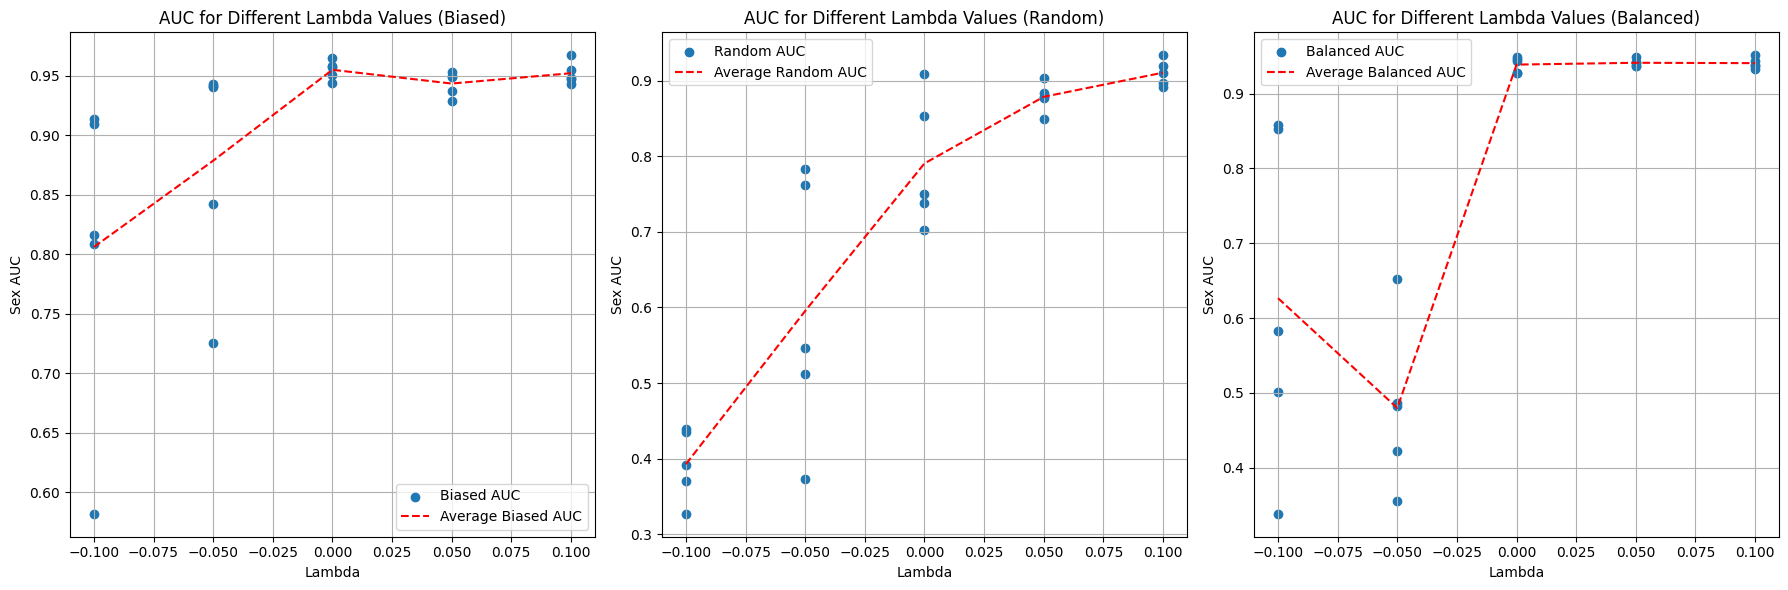

In [29]:
import matplotlib.pyplot as plt

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Filter the DataFrame for biased, balanced, and random data
biased_data = predictions[predictions['Dataset'] == 'Biased']
random_data = predictions[predictions['Dataset'] == 'Random']
balanced_data = predictions[predictions['Dataset'] == 'Balanced']

# Calculate average AUC for each lambda
average_auc_biased = biased_data.groupby('Lambda')['Sex AUC'].mean()
average_auc_random = random_data.groupby('Lambda')['Sex AUC'].mean()
average_auc_balanced = balanced_data.groupby('Lambda')['Sex AUC'].mean()

# Plot for biased data
axes[0].scatter(biased_data['Lambda'], biased_data['Sex AUC'], marker='o', label='Biased AUC')
axes[0].plot(average_auc_biased.index, average_auc_biased.values, color='red', linestyle='--', label='Average Biased AUC')
axes[0].set_title('AUC for Different Lambda Values (Biased)')
axes[0].set_xlabel('Lambda')
axes[0].set_ylabel('Sex AUC')
axes[0].grid(True)
axes[0].legend()

# Plot for random data
axes[1].scatter(random_data['Lambda'], random_data['Sex AUC'], marker='o', label='Random AUC')
axes[1].plot(average_auc_random.index, average_auc_random.values, color='red', linestyle='--', label='Average Random AUC')
axes[1].set_title('AUC for Different Lambda Values (Random)')
axes[1].set_xlabel('Lambda')
axes[1].set_ylabel('Sex AUC')
axes[1].grid(True)
axes[1].legend()

# Plot for balanced data
axes[2].scatter(balanced_data['Lambda'], balanced_data['Sex AUC'], marker='o', label='Balanced AUC')
axes[2].plot(average_auc_balanced.index, average_auc_balanced.values, color='red', linestyle='--', label='Average Balanced AUC')
axes[2].set_title('AUC for Different Lambda Values (Balanced)')
axes[2].set_xlabel('Lambda')
axes[2].set_ylabel('Sex AUC')
axes[2].grid(True)
axes[2].legend()

plt.tight_layout()
plt.show()

In [40]:
from scipy.stats import pearsonr, spearmanr

pearson_corr, pearson_p_value = pearsonr(predictions['AUC'], predictions['Equalized Odds Ratio'])
print("Pearson correlation coefficient:", pearson_corr)
print("Pearson p-value:", pearson_p_value)

spearman_corr, spearman_p_value = spearmanr(predictions['AUC'], predictions['Equalized Odds Ratio'])
print("Spearman correlation coefficient:", spearman_corr)
print("Spearman p-value:", spearman_p_value)

Pearson correlation coefficient: 0.4760291102607793
Pearson p-value: 1.5844885627446846e-05
Spearman correlation coefficient: 0.4549075391180654
Spearman p-value: 4.126483281954035e-05


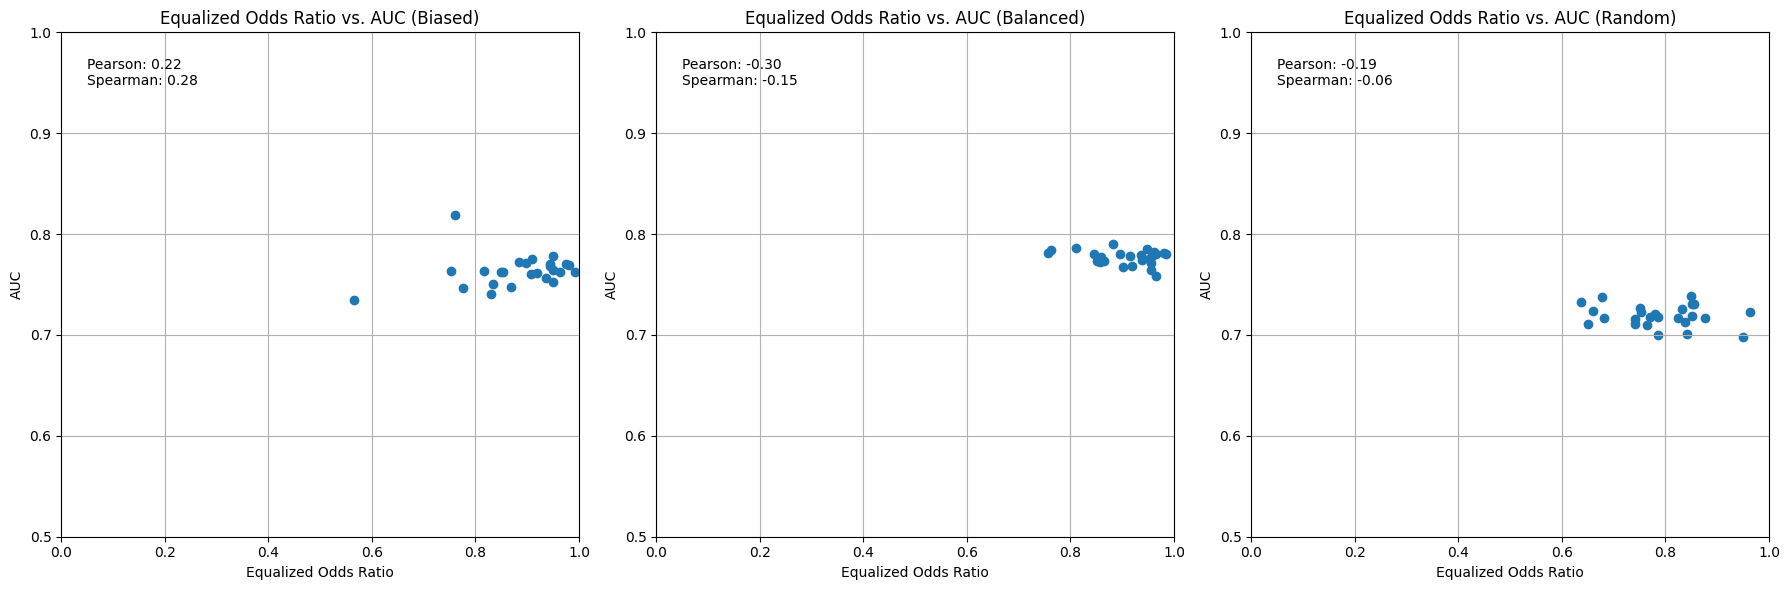

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

biased_data = predictions[predictions['Dataset'] == 'Biased']
balanced_data = predictions[predictions['Dataset'] == 'Balanced']
random_data = predictions[predictions['Dataset'] == 'Random']

def annotate_correlations(x, y, ax):
    pearson_corr, _ = pearsonr(x, y)
    spearman_corr, _ = spearmanr(x, y)
    ax.text(0.05, 0.95, f'Pearson: {pearson_corr:.2f}\nSpearman: {spearman_corr:.2f}', 
            transform=ax.transAxes, ha='left', va='top', fontsize=10)

axes[0].scatter(biased_data['Equalized Odds Ratio'], biased_data['AUC'], marker='o')
axes[0].set_title('Equalized Odds Ratio vs. AUC (Biased)')
axes[0].set_ylabel('AUC')
axes[0].set_xlabel('Equalized Odds Ratio')
axes[0].grid(True)
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0.5, 1])
annotate_correlations(biased_data['AUC'], biased_data['Equalized Odds Ratio'], axes[0])

axes[1].scatter(balanced_data['Equalized Odds Ratio'], balanced_data['AUC'], marker='o')
axes[1].set_title('Equalized Odds Ratio vs. AUC (Balanced)')
axes[1].set_ylabel('AUC')
axes[1].set_xlabel('Equalized Odds Ratio')
axes[1].grid(True)
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0.5, 1])
annotate_correlations(balanced_data['AUC'], balanced_data['Equalized Odds Ratio'], axes[1])

axes[2].scatter(random_data['Equalized Odds Ratio'], random_data['AUC'], marker='o')
axes[2].set_title('Equalized Odds Ratio vs. AUC (Random)')
axes[2].set_ylabel('AUC')
axes[2].set_xlabel('Equalized Odds Ratio')
axes[2].grid(True)
axes[2].set_xlim([0, 1])
axes[2].set_ylim([0.5, 1])
annotate_correlations(random_data['AUC'], random_data['Equalized Odds Ratio'], axes[2])
plt.tight_layout()
plt.show()

In [25]:
from scipy.stats import pearsonr, spearmanr

pearson_corr, pearson_p_value = pearsonr(predictions['AUC'], predictions['Equalized Odds Ratio'])
print("Pearson correlation coefficient:", pearson_corr)
print("Pearson p-value:", pearson_p_value)

spearman_corr, spearman_p_value = spearmanr(predictions['AUC'], predictions['Equalized Odds Ratio'])
print("Spearman correlation coefficient:", spearman_corr)
print("Spearman p-value:", spearman_p_value)

Pearson correlation coefficient: 0.4760291102607793
Pearson p-value: 1.5844885627446846e-05
Spearman correlation coefficient: 0.4549075391180654
Spearman p-value: 4.126483281954035e-05


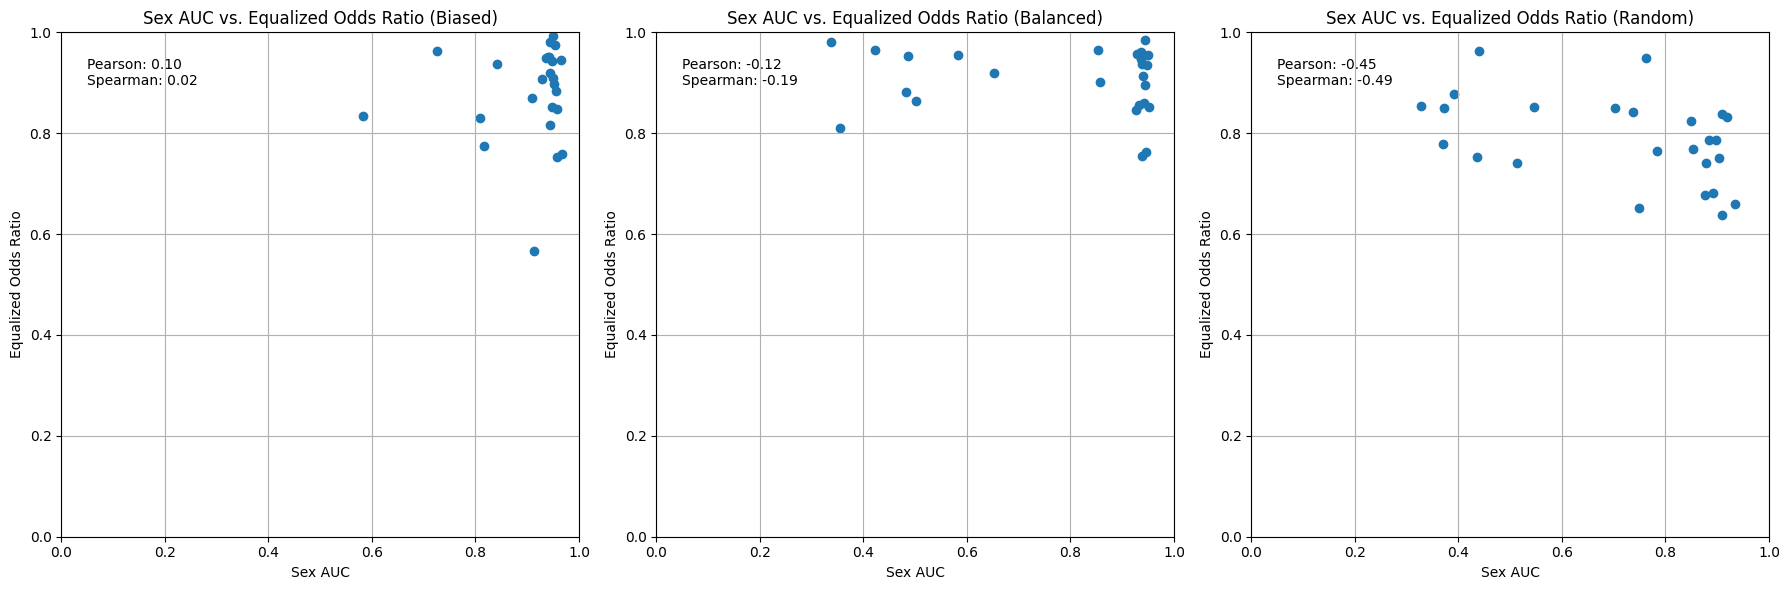

In [26]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

biased_data = predictions[predictions['Dataset'] == 'Biased']
balanced_data = predictions[predictions['Dataset'] == 'Balanced']
random_data = predictions[predictions['Dataset'] == 'Random']

def annotate_correlations(x, y, ax):
    pearson_corr, _ = pearsonr(x, y)
    spearman_corr, _ = spearmanr(x, y)
    ax.text(0.05, 0.95, f'Pearson: {pearson_corr:.2f}\nSpearman: {spearman_corr:.2f}', 
            transform=ax.transAxes, ha='left', va='top', fontsize=10)

axes[0].scatter(biased_data['Sex AUC'], biased_data['Equalized Odds Ratio'], marker='o')
axes[0].set_title('Sex AUC vs. Equalized Odds Ratio (Biased)')
axes[0].set_xlabel('Sex AUC')
axes[0].set_ylabel('Equalized Odds Ratio')
axes[0].grid(True)
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
annotate_correlations(biased_data['Sex AUC'], biased_data['Equalized Odds Ratio'], axes[0])

axes[1].scatter(balanced_data['Sex AUC'], balanced_data['Equalized Odds Ratio'], marker='o')
axes[1].set_title('Sex AUC vs. Equalized Odds Ratio (Balanced)')
axes[1].set_xlabel('Sex AUC')
axes[1].set_ylabel('Equalized Odds Ratio')
axes[1].grid(True)
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
annotate_correlations(balanced_data['Sex AUC'], balanced_data['Equalized Odds Ratio'], axes[1])

axes[2].scatter(random_data['Sex AUC'], random_data['Equalized Odds Ratio'], marker='o')
axes[2].set_title('Sex AUC vs. Equalized Odds Ratio (Random)')
axes[2].set_xlabel('Sex AUC')
axes[2].set_ylabel('Equalized Odds Ratio')
axes[2].grid(True)
axes[2].set_xlim([0, 1])
axes[2].set_ylim([0, 1])
annotate_correlations(random_data['Sex AUC'], random_data['Equalized Odds Ratio'], axes[2])

plt.tight_layout()
plt.show()


## Sex Predictions

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

predictions = pd.read_csv('../shortcuts-chest-xray/Prediction_analysis_sex.csv')

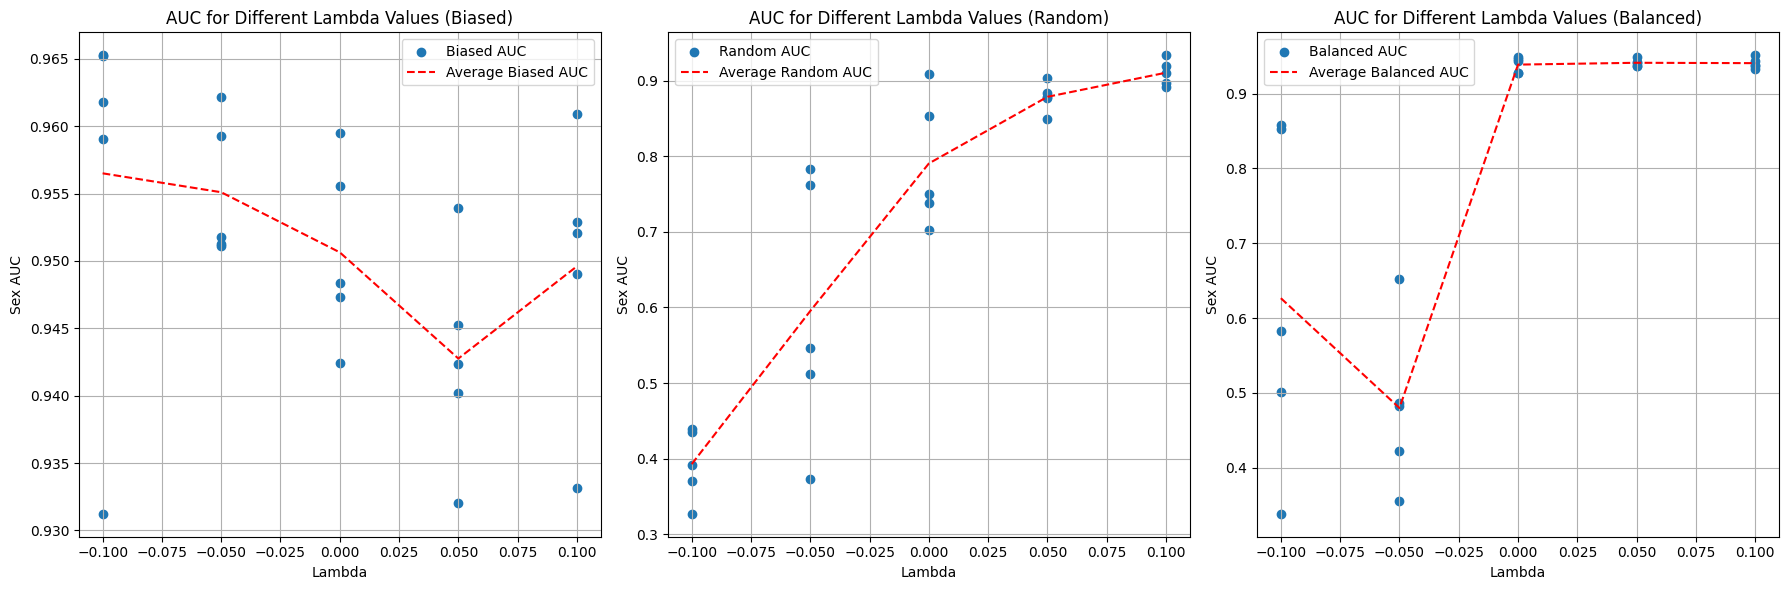

In [4]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Filter the DataFrame for biased, balanced, and random data
biased_data = predictions[predictions['Dataset'] == 'BiasedPneumothorax']
random_data = predictions[predictions['Dataset'] == 'Random']
balanced_data = predictions[predictions['Dataset'] == 'Balanced']

# Calculate average AUC for each lambda
average_auc_biased = biased_data.groupby('Lambda')['Sex AUC'].mean()
average_auc_random = random_data.groupby('Lambda')['Sex AUC'].mean()
average_auc_balanced = balanced_data.groupby('Lambda')['Sex AUC'].mean()

# Plot for biased data
axes[0].scatter(biased_data['Lambda'], biased_data['Sex AUC'], marker='o', label='Biased AUC')
axes[0].plot(average_auc_biased.index, average_auc_biased.values, color='red', linestyle='--', label='Average Biased AUC')
axes[0].set_title('AUC for Different Lambda Values (Biased)')
axes[0].set_xlabel('Lambda')
axes[0].set_ylabel('Sex AUC')
axes[0].grid(True)
axes[0].legend()

# Plot for random data
axes[1].scatter(random_data['Lambda'], random_data['Sex AUC'], marker='o', label='Random AUC')
axes[1].plot(average_auc_random.index, average_auc_random.values, color='red', linestyle='--', label='Average Random AUC')
axes[1].set_title('AUC for Different Lambda Values (Random)')
axes[1].set_xlabel('Lambda')
axes[1].set_ylabel('Sex AUC')
axes[1].grid(True)
axes[1].legend()

# Plot for balanced data
axes[2].scatter(balanced_data['Lambda'], balanced_data['Sex AUC'], marker='o', label='Balanced AUC')
axes[2].plot(average_auc_balanced.index, average_auc_balanced.values, color='red', linestyle='--', label='Average Balanced AUC')
axes[2].set_title('AUC for Different Lambda Values (Balanced)')
axes[2].set_xlabel('Lambda')
axes[2].set_ylabel('Sex AUC')
axes[2].grid(True)
axes[2].legend()

plt.tight_layout()
plt.show()

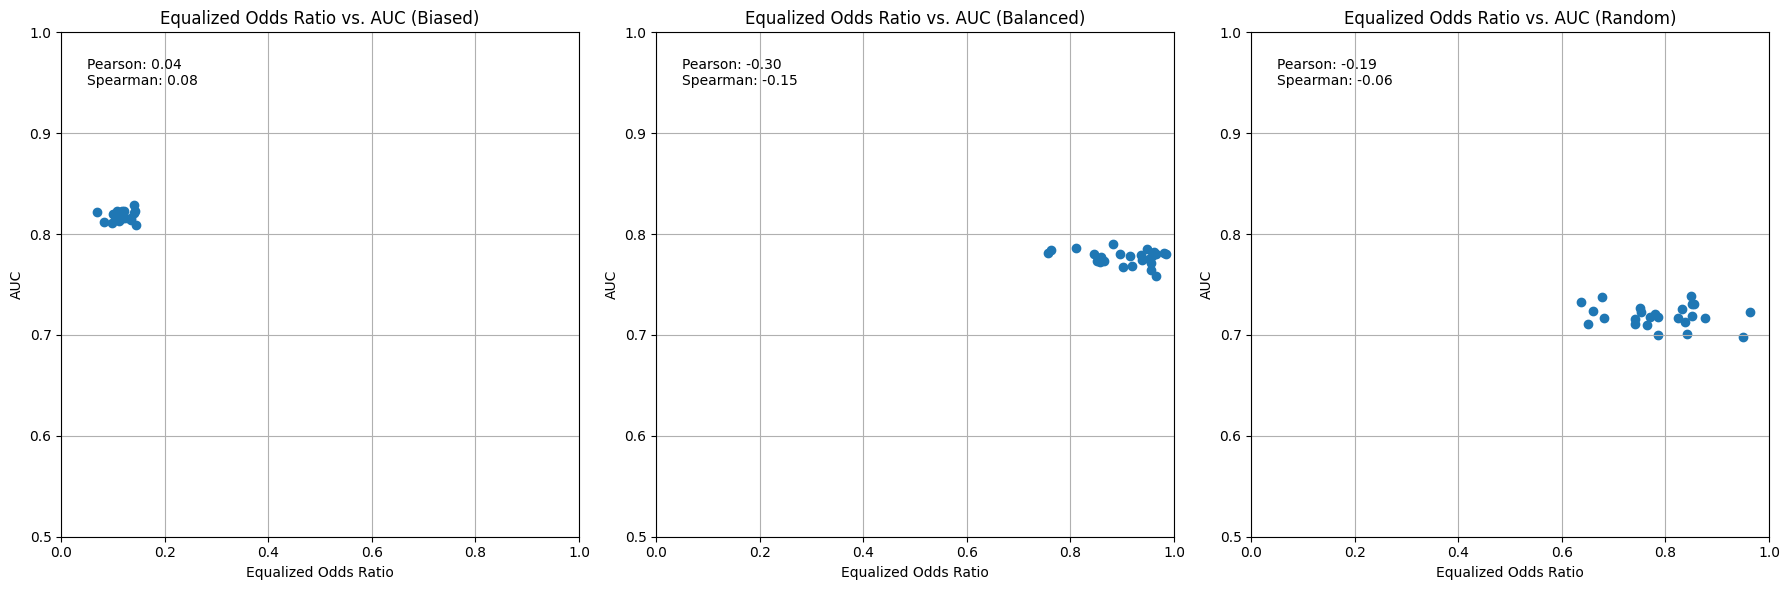

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

biased_data = predictions[predictions['Dataset'] == 'BiasedPneumothorax']
balanced_data = predictions[predictions['Dataset'] == 'Balanced']
random_data = predictions[predictions['Dataset'] == 'Random']

def annotate_correlations(x, y, ax):
    pearson_corr, _ = pearsonr(x, y)
    spearman_corr, _ = spearmanr(x, y)
    ax.text(0.05, 0.95, f'Pearson: {pearson_corr:.2f}\nSpearman: {spearman_corr:.2f}', 
            transform=ax.transAxes, ha='left', va='top', fontsize=10)

axes[0].scatter(biased_data['Equalized Odds Ratio'], biased_data['AUC'], marker='o')
axes[0].set_title('Equalized Odds Ratio vs. AUC (Biased)')
axes[0].set_ylabel('AUC')
axes[0].set_xlabel('Equalized Odds Ratio')
axes[0].grid(True)
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0.5, 1])
annotate_correlations(biased_data['AUC'], biased_data['Equalized Odds Ratio'], axes[0])

axes[1].scatter(balanced_data['Equalized Odds Ratio'], balanced_data['AUC'], marker='o')
axes[1].set_title('Equalized Odds Ratio vs. AUC (Balanced)')
axes[1].set_ylabel('AUC')
axes[1].set_xlabel('Equalized Odds Ratio')
axes[1].grid(True)
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0.5, 1])
annotate_correlations(balanced_data['AUC'], balanced_data['Equalized Odds Ratio'], axes[1])

axes[2].scatter(random_data['Equalized Odds Ratio'], random_data['AUC'], marker='o')
axes[2].set_title('Equalized Odds Ratio vs. AUC (Random)')
axes[2].set_ylabel('AUC')
axes[2].set_xlabel('Equalized Odds Ratio')
axes[2].grid(True)
axes[2].set_xlim([0, 1])
axes[2].set_ylim([0.5, 1])
annotate_correlations(random_data['AUC'], random_data['Equalized Odds Ratio'], axes[2])
plt.tight_layout()
plt.show()

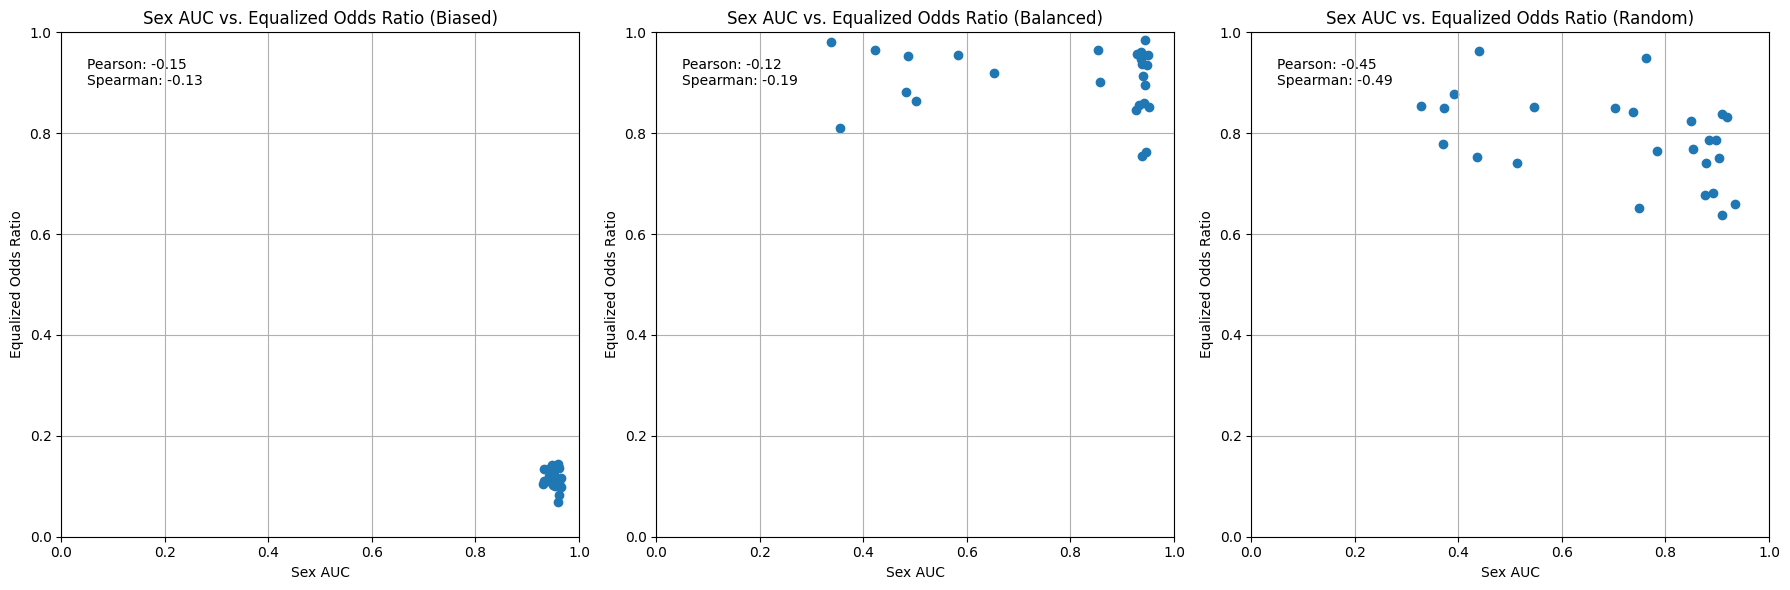

In [6]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

biased_data = predictions[predictions['Dataset'] == 'BiasedPneumothorax']
balanced_data = predictions[predictions['Dataset'] == 'Balanced']
random_data = predictions[predictions['Dataset'] == 'Random']

def annotate_correlations(x, y, ax):
    pearson_corr, _ = pearsonr(x, y)
    spearman_corr, _ = spearmanr(x, y)
    ax.text(0.05, 0.95, f'Pearson: {pearson_corr:.2f}\nSpearman: {spearman_corr:.2f}', 
            transform=ax.transAxes, ha='left', va='top', fontsize=10)

axes[0].scatter(biased_data['Sex AUC'], biased_data['Equalized Odds Ratio'], marker='o')
axes[0].set_title('Sex AUC vs. Equalized Odds Ratio (Biased)')
axes[0].set_xlabel('Sex AUC')
axes[0].set_ylabel('Equalized Odds Ratio')
axes[0].grid(True)
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
annotate_correlations(biased_data['Sex AUC'], biased_data['Equalized Odds Ratio'], axes[0])

axes[1].scatter(balanced_data['Sex AUC'], balanced_data['Equalized Odds Ratio'], marker='o')
axes[1].set_title('Sex AUC vs. Equalized Odds Ratio (Balanced)')
axes[1].set_xlabel('Sex AUC')
axes[1].set_ylabel('Equalized Odds Ratio')
axes[1].grid(True)
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
annotate_correlations(balanced_data['Sex AUC'], balanced_data['Equalized Odds Ratio'], axes[1])

axes[2].scatter(random_data['Sex AUC'], random_data['Equalized Odds Ratio'], marker='o')
axes[2].set_title('Sex AUC vs. Equalized Odds Ratio (Random)')
axes[2].set_xlabel('Sex AUC')
axes[2].set_ylabel('Equalized Odds Ratio')
axes[2].grid(True)
axes[2].set_xlim([0, 1])
axes[2].set_ylim([0, 1])
annotate_correlations(random_data['Sex AUC'], random_data['Equalized Odds Ratio'], axes[2])

plt.tight_layout()
plt.show()


## All Sex Predictions

In [118]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

train_datasets = ["Random", "Balanced", "Biased"]
test_datasets = ["Random", "Balanced", "Biased"]

data = pd.read_csv('../shortcuts-chest-xray/testing/Prediction_analysis_sex.csv')

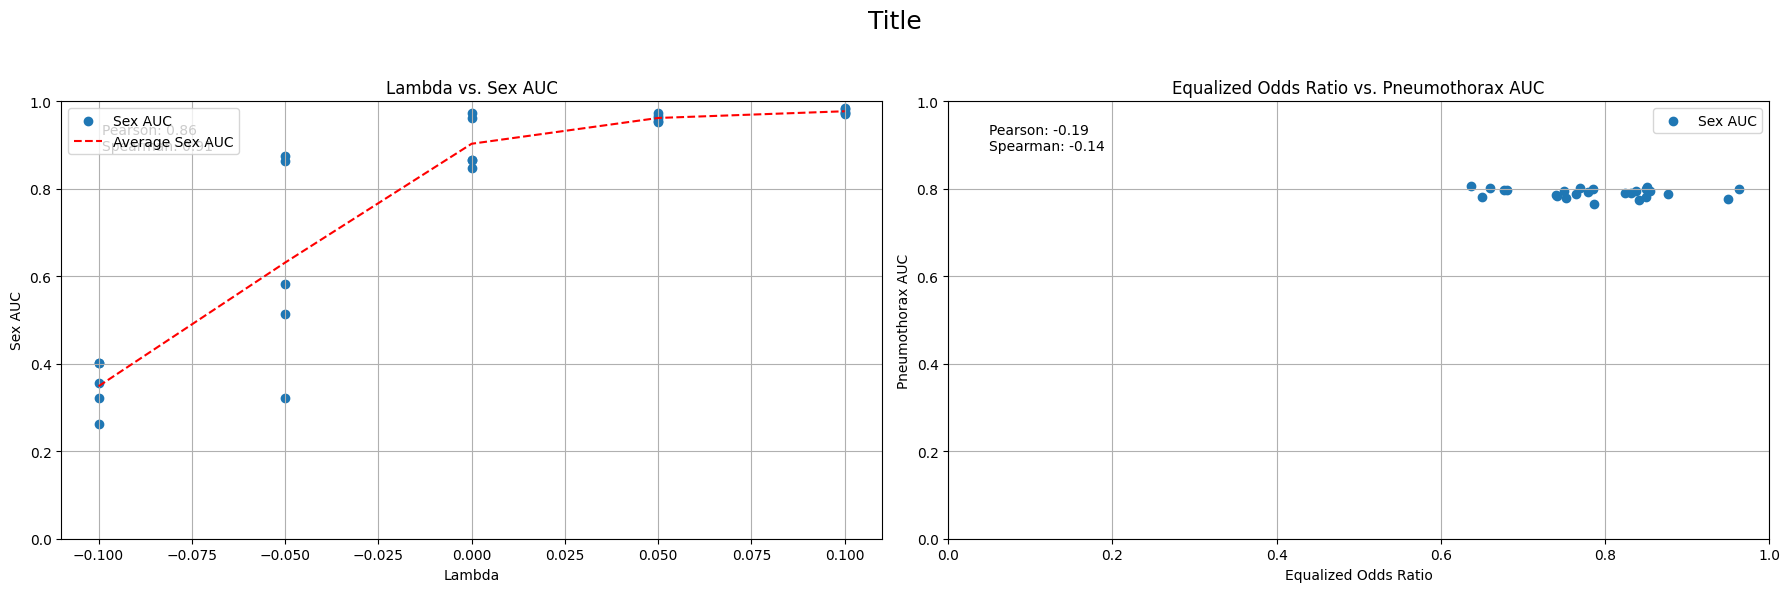

In [98]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

data = pd.read_csv('../shortcuts-chest-xray/testing/Prediction_analysis_sex.csv')
data = data[(data['TrainDataset'] == "Random") & (data['TestDataset'] == "Random")]

average_auc = data.groupby('Lambda')['Sex AUC'].mean()
average_sens_auc = data.groupby('Lambda')['Sex AUC'].mean()
fairness_score = data['Equalized Odds Ratio'].mean()

axes[0].scatter(data['Lambda'], data['Sex AUC'], marker='o', label='Sex AUC')
axes[0].plot(average_auc.index, average_auc.values, color='red', linestyle='--', label='Average Sex AUC')
axes[0].set_title(f'Lambda vs. Sex AUC')
axes[0].set_xlabel('Lambda')
axes[0].set_ylabel('Sex AUC')
axes[0].set_ylim([0, 1])
axes[0].grid(True)
axes[0].legend()

axes[1].scatter(data['Equalized Odds Ratio'], data['AUC'], marker='o', label='Sex AUC')
axes[1].set_title(f'Equalized Odds Ratio vs. Pneumothorax AUC')
axes[1].set_xlabel('Equalized Odds Ratio')
axes[1].set_ylabel('Pneumothorax AUC')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].grid(True)
axes[1].legend()



fig.suptitle('Title\n', fontsize=18)
plt.tight_layout()
plt.show()


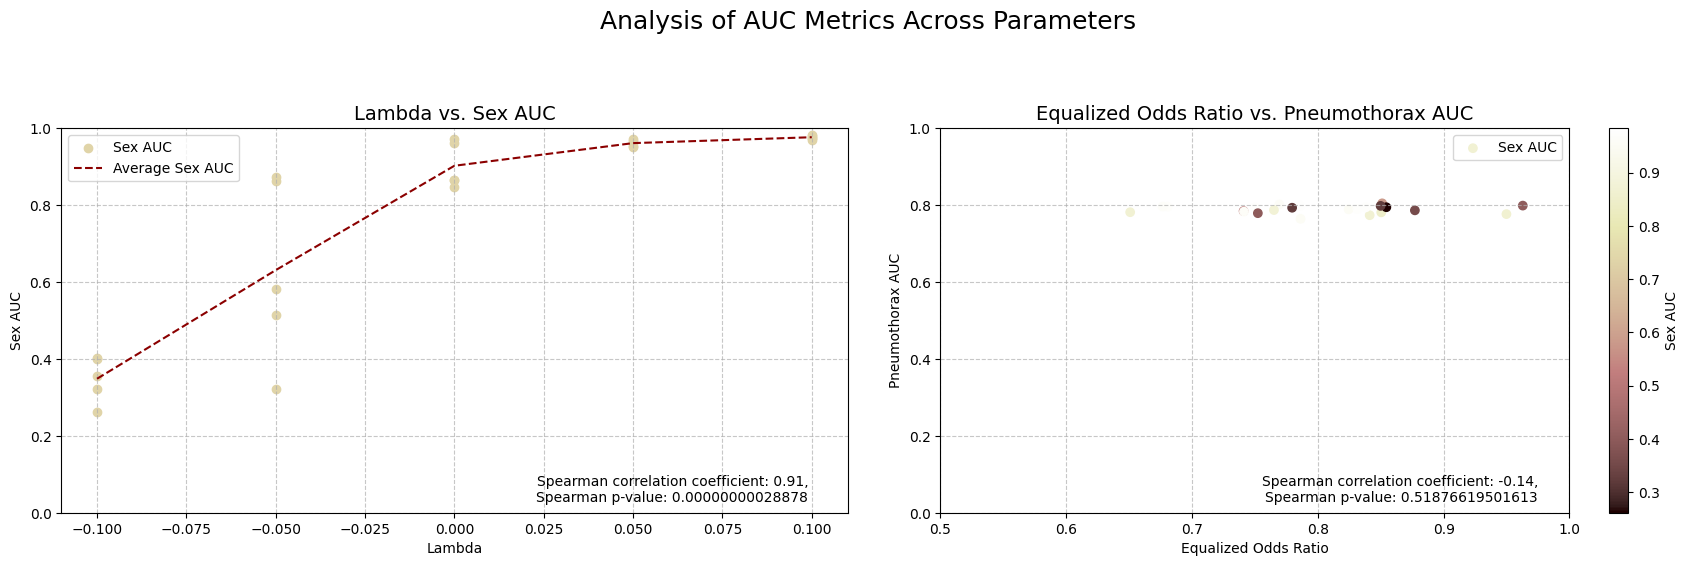

In [116]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import spearmanr

data = pd.read_csv('../shortcuts-chest-xray/testing/Prediction_analysis_sex.csv')
data = data[(data['TrainDataset'] == "Random") & (data['TestDataset'] == "Random")]


def annotate_correlations(x, y, ax):
    spearman_corr, spearman_p_value = spearmanr(x, y)
    ax.text(0.95, 0.1, f'Spearman correlation coefficient: {spearman_corr:.2f},\nSpearman p-value: {spearman_p_value:.14f}', 
            transform=ax.transAxes, ha='right', va='top', fontsize=10)


# Define pinkish palette
colors = plt.cm.pink(np.linspace(0.3, 1, num=100))

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1
average_auc = data.groupby('Lambda')['Sex AUC'].mean()
axes[0].scatter(data['Lambda'], data['Sex AUC'], color=colors[50], marker='o', label='Sex AUC')
axes[0].plot(average_auc.index, average_auc.values, color='darkred', linestyle='--', label='Average Sex AUC')
axes[0].set_title('Lambda vs. Sex AUC', fontsize=14)
axes[0].set_xlabel('Lambda')
axes[0].set_ylabel('Sex AUC')
axes[0].set_ylim([0, 1])
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].legend()
annotate_correlations(data['Lambda'], data['Sex AUC'], axes[0])

# Plot 2
sc = axes[1].scatter(data['Equalized Odds Ratio'], data['AUC'], c=data['Sex AUC'], cmap='pink', marker='o', label='Sex AUC')
cbar = plt.colorbar(sc, ax=axes[1], orientation='vertical')
cbar.set_label('Sex AUC')
axes[1].set_title('Equalized Odds Ratio vs. Pneumothorax AUC', fontsize=14)
axes[1].set_xlabel('Equalized Odds Ratio')
axes[1].set_ylabel('Pneumothorax AUC')
axes[1].set_xlim([0.5, 1])
axes[1].set_ylim([0, 1])
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].legend()
annotate_correlations(data['Equalized Odds Ratio'], data['AUC'], axes[1])

# Overall adjustments
fig.suptitle('Analysis of AUC Metrics Across Parameters', fontsize=18)
plt.tight_layout(pad=3)
plt.show()

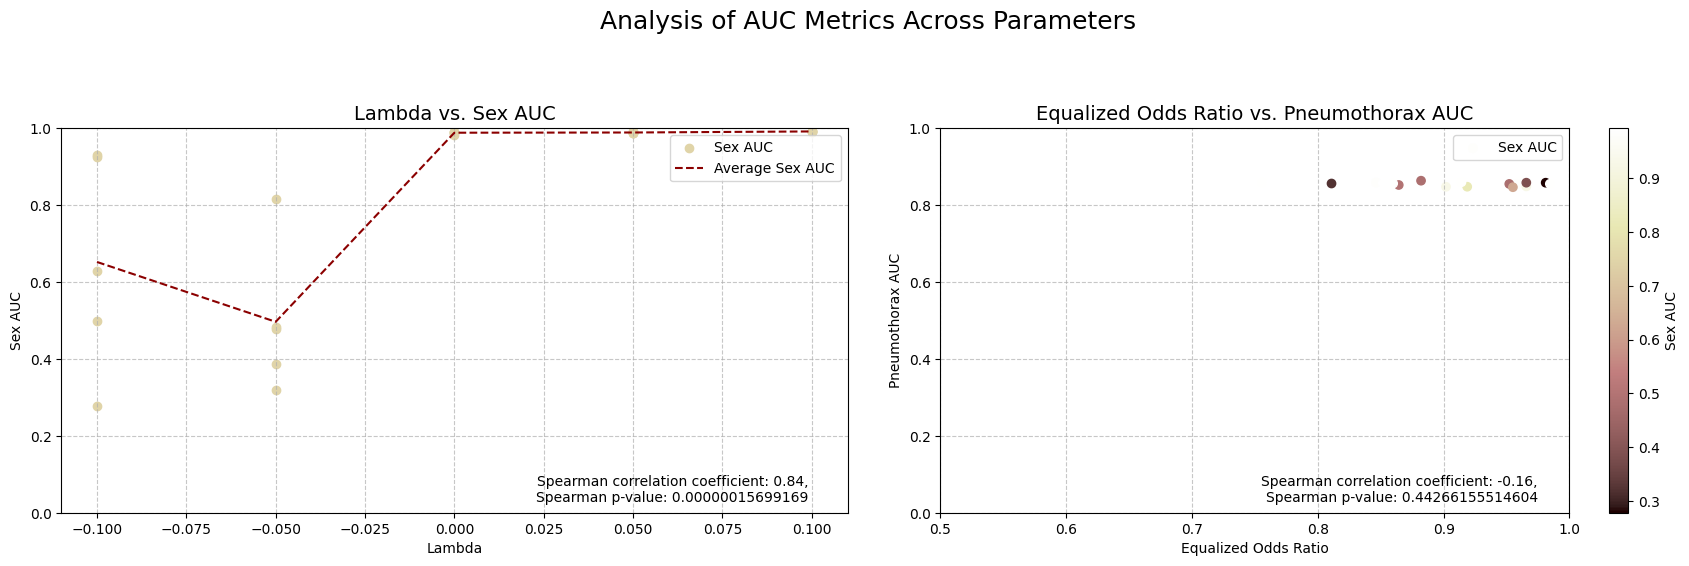

In [119]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import spearmanr

data = pd.read_csv('../shortcuts-chest-xray/testing/Prediction_analysis_sex.csv')
data = data[(data['TrainDataset'] == "Balanced") & (data['TestDataset'] == "Balanced")]

def annotate_correlations(x, y, ax):
    spearman_corr, spearman_p_value = spearmanr(x, y)
    ax.text(0.95, 0.1, f'Spearman correlation coefficient: {spearman_corr:.2f},\nSpearman p-value: {spearman_p_value:.14f}', 
            transform=ax.transAxes, ha='right', va='top', fontsize=10)


# Define pinkish palette
colors = plt.cm.pink(np.linspace(0.3, 1, num=100))

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1
average_auc = data.groupby('Lambda')['Sex AUC'].mean()
axes[0].scatter(data['Lambda'], data['Sex AUC'], color=colors[50], marker='o', label='Sex AUC')
axes[0].plot(average_auc.index, average_auc.values, color='darkred', linestyle='--', label='Average Sex AUC')
axes[0].set_title('Lambda vs. Sex AUC', fontsize=14)
axes[0].set_xlabel('Lambda')
axes[0].set_ylabel('Sex AUC')
axes[0].set_ylim([0, 1])
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].legend()
annotate_correlations(data['Lambda'], data['Sex AUC'], axes[0])

# Plot 2
sc = axes[1].scatter(data['Equalized Odds Ratio'], data['AUC'], c=data['Sex AUC'], cmap='pink', marker='o', label='Sex AUC')
cbar = plt.colorbar(sc, ax=axes[1], orientation='vertical')
cbar.set_label('Sex AUC')
axes[1].set_title('Equalized Odds Ratio vs. Pneumothorax AUC', fontsize=14)
axes[1].set_xlabel('Equalized Odds Ratio')
axes[1].set_ylabel('Pneumothorax AUC')
axes[1].set_xlim([0.5, 1])
axes[1].set_ylim([0, 1])
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].legend()
annotate_correlations(data['Equalized Odds Ratio'], data['AUC'], axes[1])

# Overall adjustments
fig.suptitle('Analysis of AUC Metrics Across Parameters', fontsize=18)
plt.tight_layout(pad=3)
plt.show()

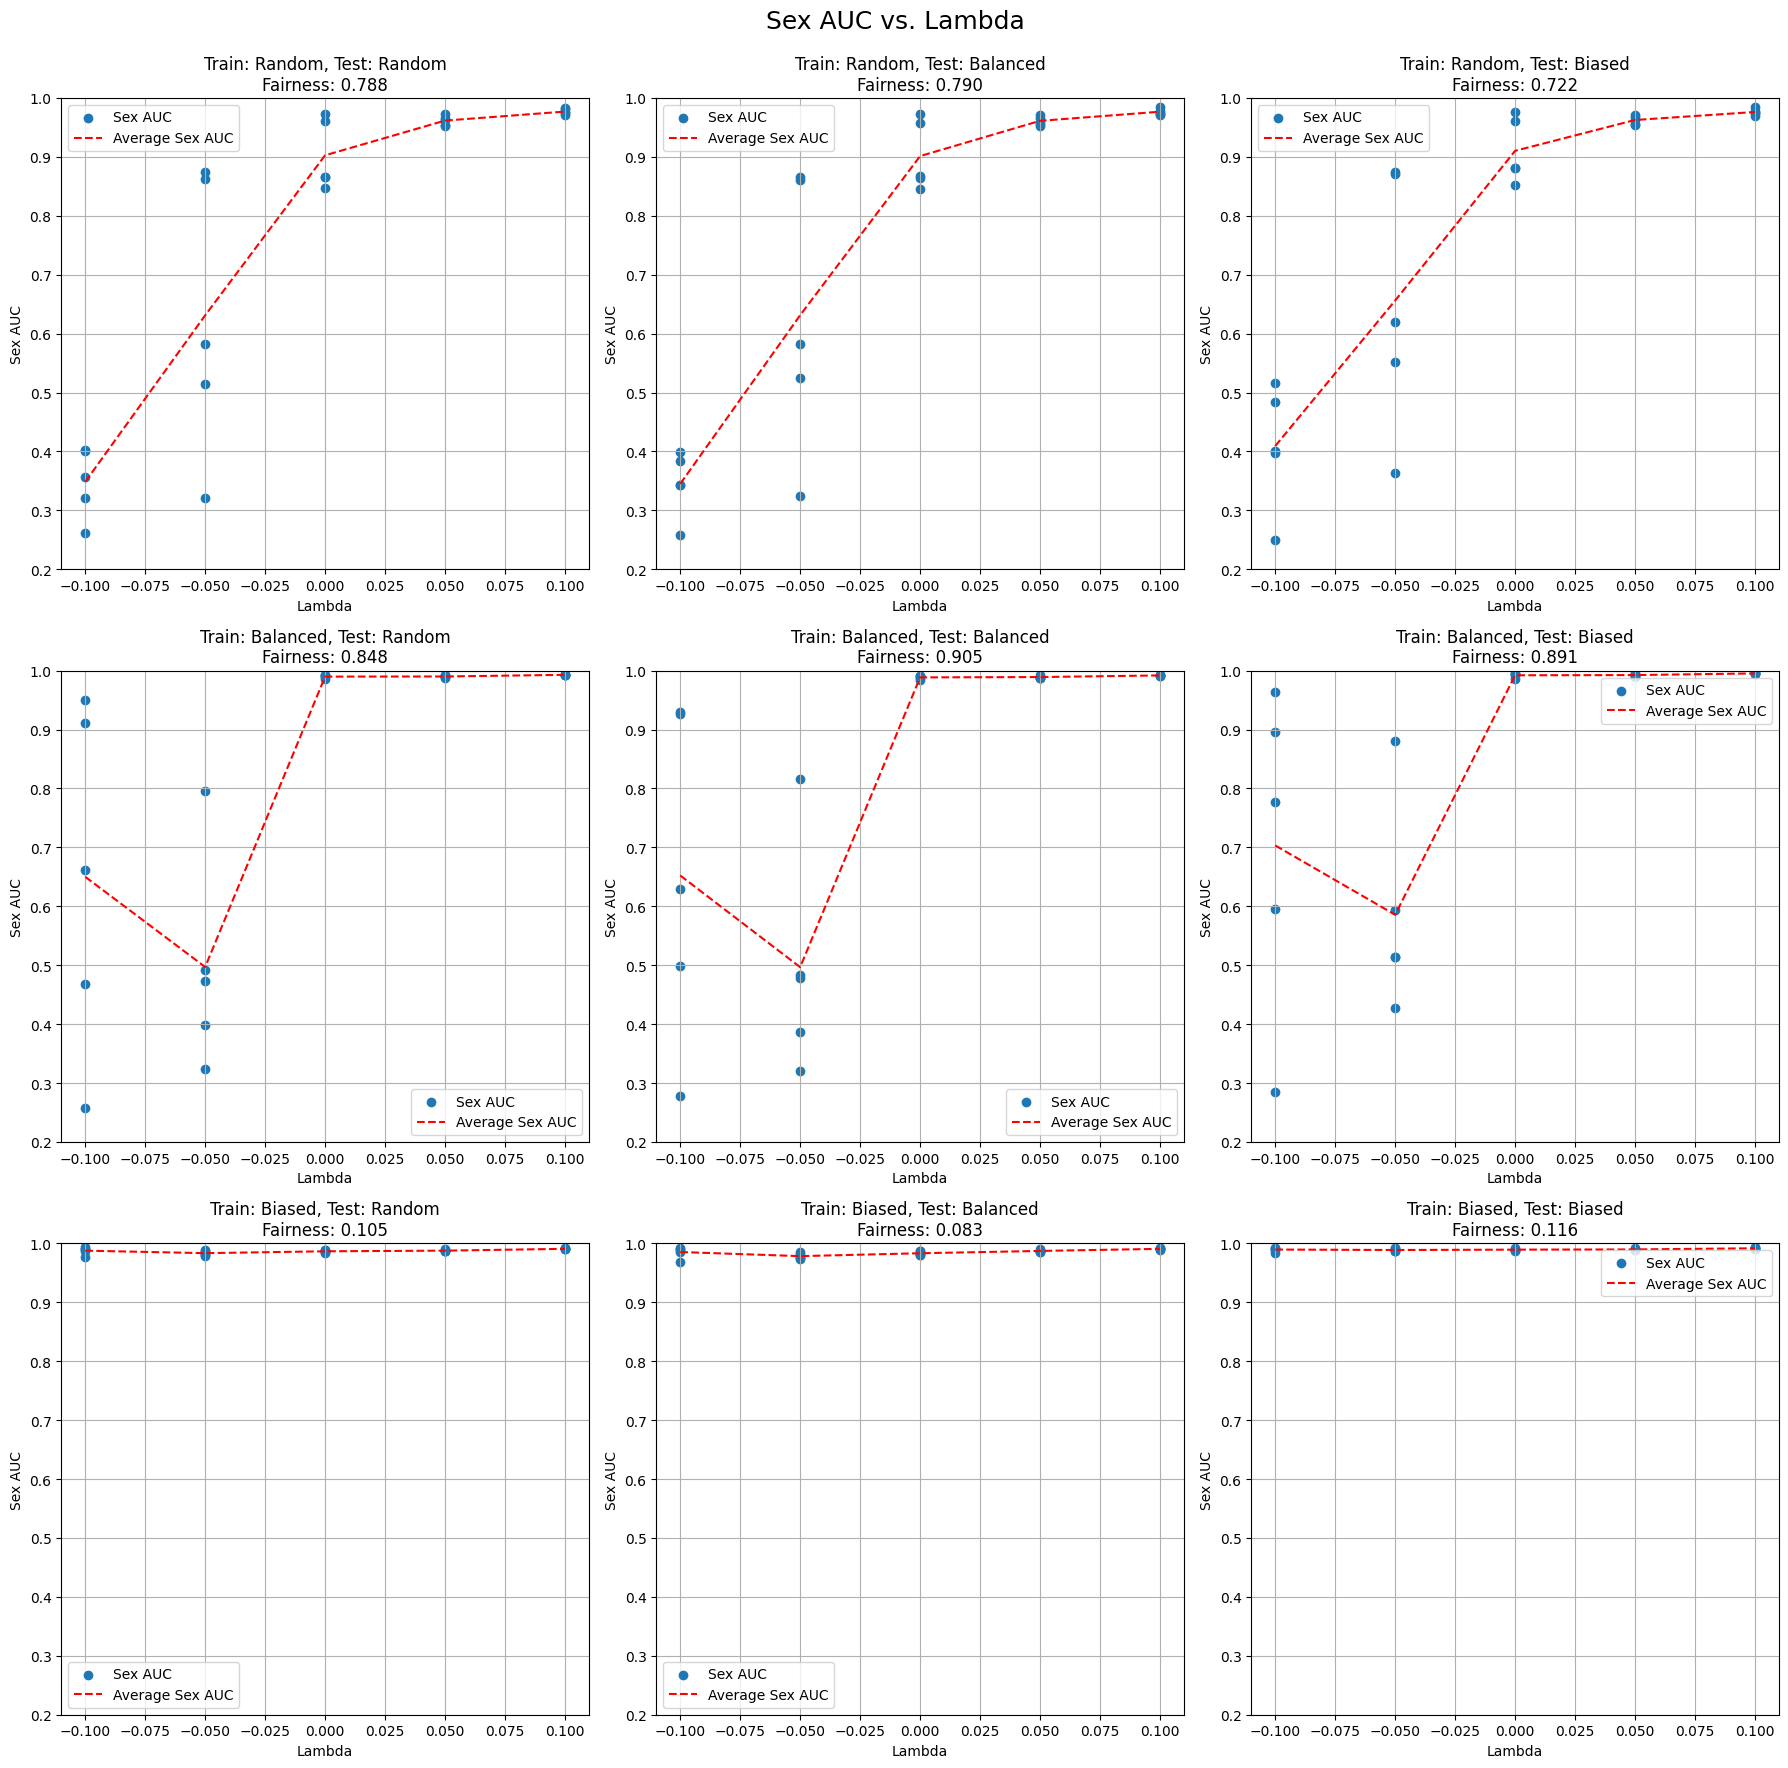

In [71]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))

for i, train_dataset in enumerate(train_datasets):
    for j, test_dataset in enumerate(test_datasets):
        filtered_data = data[(data['TrainDataset'] == train_dataset) & (data['TestDataset'] == test_dataset)]
        average_auc = filtered_data.groupby('Lambda')['Sex AUC'].mean()
        fairness_score = filtered_data['Equalized Odds Ratio'].mean()

        axes[i, j].scatter(filtered_data['Lambda'], filtered_data['Sex AUC'], marker='o', label='Sex AUC')
        axes[i, j].plot(average_auc.index, average_auc.values, color='red', linestyle='--', label='Average Sex AUC')
        axes[i, j].set_title(f'Train: {train_dataset}, Test: {test_dataset}\nFairness: {fairness_score:.3f}')
        axes[i, j].set_xlabel('Lambda')
        axes[i, j].set_ylabel('Sex AUC')
        axes[i, j].set_ylim([0.2, 1])
        axes[i, j].grid(True)
        axes[i, j].legend()

fig.suptitle('Sex AUC vs. Lambda\n', fontsize=18)
plt.tight_layout()
plt.show()


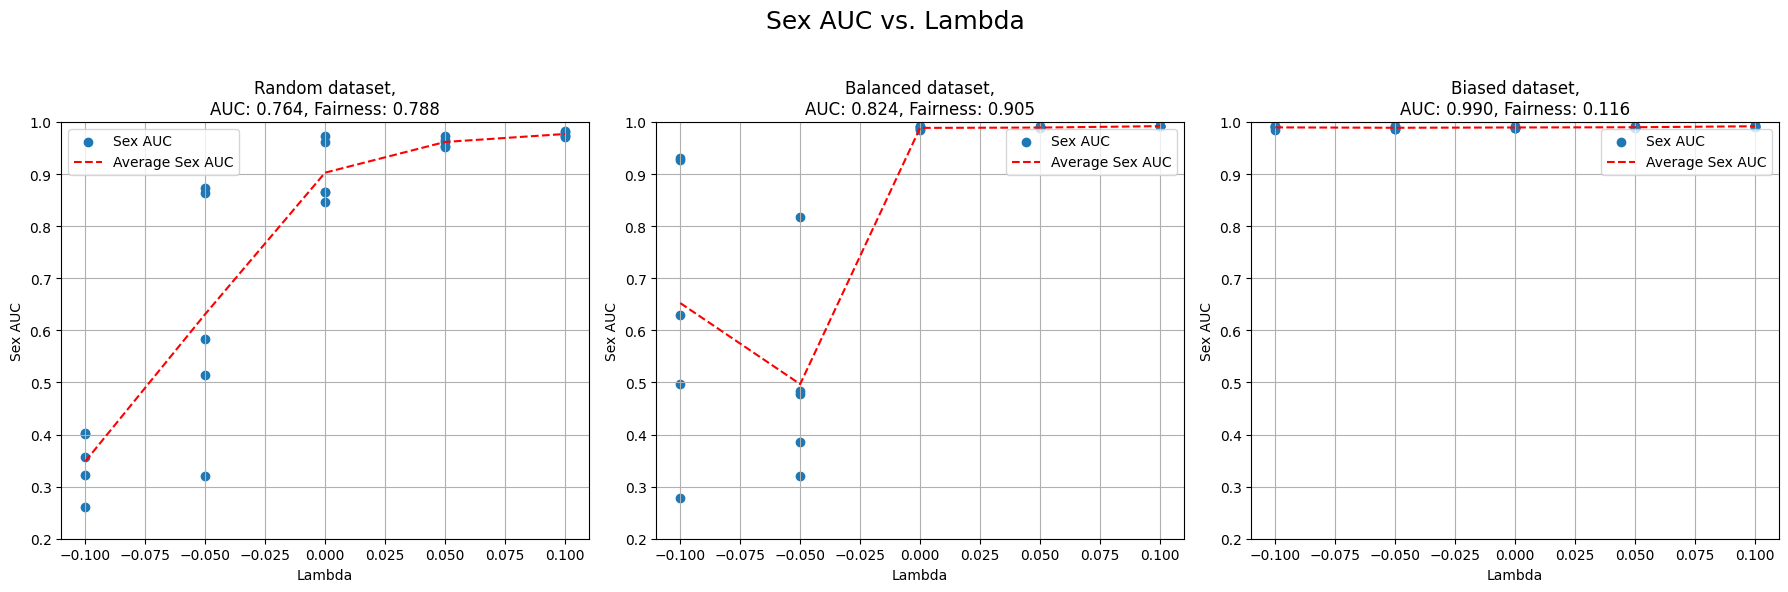

In [72]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, train_dataset in enumerate(train_datasets):
    filtered_data = data[(data['TrainDataset'] == train_dataset) & (data['TestDataset'] == train_dataset)]
    average_auc = filtered_data.groupby('Lambda')['Sex AUC'].mean()
    sex_auc_score = filtered_data['Sex AUC'].mean()
    fairness_score = filtered_data['Equalized Odds Ratio'].mean()

    axes[i].scatter(filtered_data['Lambda'], filtered_data['Sex AUC'], marker='o', label='Sex AUC')
    axes[i].plot(average_auc.index, average_auc.values, color='red', linestyle='--', label='Average Sex AUC')
    axes[i].set_title(f'{train_dataset} dataset,\nAUC: {sex_auc_score:.3f}, Fairness: {fairness_score:.3f}')
    axes[i].set_xlabel('Lambda')
    axes[i].set_ylabel('Sex AUC')
    axes[i].set_ylim([0.2, 1])
    axes[i].grid(True)
    axes[i].legend()

fig.suptitle('Sex AUC vs. Lambda\n', fontsize=18)
plt.tight_layout()
plt.show()


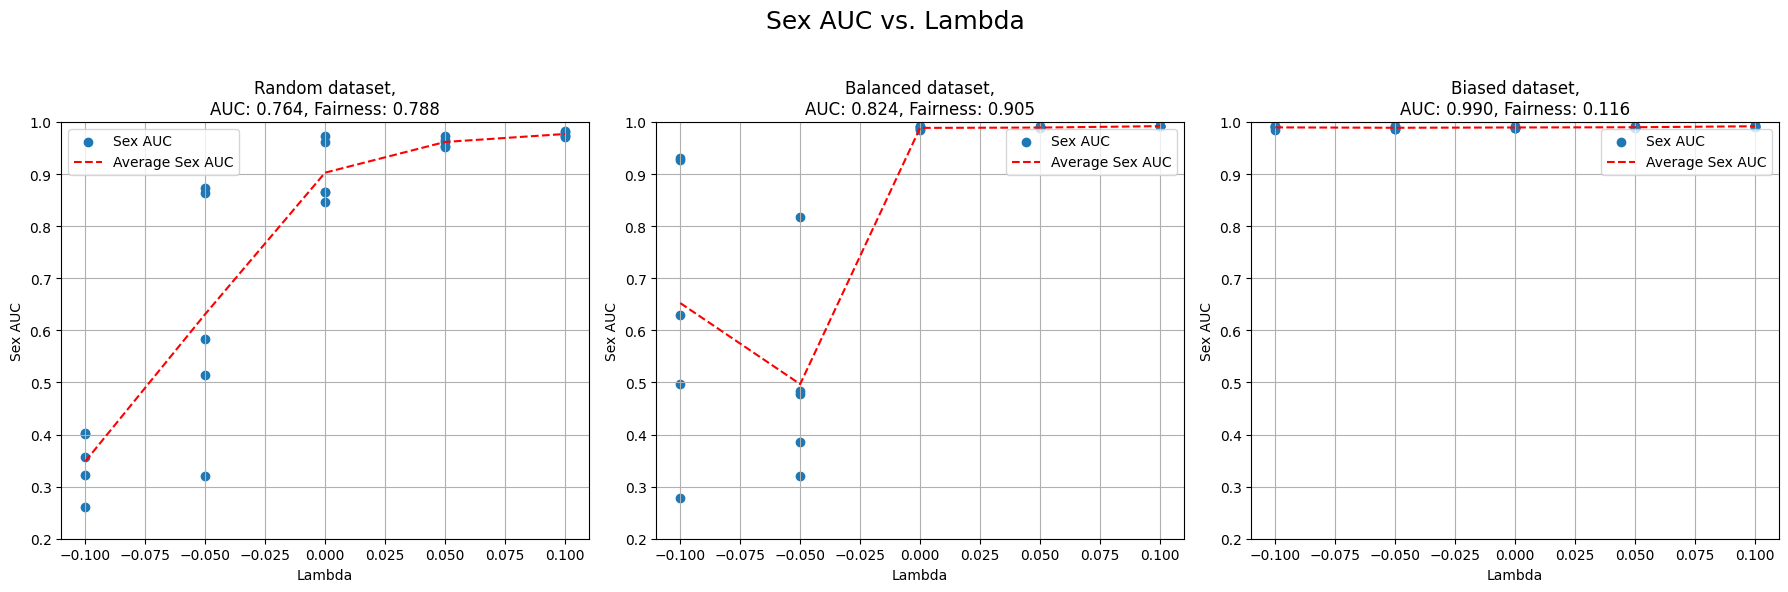

In [73]:
## with scores
test_dataset = ["Balanced"]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, train_dataset in enumerate(train_datasets):
    filtered_data = data[(data['TrainDataset'] == train_dataset) & (data['TestDataset'] == train_dataset)]
    average_auc = filtered_data.groupby('Lambda')['Sex AUC'].mean()
    sex_auc_score = filtered_data['Sex AUC'].mean()
    fairness_score = filtered_data['Equalized Odds Ratio'].mean()

    axes[i].scatter(filtered_data['Lambda'], filtered_data['Sex AUC'], marker='o', label='Sex AUC')
    axes[i].plot(average_auc.index, average_auc.values, color='red', linestyle='--', label='Average Sex AUC')
    axes[i].set_title(f'{train_dataset} dataset,\nAUC: {sex_auc_score:.3f}, Fairness: {fairness_score:.3f}')
    axes[i].set_xlabel('Lambda')
    axes[i].set_ylabel('Sex AUC')
    axes[i].set_ylim([0.2, 1])
    axes[i].grid(True)
    axes[i].legend()

fig.suptitle('Sex AUC vs. Lambda\n', fontsize=18)
plt.tight_layout()
plt.show()


Random
['Balanced']
Balanced
['Balanced']
Biased
['Balanced']


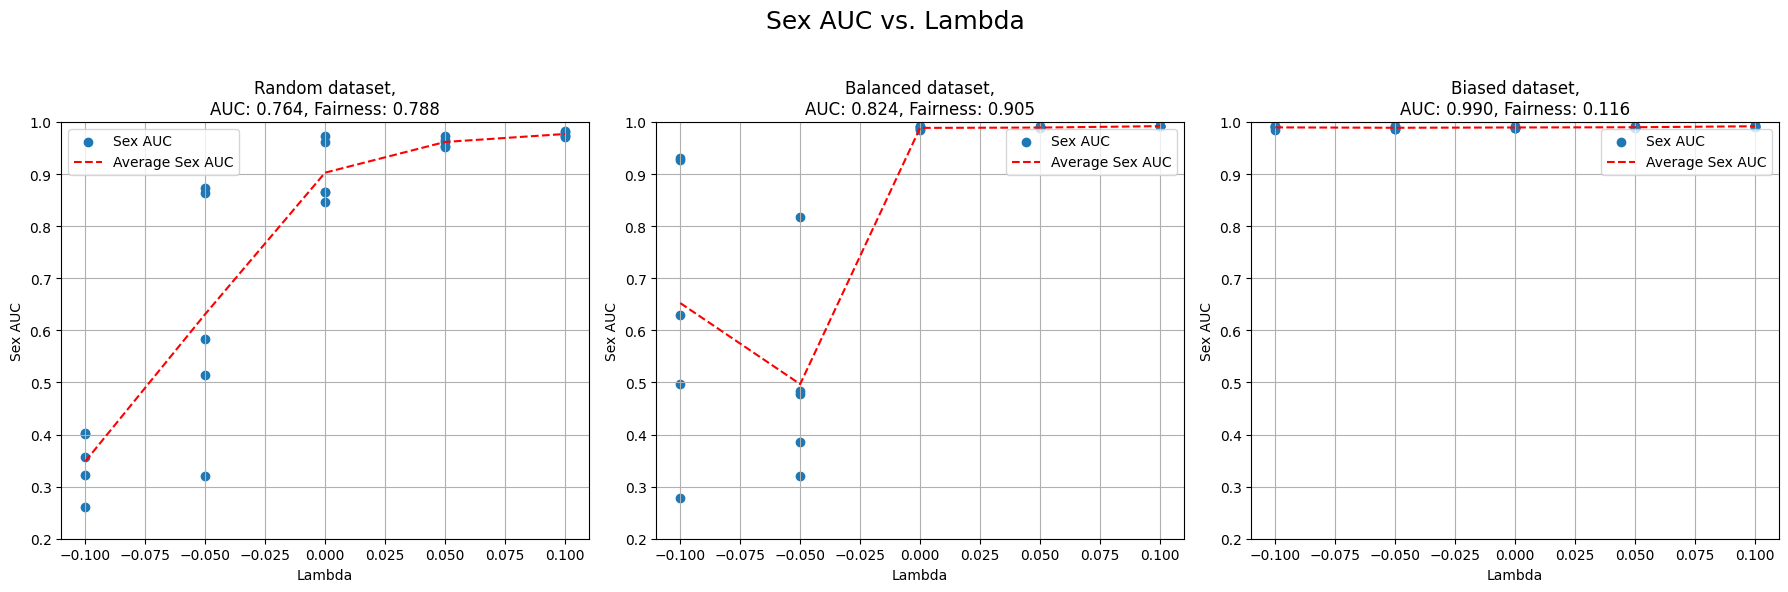

In [61]:
## with scores
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, train_dataset in enumerate(train_datasets):
    filtered_data = data[(data['TrainDataset'] == train_dataset) & (data['TestDataset'] == train_dataset)]
    print(train_dataset)
    print(test_dataset)
    average_auc = filtered_data.groupby('Lambda')['Sex AUC'].mean()
    sex_auc_score = filtered_data['Sex AUC'].mean()
    fairness_score = filtered_data['Equalized Odds Ratio'].mean()

    axes[i].scatter(filtered_data['Lambda'], filtered_data['Sex AUC'], marker='o', label='Sex AUC')
    axes[i].plot(average_auc.index, average_auc.values, color='red', linestyle='--', label='Average Sex AUC')
    axes[i].set_title(f'{train_dataset} dataset,\nAUC: {sex_auc_score:.3f}, Fairness: {fairness_score:.3f}')
    axes[i].set_xlabel('Lambda')
    axes[i].set_ylabel('Sex AUC')
    axes[i].set_ylim([0.2, 1])
    axes[i].grid(True)
    axes[i].legend()

fig.suptitle('Sex AUC vs. Lambda\n', fontsize=18)
plt.tight_layout()
plt.show()


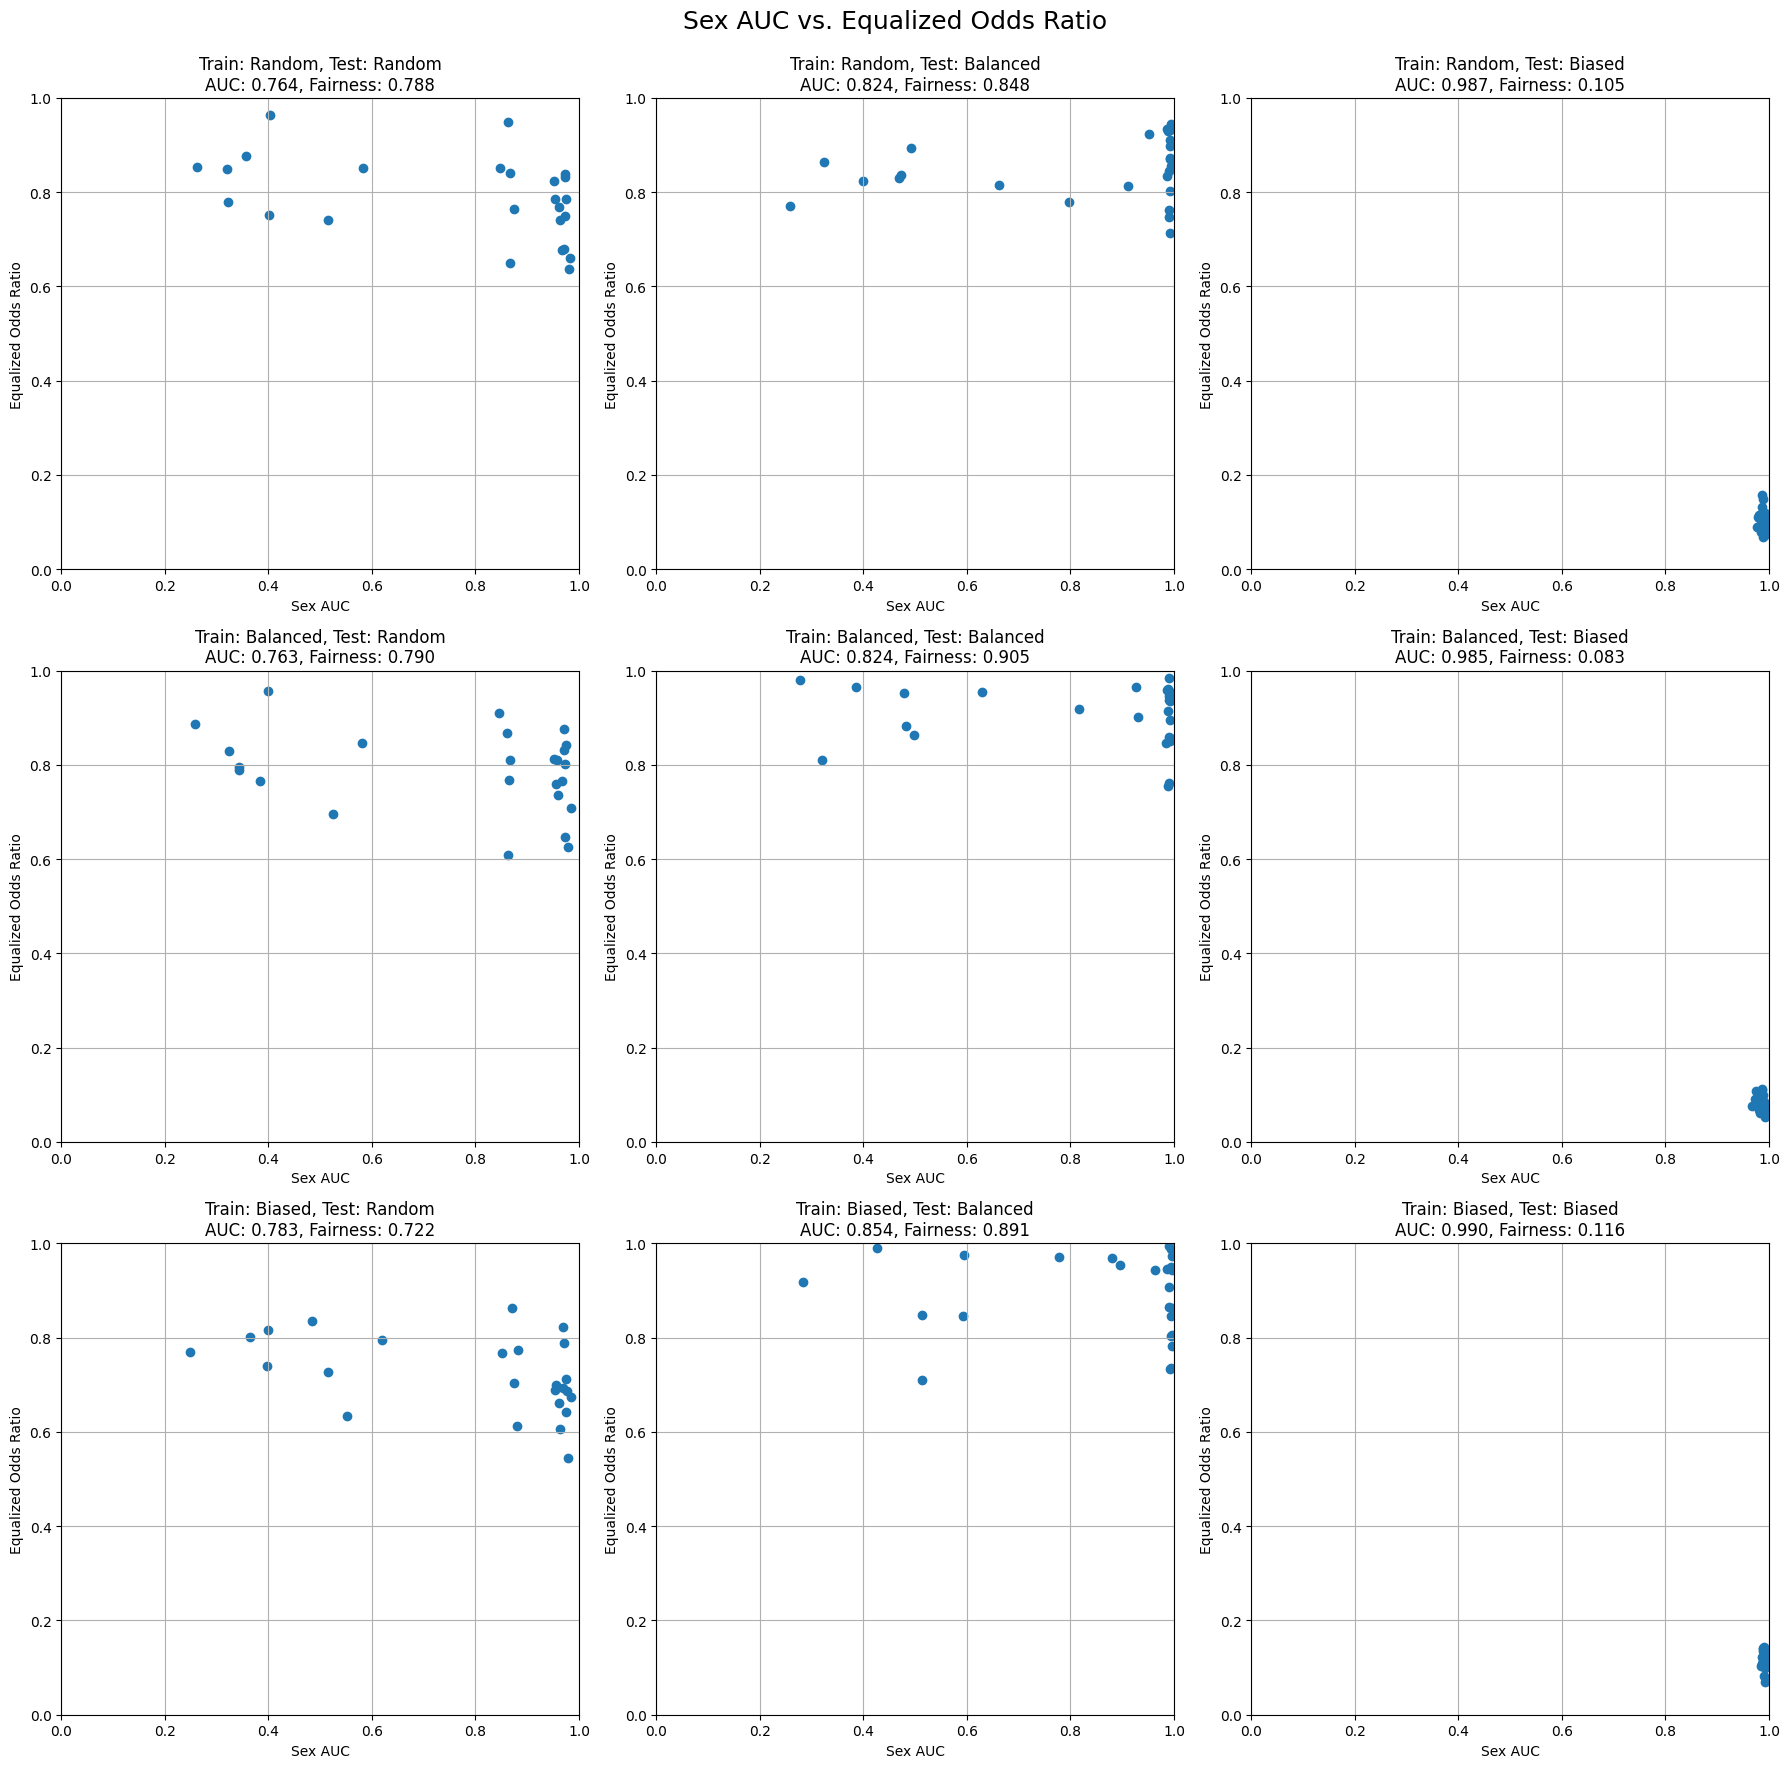

In [36]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))

for i, train_dataset in enumerate(train_datasets):
    for j, test_dataset in enumerate(test_datasets):
        filtered_data = data[(data['TrainDataset'] == train_dataset) & (data['TestDataset'] == test_dataset)]
        sex_auc_score = filtered_data['Sex AUC'].mean()
        fairness_score = filtered_data['Equalized Odds Ratio'].mean()

        axes[i, j].scatter(filtered_data['Sex AUC'], filtered_data['Equalized Odds Ratio'], marker='o')
        axes[i, j].set_title(f'Train: {train_dataset}, Test: {test_dataset}\nAUC: {sex_auc_score:.3f}, Fairness: {fairness_score:.3f}')
        axes[i, j].set_xlabel('Sex AUC')
        axes[i, j].set_ylabel('Equalized Odds Ratio')
        axes[i, j].set_xlim([0, 1])
        axes[i, j].set_ylim([0, 1])
        axes[i, j].grid(True)

fig.suptitle('Sex AUC vs. Equalized Odds Ratio\n', fontsize=18)
plt.tight_layout()
plt.show()


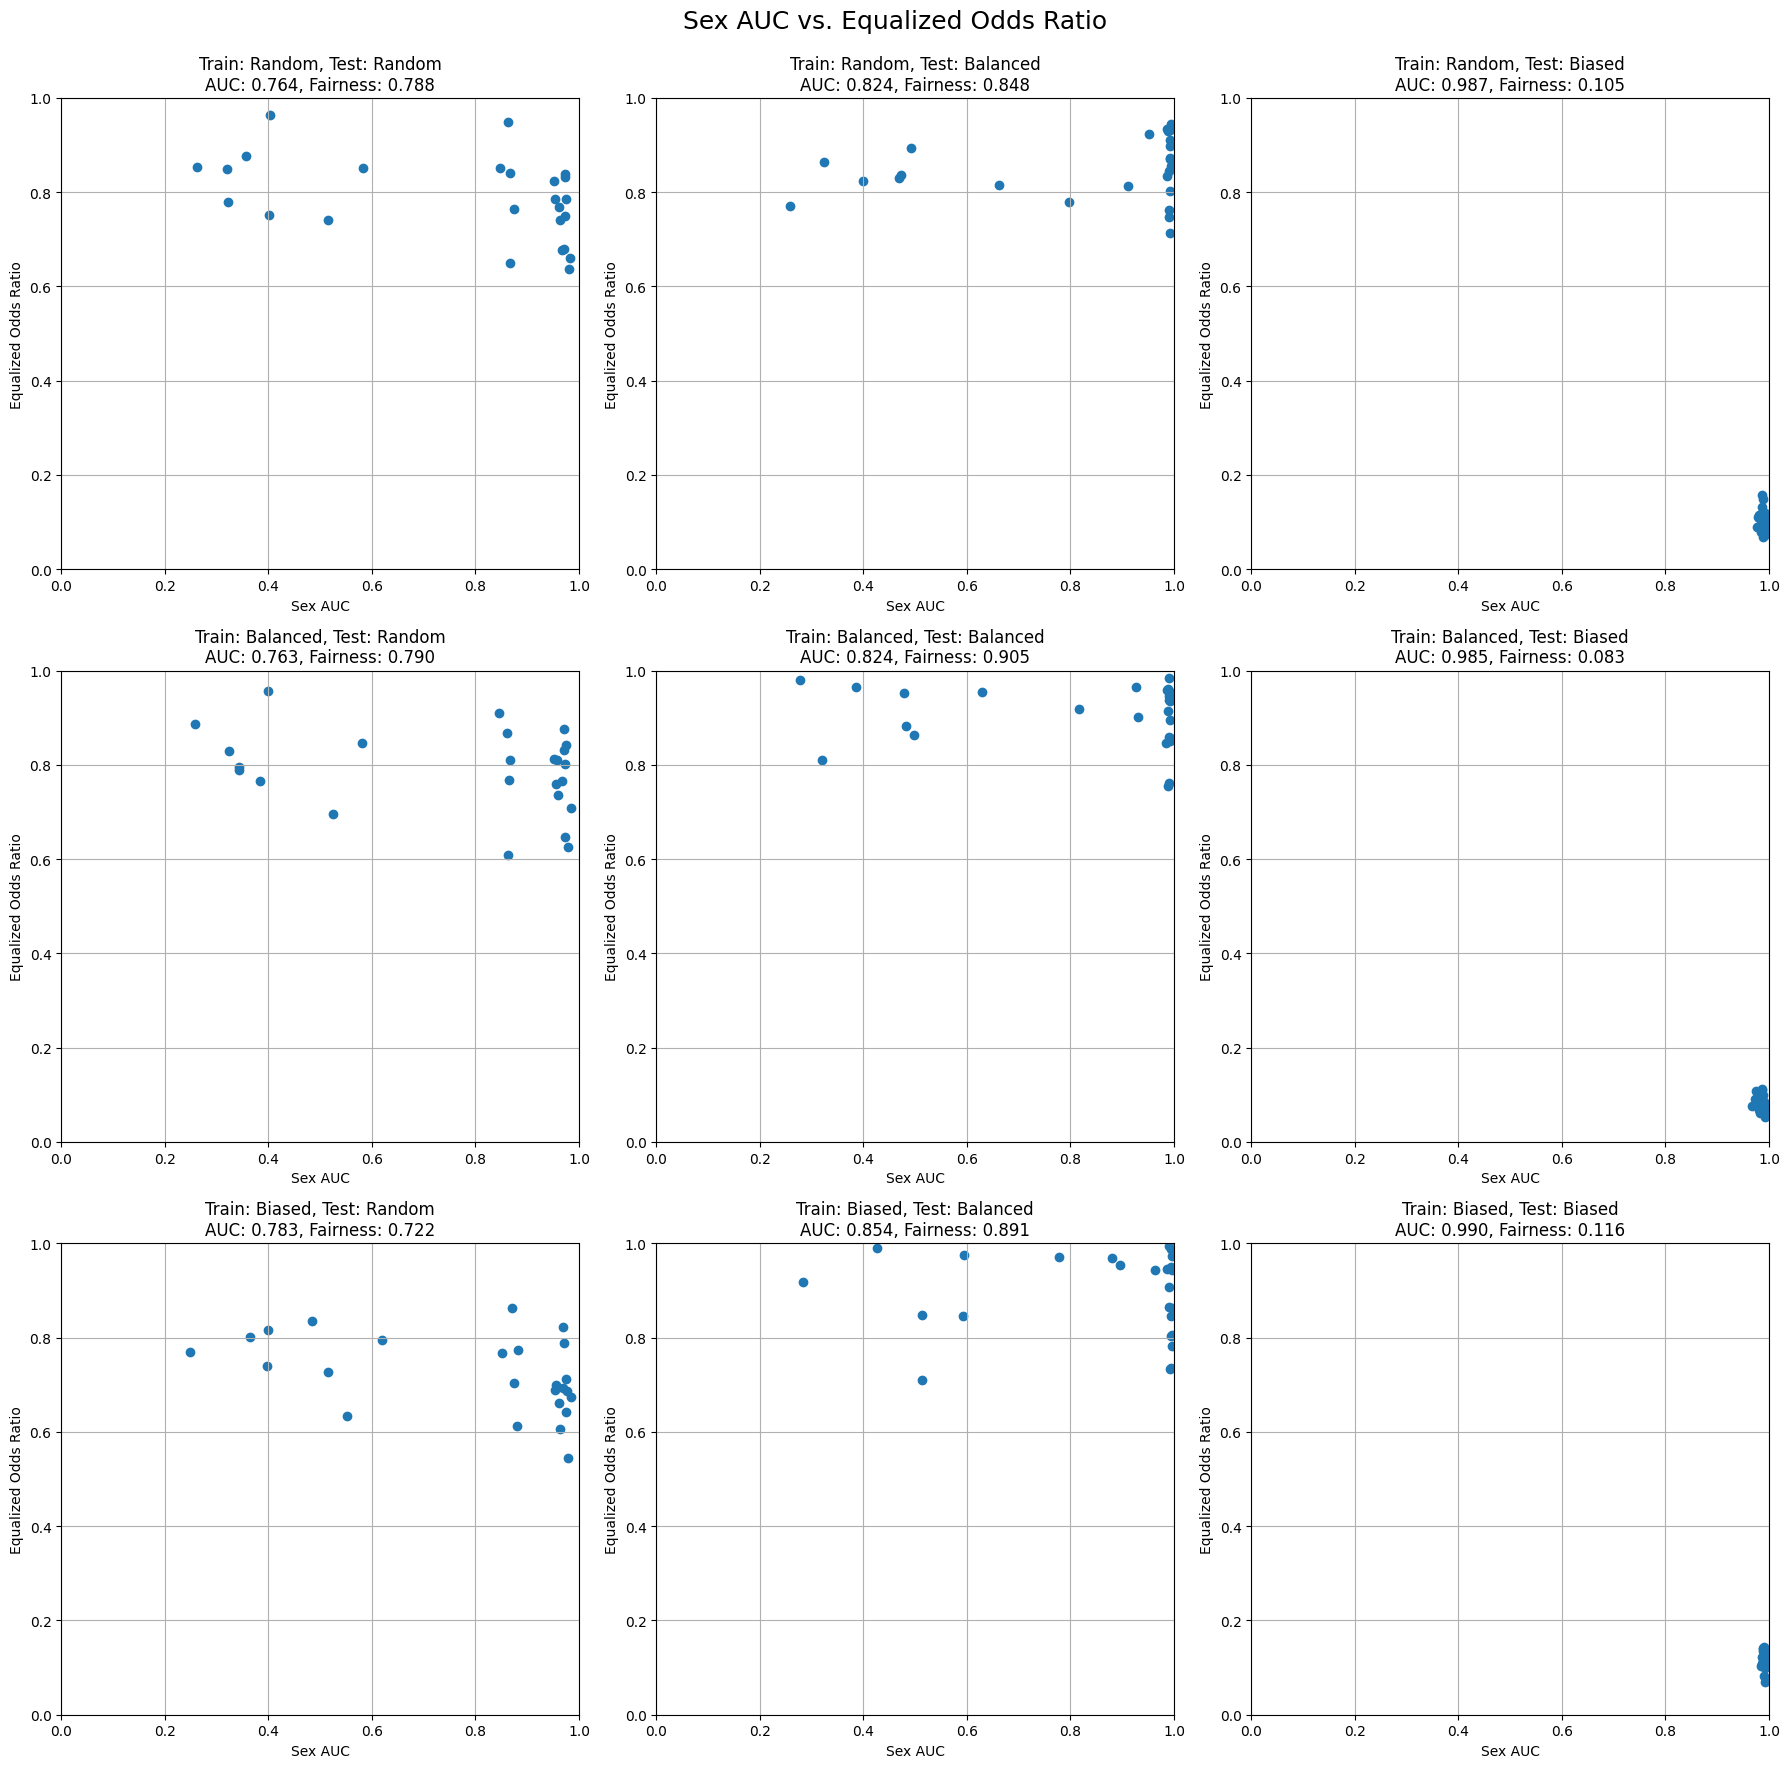

In [26]:
## with scores
fig, axes = plt.subplots(3, 3, figsize=(18, 18))

for i, train_dataset in enumerate(train_datasets):
    for j, test_dataset in enumerate(test_datasets):
        filtered_data = data[(data['TrainDataset'] == train_dataset) & (data['TestDataset'] == test_dataset)]
        sex_auc_score = filtered_data['Sex AUC'].mean()
        fairness_score = filtered_data['Equalized Odds Ratio'].mean()

        axes[i, j].scatter(filtered_data['Sex AUC'], filtered_data['Equalized Odds Ratio'], marker='o')
        axes[i, j].set_title(f'Train: {train_dataset}, Test: {test_dataset}\nAUC: {sex_auc_score:.3f}, Fairness: {fairness_score:.3f}')
        axes[i, j].set_xlabel('Sex AUC')
        axes[i, j].set_ylabel('Equalized Odds Ratio')
        axes[i, j].set_xlim([0, 1])
        axes[i, j].set_ylim([0, 1])
        axes[i, j].grid(True)

fig.suptitle('Sex AUC vs. Equalized Odds Ratio\n', fontsize=18)
plt.tight_layout()
plt.show()


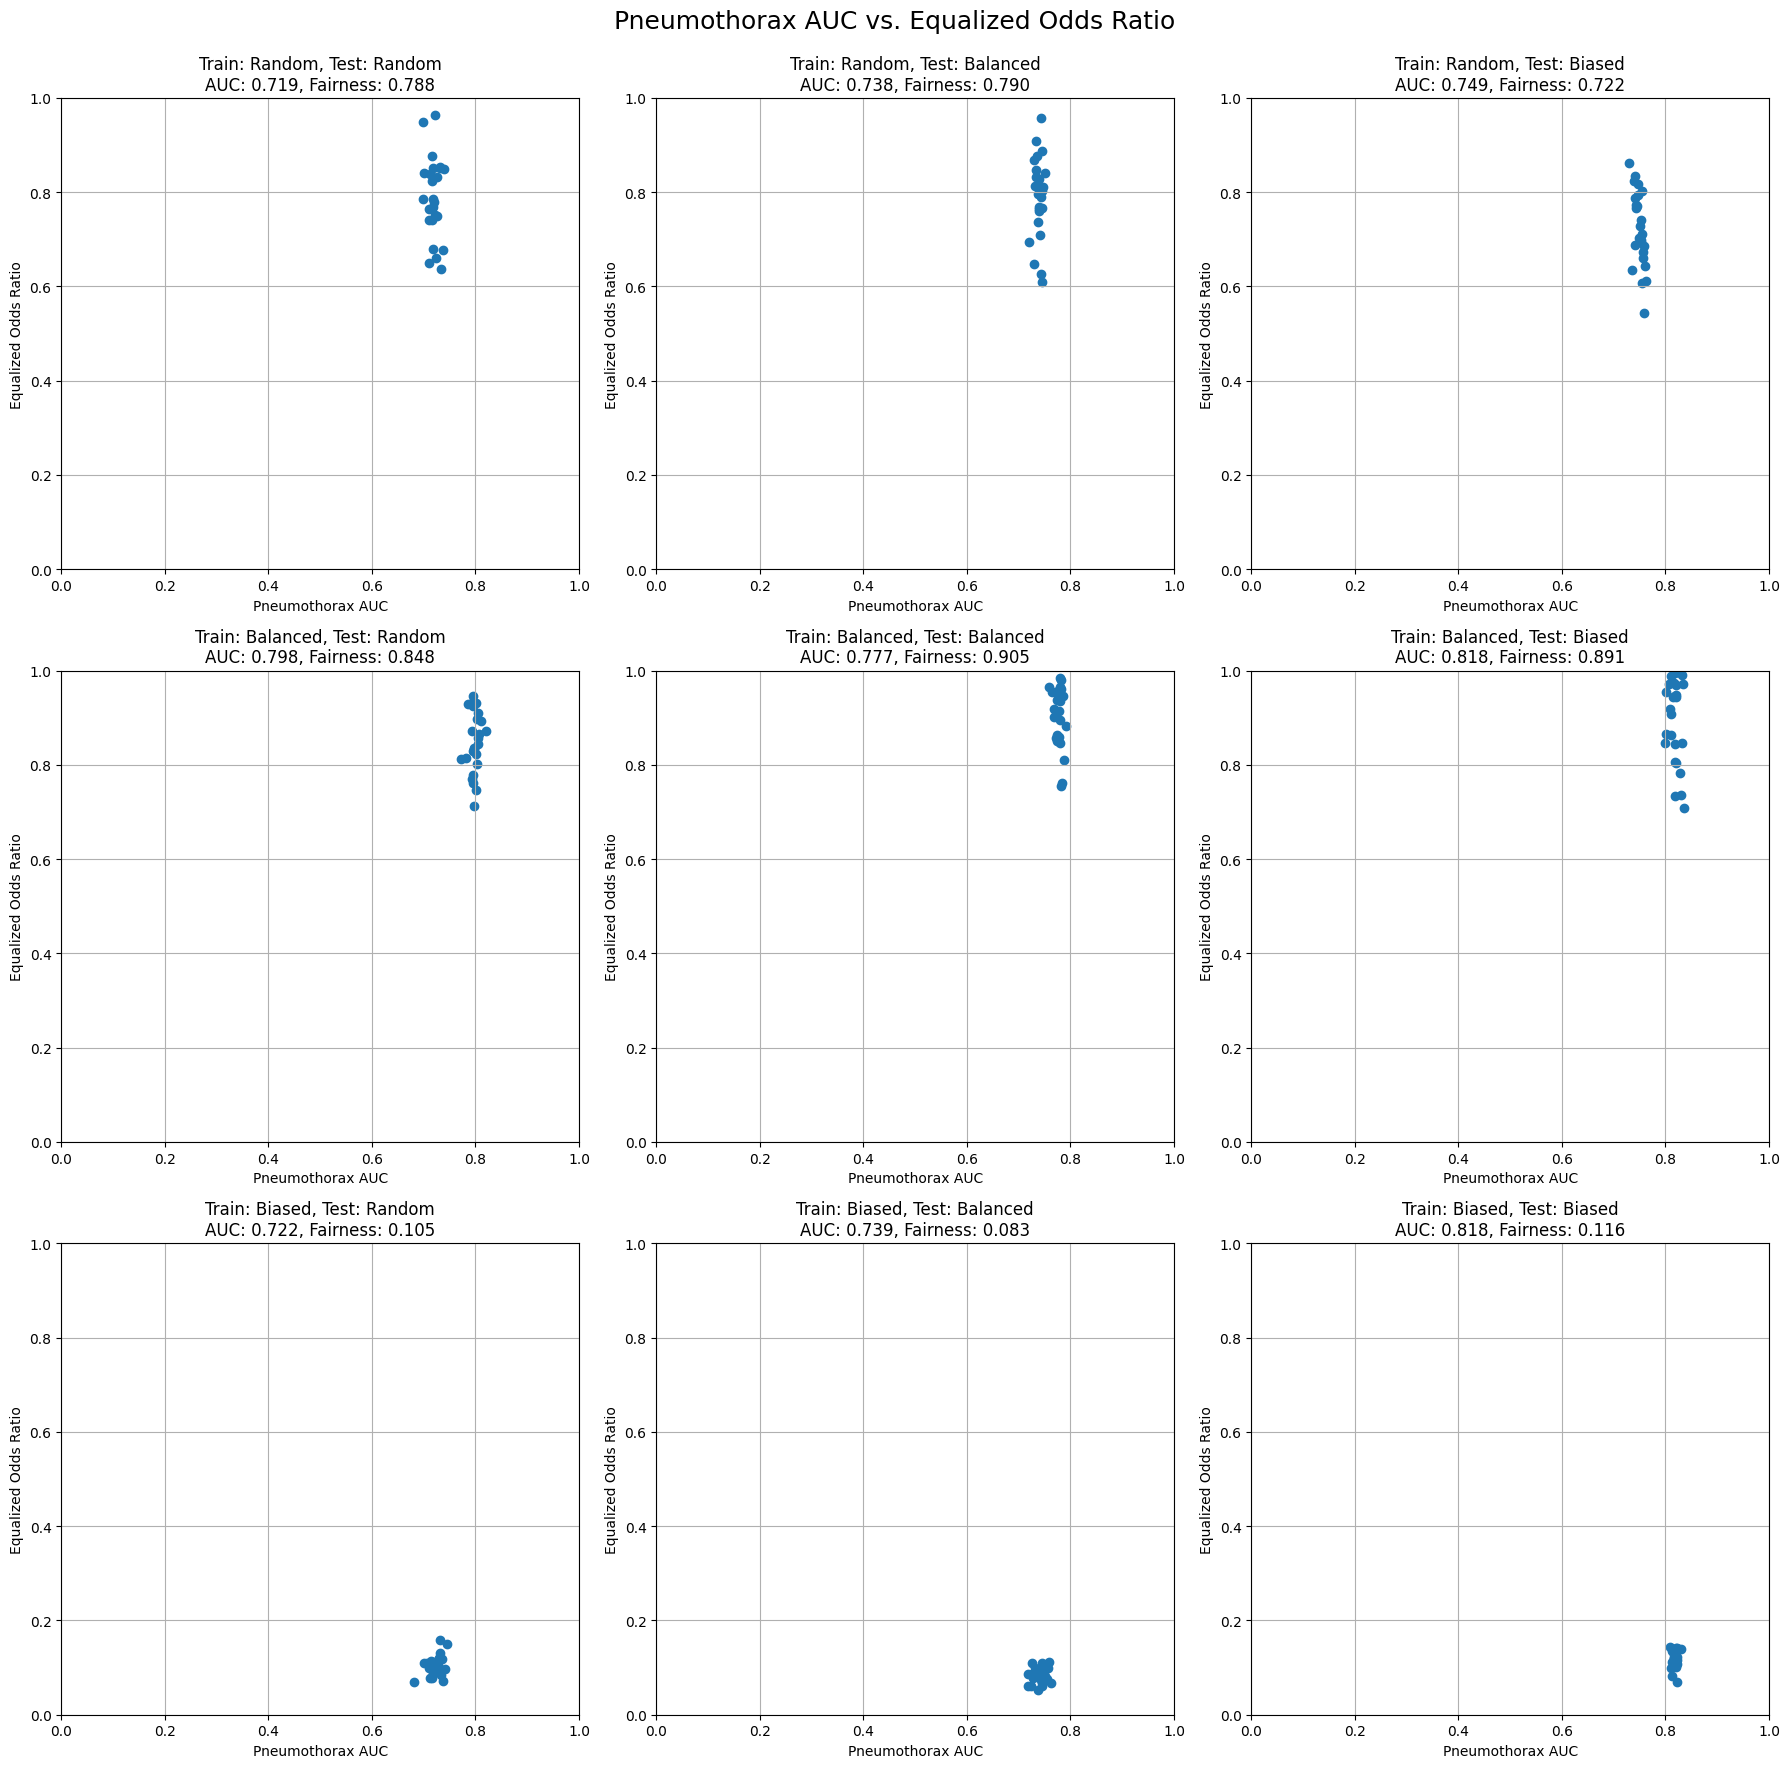

In [7]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))

for i, train_dataset in enumerate(train_datasets):
    for j, test_dataset in enumerate(test_datasets):
        filtered_data = data[(data['TrainDataset'] == train_dataset) & (data['TestDataset'] == test_dataset)]
        auc_score = filtered_data['AUC'].mean()
        fairness_score = filtered_data['Equalized Odds Ratio'].mean()

        axes[i, j].scatter(filtered_data['AUC'], filtered_data['Equalized Odds Ratio'], marker='o')
        axes[i, j].set_title(f'Train: {train_dataset}, Test: {test_dataset}\nAUC: {auc_score:.3f}, Fairness: {fairness_score:.3f}')
        axes[i, j].set_xlabel('Pneumothorax AUC')
        axes[i, j].set_ylabel('Equalized Odds Ratio')
        axes[i, j].set_xlim([0, 1])
        axes[i, j].set_ylim([0, 1])
        axes[i, j].grid(True)

fig.suptitle('Pneumothorax AUC vs. Equalized Odds Ratio\n', fontsize=18)
plt.tight_layout()
plt.show()


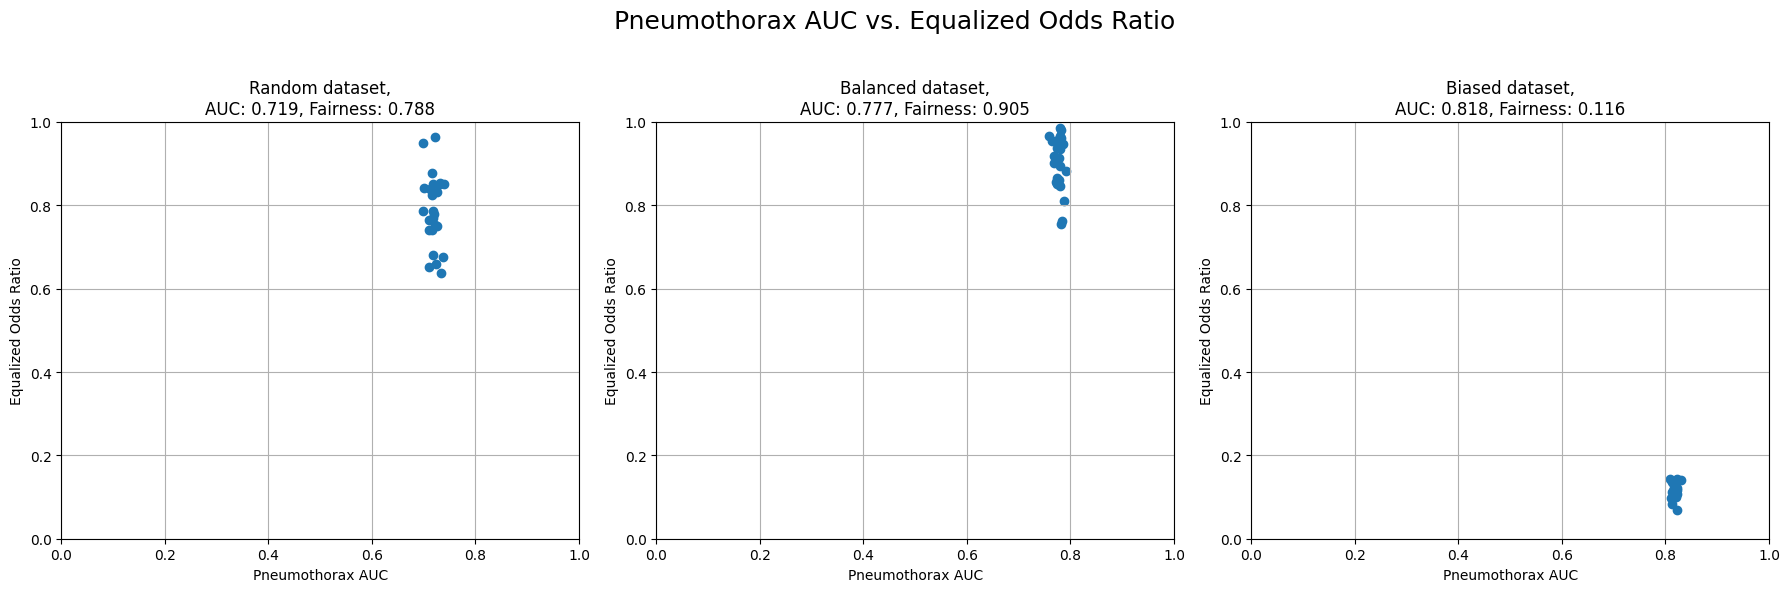

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, train_dataset in enumerate(train_datasets):
    filtered_data = data[(data['TrainDataset'] == train_dataset) & (data['TestDataset'] == train_dataset)]
    auc_score = filtered_data['AUC'].mean()
    fairness_score = filtered_data['Equalized Odds Ratio'].mean()

    axes[i].scatter(filtered_data['AUC'], filtered_data['Equalized Odds Ratio'], marker='o')
    axes[i].set_title(f'{train_dataset} dataset,\nAUC: {auc_score:.3f}, Fairness: {fairness_score:.3f}')
    axes[i].set_xlabel('Pneumothorax AUC')
    axes[i].set_ylabel('Equalized Odds Ratio')
    axes[i].set_xlim([0, 1])
    axes[i].set_ylim([0, 1])
    axes[i].grid(True)

fig.suptitle('Pneumothorax AUC vs. Equalized Odds Ratio\n', fontsize=18)
plt.tight_layout()
plt.show()

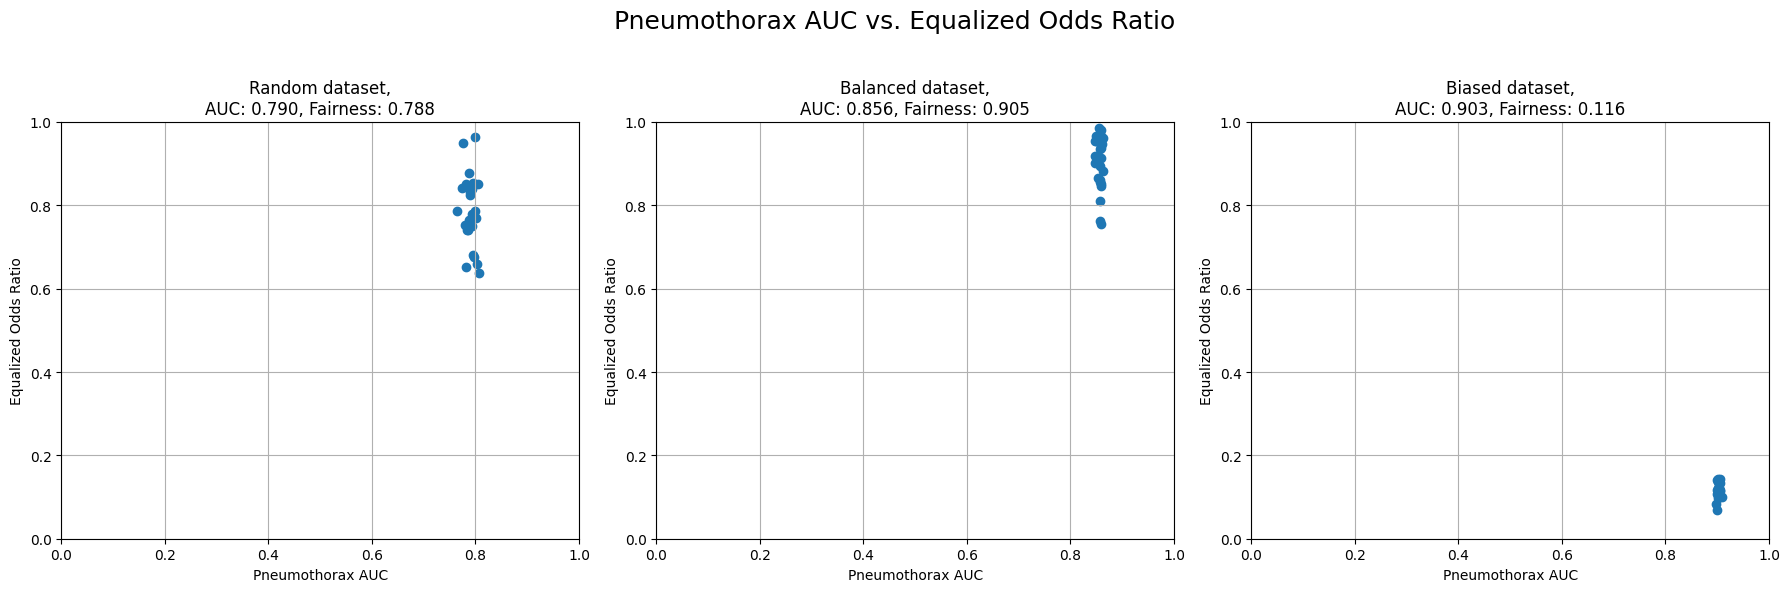

In [24]:
## with score
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, train_dataset in enumerate(train_datasets):
    filtered_data = data[(data['TrainDataset'] == train_dataset) & (data['TestDataset'] == train_dataset)]
    auc_score = filtered_data['AUC'].mean()
    fairness_score = filtered_data['Equalized Odds Ratio'].mean()

    axes[i].scatter(filtered_data['AUC'], filtered_data['Equalized Odds Ratio'], marker='o')
    axes[i].set_title(f'{train_dataset} dataset,\nAUC: {auc_score:.3f}, Fairness: {fairness_score:.3f}')
    axes[i].set_xlabel('Pneumothorax AUC')
    axes[i].set_ylabel('Equalized Odds Ratio')
    axes[i].set_xlim([0, 1])
    axes[i].set_ylim([0, 1])
    axes[i].grid(True)

fig.suptitle('Pneumothorax AUC vs. Equalized Odds Ratio\n', fontsize=18)
plt.tight_layout()
plt.show()

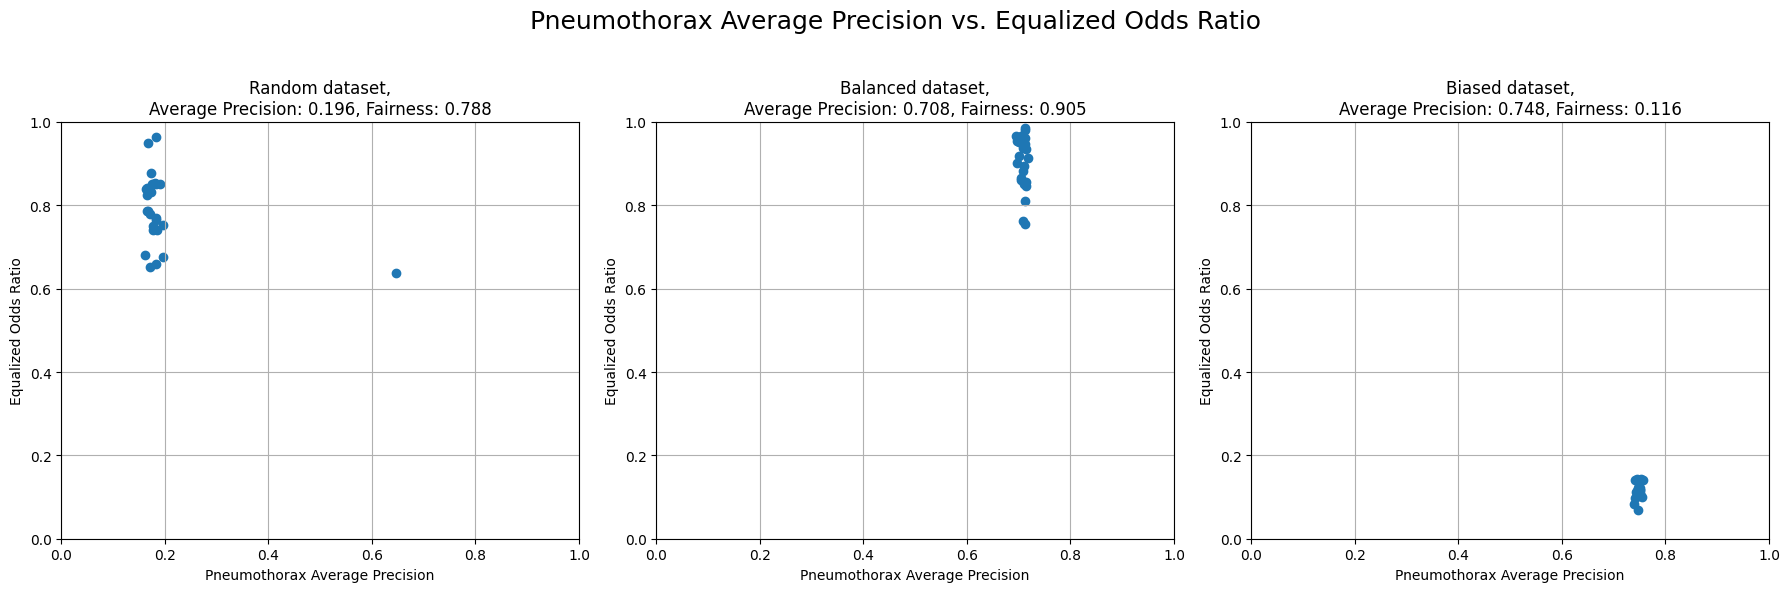

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, train_dataset in enumerate(train_datasets):
    filtered_data = data[(data['TrainDataset'] == train_dataset) & (data['TestDataset'] == train_dataset)]
    avg_precision_score = filtered_data['Average Precision'].mean()
    fairness_score = filtered_data['Equalized Odds Ratio'].mean()

    axes[i].scatter(filtered_data['Average Precision'], filtered_data['Equalized Odds Ratio'], marker='o')
    axes[i].set_title(f'{train_dataset} dataset,\nAverage Precision: {avg_precision_score:.3f}, Fairness: {fairness_score:.3f}')
    axes[i].set_xlabel('Pneumothorax Average Precision')
    axes[i].set_ylabel('Equalized Odds Ratio')
    axes[i].set_xlim([0, 1])
    axes[i].set_ylim([0, 1])
    axes[i].grid(True)

fig.suptitle('Pneumothorax Average Precision vs. Equalized Odds Ratio\n', fontsize=18)
plt.tight_layout()
plt.show()

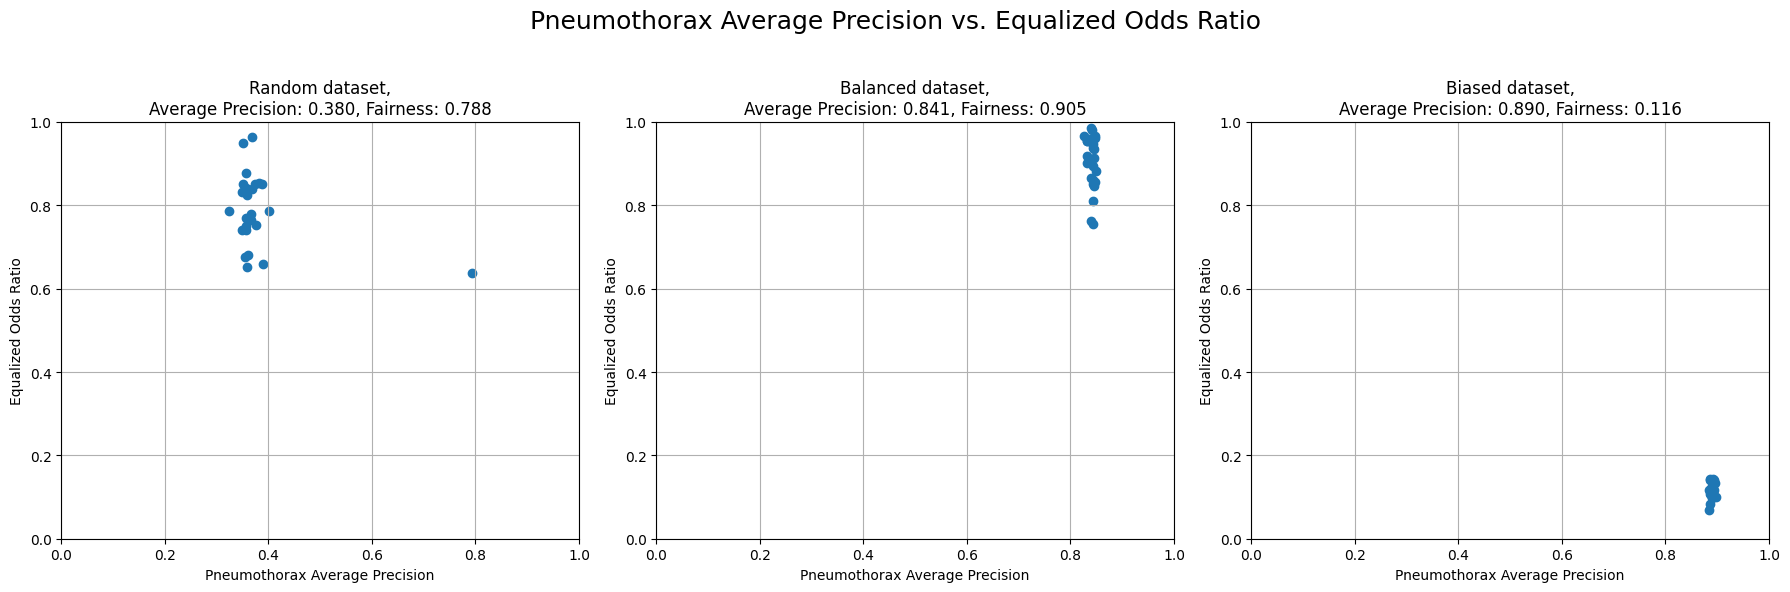

In [23]:
## with score
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, train_dataset in enumerate(train_datasets):
    filtered_data = data[(data['TrainDataset'] == train_dataset) & (data['TestDataset'] == train_dataset)]
    avg_precision_score = filtered_data['Average Precision'].mean()
    fairness_score = filtered_data['Equalized Odds Ratio'].mean()

    axes[i].scatter(filtered_data['Average Precision'], filtered_data['Equalized Odds Ratio'], marker='o')
    axes[i].set_title(f'{train_dataset} dataset,\nAverage Precision: {avg_precision_score:.3f}, Fairness: {fairness_score:.3f}')
    axes[i].set_xlabel('Pneumothorax Average Precision')
    axes[i].set_ylabel('Equalized Odds Ratio')
    axes[i].set_xlim([0, 1])
    axes[i].set_ylim([0, 1])
    axes[i].grid(True)

fig.suptitle('Pneumothorax Average Precision vs. Equalized Odds Ratio\n', fontsize=18)
plt.tight_layout()
plt.show()

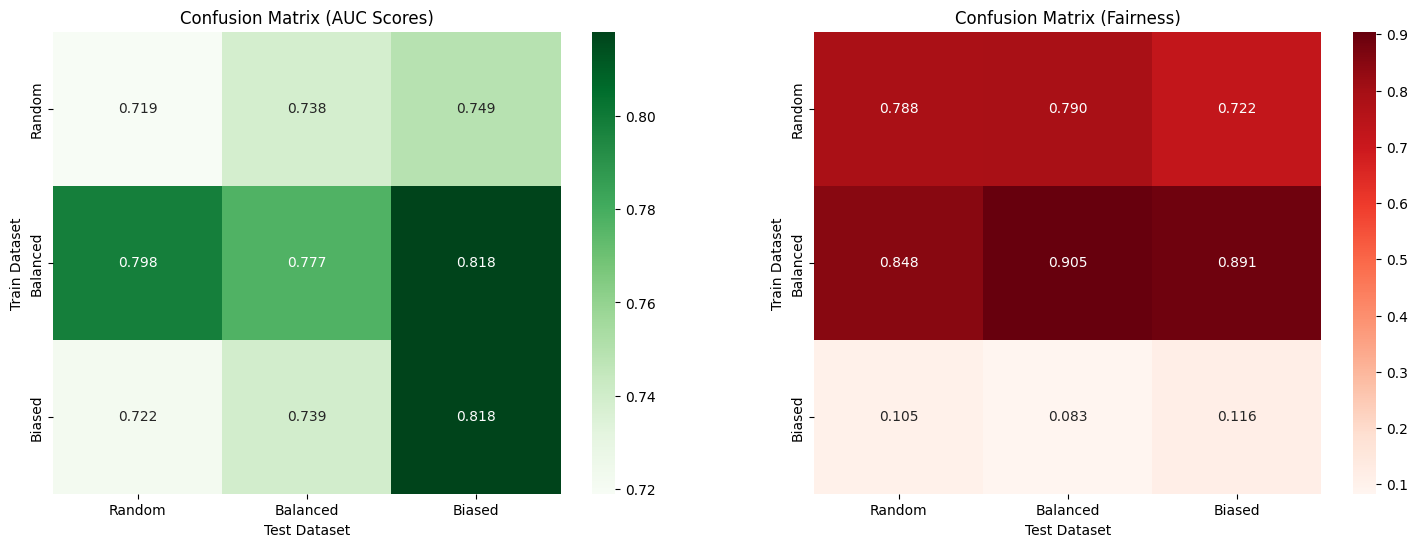

In [10]:
confusion_matrix_auc_data = pd.DataFrame(index=train_datasets, columns=test_datasets)
confusion_matrix_fairness_data = pd.DataFrame(index=train_datasets, columns=test_datasets)

for train_dataset in train_datasets:
    for test_dataset in test_datasets:
        filtered_data = data[(data['TrainDataset'] == train_dataset) & (data['TestDataset'] == test_dataset)]
        auc_score = filtered_data['AUC'].mean()
        confusion_matrix_auc_data.loc[train_dataset, test_dataset] = auc_score
        fairness_score = filtered_data['Equalized Odds Ratio'].mean()
        confusion_matrix_fairness_data.loc[train_dataset, test_dataset] = fairness_score

confusion_matrix_auc_data = confusion_matrix_auc_data.apply(pd.to_numeric)
confusion_matrix_fairness_data = confusion_matrix_fairness_data.apply(pd.to_numeric)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.heatmap(confusion_matrix_auc_data, annot=True, cmap="Greens", fmt=".3f", cbar=True, ax=axes[0])
axes[0].set_title('Confusion Matrix (AUC Scores)')
axes[0].set_xlabel('Test Dataset')
axes[0].set_ylabel('Train Dataset')

sns.heatmap(confusion_matrix_fairness_data, annot=True, cmap="Reds", fmt=".3f", cbar=True, ax=axes[1])
axes[1].set_title('Confusion Matrix (Fairness)')
axes[1].set_xlabel('Test Dataset')
axes[1].set_ylabel('Train Dataset')

plt.show()

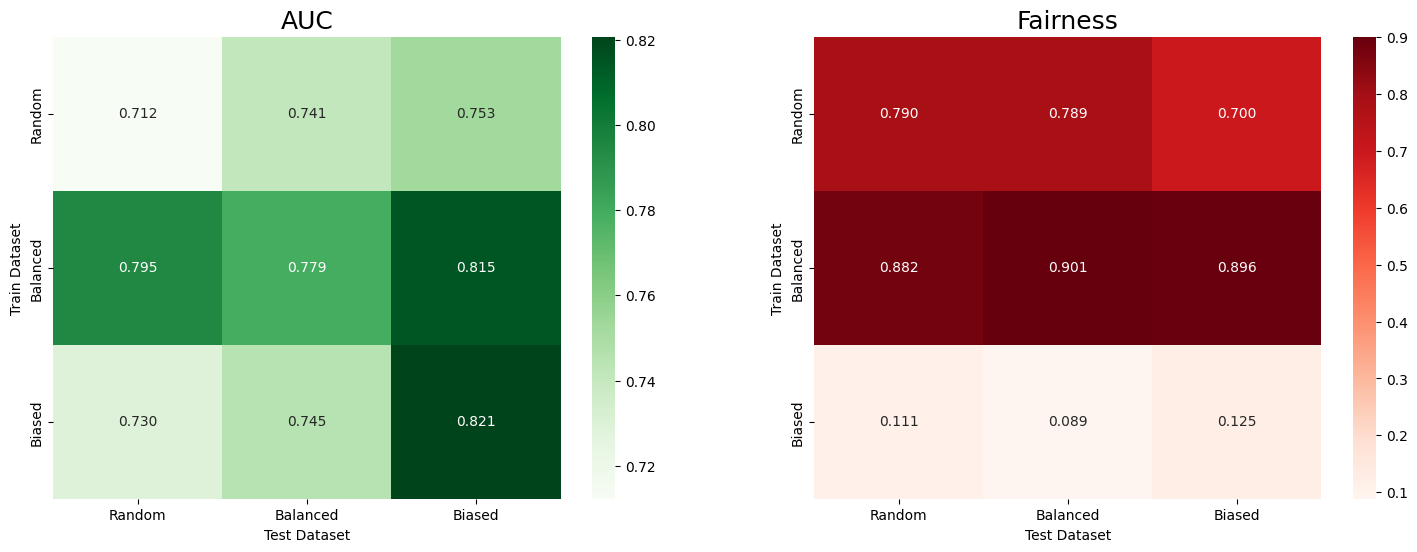

In [11]:
confusion_matrix_auc_data = pd.DataFrame(index=train_datasets, columns=test_datasets)
confusion_matrix_fairness_data = pd.DataFrame(index=train_datasets, columns=test_datasets)

for train_dataset in train_datasets:
    for test_dataset in test_datasets:
        filtered_data = data[(data['TrainDataset'] == train_dataset) & (data['TestDataset'] == test_dataset) & (data['Lambda'] == 0)]
        auc_score = filtered_data['AUC'].mean()
        confusion_matrix_auc_data.loc[train_dataset, test_dataset] = auc_score
        fairness_score = filtered_data['Equalized Odds Ratio'].mean()
        confusion_matrix_fairness_data.loc[train_dataset, test_dataset] = fairness_score

confusion_matrix_auc_data = confusion_matrix_auc_data.apply(pd.to_numeric)
confusion_matrix_fairness_data = confusion_matrix_fairness_data.apply(pd.to_numeric)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.heatmap(confusion_matrix_auc_data, annot=True, cmap="Greens", fmt=".3f", cbar=True, ax=axes[0])
axes[0].set_title('AUC', size = 18)
axes[0].set_xlabel('Test Dataset')
axes[0].set_ylabel('Train Dataset')

sns.heatmap(confusion_matrix_fairness_data, annot=True, cmap="Reds", fmt=".3f", cbar=True, ax=axes[1])
axes[1].set_title('Fairness', size = 18)
axes[1].set_xlabel('Test Dataset')
axes[1].set_ylabel('Train Dataset')

plt.show()

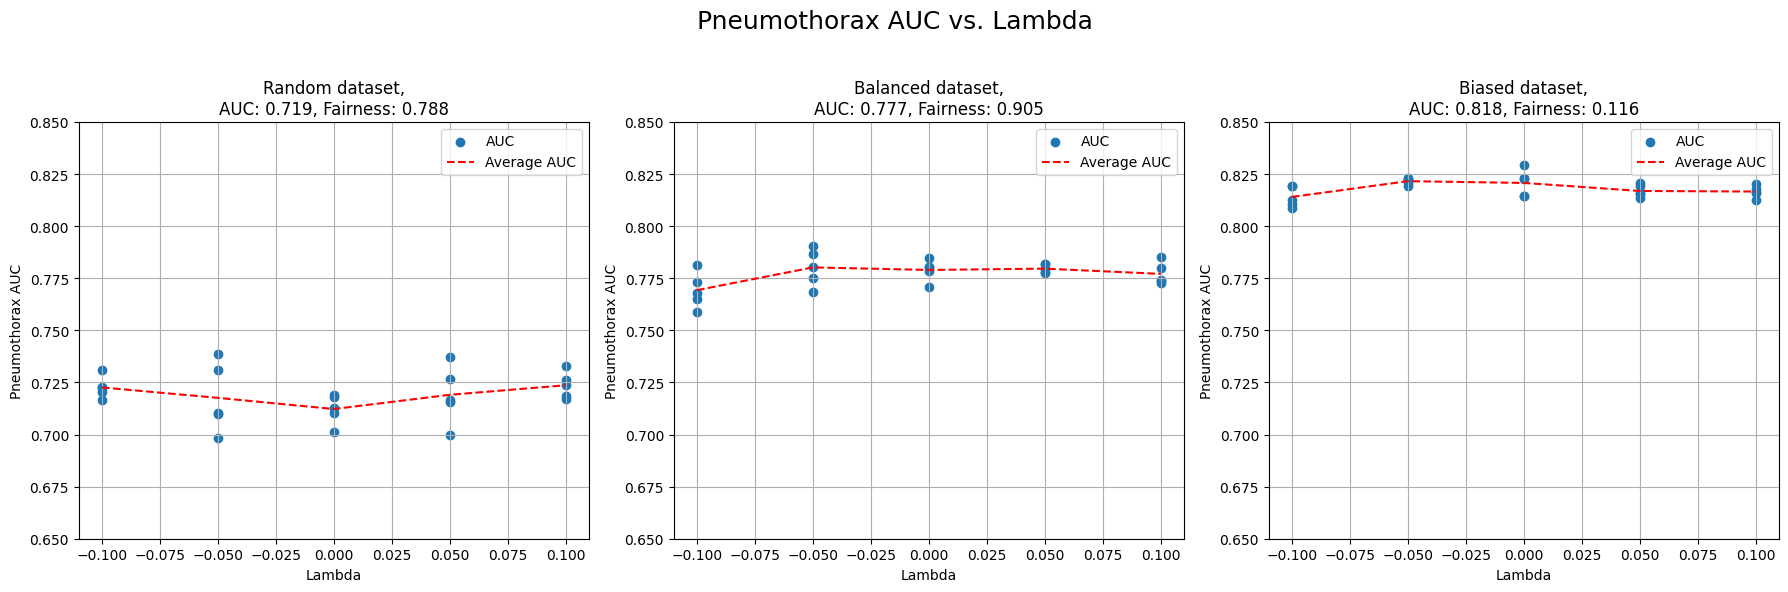

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, train_dataset in enumerate(train_datasets):
    filtered_data = data[(data['TrainDataset'] == train_dataset) & (data['TestDataset'] == train_dataset)]
    average_auc = filtered_data.groupby('Lambda')['AUC'].mean()
    auc_score = filtered_data['AUC'].mean()
    fairness_score = filtered_data['Equalized Odds Ratio'].mean()

    axes[i].scatter(filtered_data['Lambda'], filtered_data['AUC'], marker='o', label='AUC')
    axes[i].plot(average_auc.index, average_auc.values, color='red', linestyle='--', label='Average AUC')
    axes[i].set_title(f'{train_dataset} dataset,\nAUC: {auc_score:.3f}, Fairness: {fairness_score:.3f}')
    axes[i].set_xlabel('Lambda')
    axes[i].set_ylabel('Pneumothorax AUC')
    axes[i].set_ylim([0.65, 0.85])
    axes[i].grid(True)
    axes[i].legend()

fig.suptitle('Pneumothorax AUC vs. Lambda\n', fontsize=18)
plt.tight_layout()
plt.show()


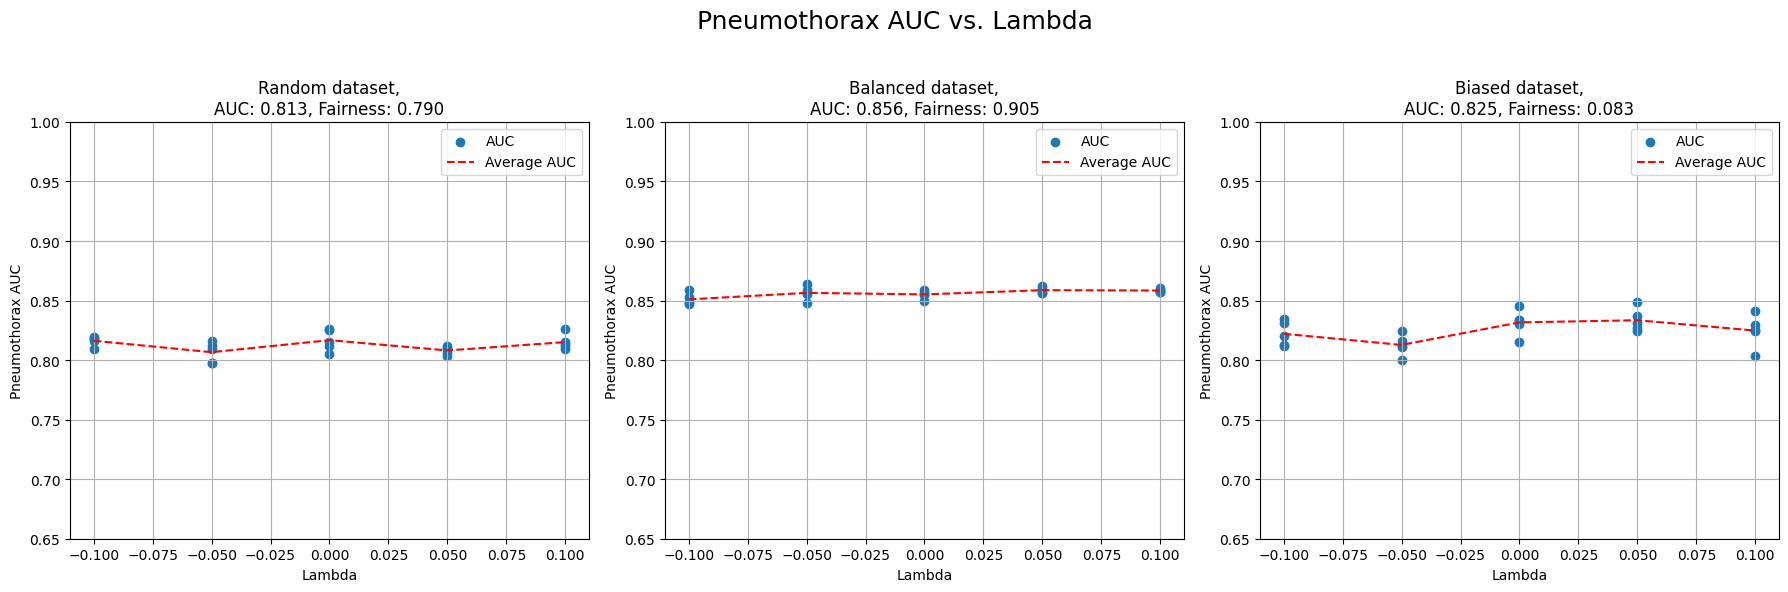

In [69]:
## with scores
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, train_dataset in enumerate(train_datasets):
    filtered_data = data[(data['TrainDataset'] == train_dataset) & (data['TestDataset'] == "Balanced")]
    average_auc = filtered_data.groupby('Lambda')['AUC'].mean()
    auc_score = filtered_data['AUC'].mean()
    fairness_score = filtered_data['Equalized Odds Ratio'].mean()

    axes[i].scatter(filtered_data['Lambda'], filtered_data['AUC'], marker='o', label='AUC')
    axes[i].plot(average_auc.index, average_auc.values, color='red', linestyle='--', label='Average AUC')
    axes[i].set_title(f'{train_dataset} dataset,\nAUC: {auc_score:.3f}, Fairness: {fairness_score:.3f}')
    axes[i].set_xlabel('Lambda')
    axes[i].set_ylabel('Pneumothorax AUC')
    axes[i].set_ylim([0.65, 1])
    axes[i].grid(True)
    axes[i].legend()

fig.suptitle('Pneumothorax AUC vs. Lambda\n', fontsize=18)
plt.tight_layout()
plt.show()


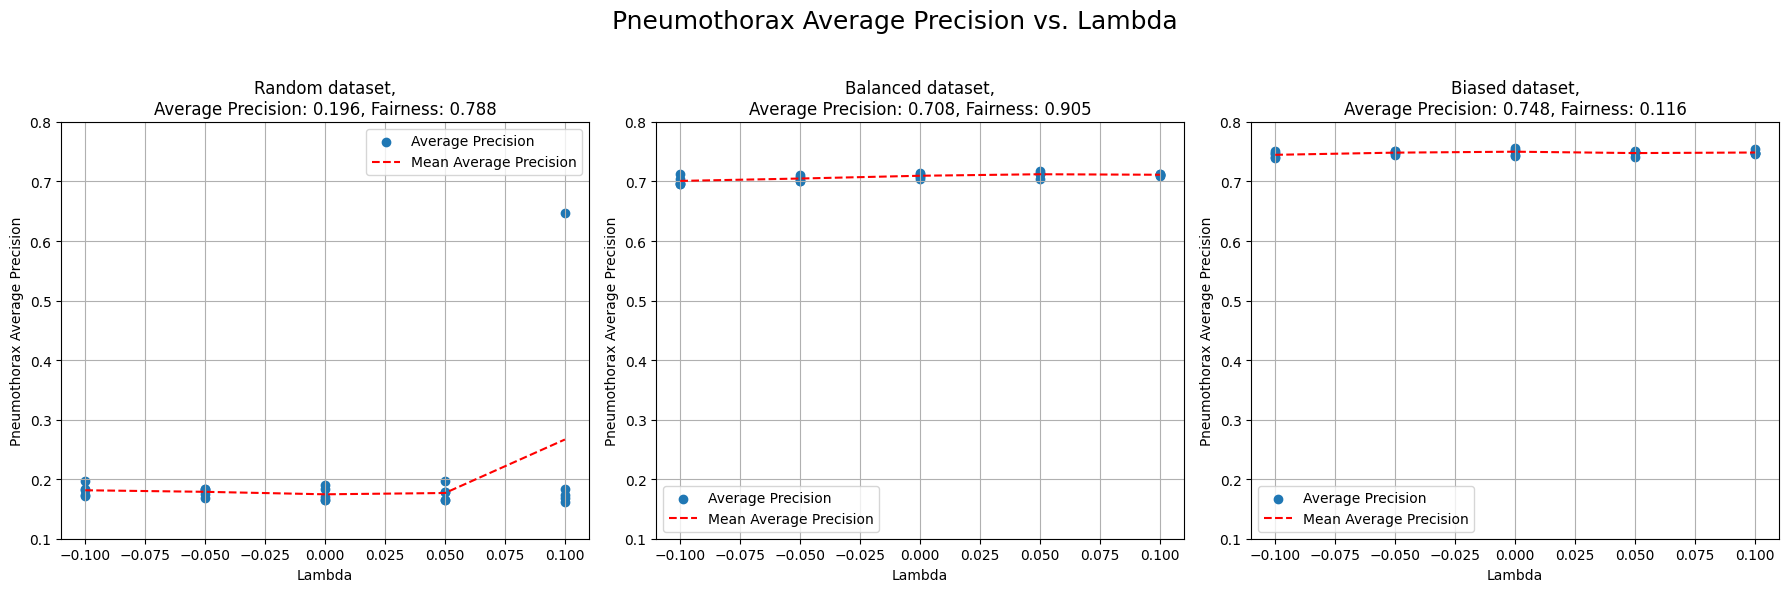

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, train_dataset in enumerate(train_datasets):
    filtered_data = data[(data['TrainDataset'] == train_dataset) & (data['TestDataset'] == train_dataset)]
    average_avg_precision = filtered_data.groupby('Lambda')['Average Precision'].mean()
    avg_precision_score = filtered_data['Average Precision'].mean()
    fairness_score = filtered_data['Equalized Odds Ratio'].mean()

    axes[i].scatter(filtered_data['Lambda'], filtered_data['Average Precision'], marker='o', label='Average Precision')
    axes[i].plot(average_avg_precision.index, average_avg_precision.values, color='red', linestyle='--', label='Mean Average Precision')
    axes[i].set_title(f'{train_dataset} dataset,\nAverage Precision: {avg_precision_score:.3f}, Fairness: {fairness_score:.3f}')
    axes[i].set_xlabel('Lambda')

    axes[i].set_ylabel('Pneumothorax Average Precision')
    axes[i].set_ylim([0.1, 0.8])
    axes[i].grid(True)
    axes[i].legend()

fig.suptitle('Pneumothorax Average Precision vs. Lambda\n', fontsize=18)
plt.tight_layout()
plt.show()


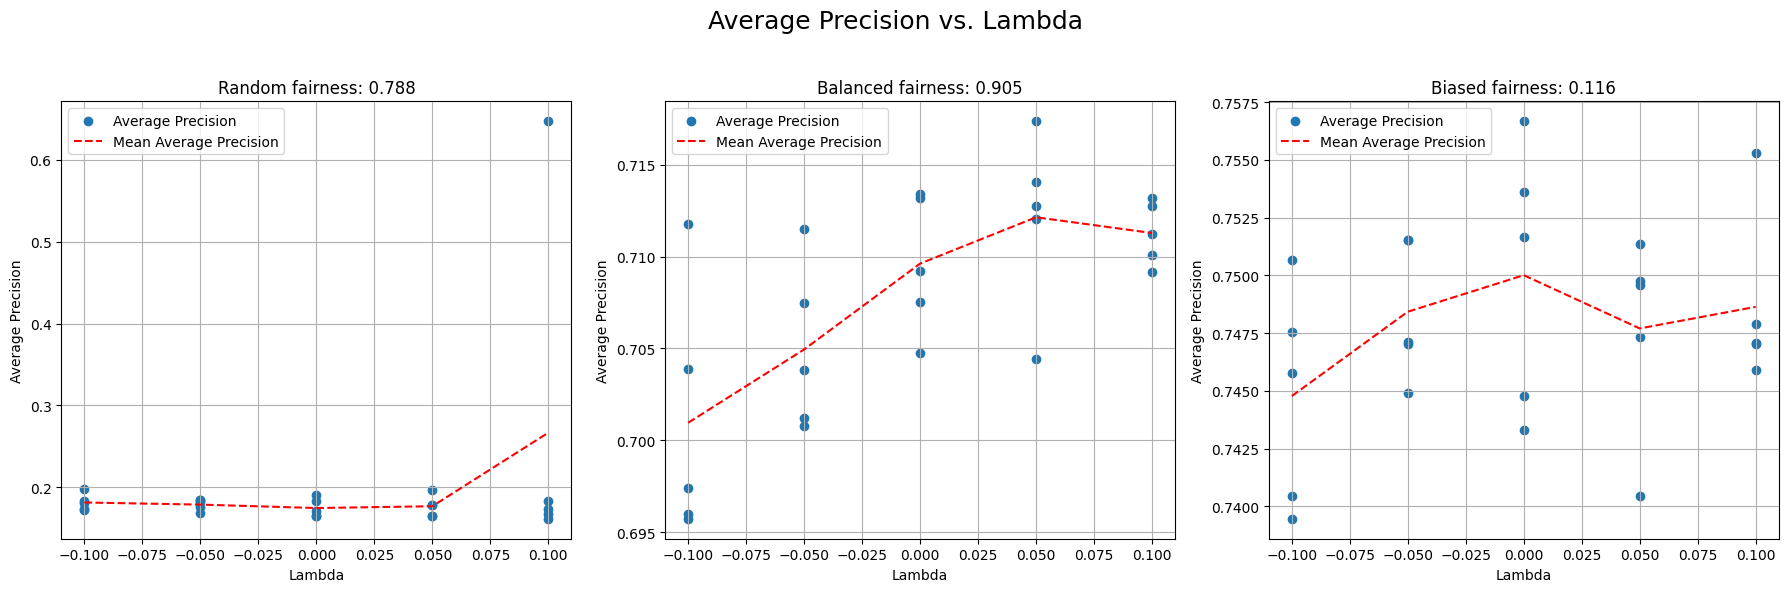

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, train_dataset in enumerate(train_datasets):
    filtered_data = data[(data['TrainDataset'] == train_dataset) & (data['TestDataset'] == train_dataset)]
    average_avg_precision = filtered_data.groupby('Lambda')['Average Precision'].mean()
    fairness_score = filtered_data['Equalized Odds Ratio'].mean()

    axes[i].scatter(filtered_data['Lambda'], filtered_data['Average Precision'], marker='o', label='Average Precision')
    axes[i].plot(average_avg_precision.index, average_avg_precision.values, color='red', linestyle='--', label='Mean Average Precision')
    axes[i].set_title(f'{train_dataset} fairness: {fairness_score:.3f}')
    
    axes[i].set_xlabel('Lambda')
    axes[i].set_ylabel('Average Precision')
    axes[i].grid(True)
    axes[i].legend()

fig.suptitle('Average Precision vs. Lambda\n', fontsize=18)
plt.tight_layout()
plt.show()


## Chest Drain Predictions

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

from tabulate import tabulate
from scipy.stats import pearsonr, spearmanr

pred_data = pd.read_csv('../shortcuts-chest-xray/predictions/Chest Drains/Prediction_analysis_chest_drains.csv')

In [16]:
drains_train_data = pd.read_csv("../shortcuts-chest-xray/preprocess/datasets/chest_drains_dataset_train.csv", index_col=0)

drain_distribution_counts = drains_train_data['Drain'].value_counts(dropna=False)
drain_distribution_percentages = drains_train_data['Drain'].value_counts(normalize=True, dropna=False) * 100

drain_distribution_table = pd.DataFrame({
    'Count': drain_distribution_counts,
    'Percentage': drain_distribution_percentages.map('{:.2f}%'.format)
})

print("Chest Drains Distribution:")
print(tabulate(drain_distribution_table, headers='keys', tablefmt='fancy_grid'))

drains_train_data['Pneumothorax'] = drains_train_data['Pneumothorax'].replace([-1, 0], "Negative")
drains_train_data['Pneumothorax'] = drains_train_data['Pneumothorax'].fillna("Negative")
drains_train_data['Pneumothorax'] = drains_train_data['Pneumothorax'].replace([1], "Positive")

pneumothorax_distribution_counts = drains_train_data['Pneumothorax'].value_counts(dropna=False)
pneumothorax_distribution_percentages = drains_train_data['Pneumothorax'].value_counts(normalize=True, dropna=False) * 100

pneumothorax_distribution_table = pd.DataFrame({
    'Count': pneumothorax_distribution_counts,
    'Percentage': pneumothorax_distribution_percentages.map('{:.2f}%'.format)
})

print("\nPneumothorax Distribution:")
print(tabulate(pneumothorax_distribution_table, headers='keys', tablefmt='fancy_grid'))


Chest Drains Distribution:
╒════╤═════════╤══════════════╕
│    │   Count │ Percentage   │
╞════╪═════════╪══════════════╡
│  0 │    4420 │ 74.78%       │
├────┼─────────┼──────────────┤
│  1 │    1491 │ 25.22%       │
╘════╧═════════╧══════════════╛

Pneumothorax Distribution:
╒══════════╤═════════╤══════════════╕
│          │   Count │ Percentage   │
╞══════════╪═════════╪══════════════╡
│ Negative │    3363 │ 56.89%       │
├──────────┼─────────┼──────────────┤
│ Positive │    2548 │ 43.11%       │
╘══════════╧═════════╧══════════════╛


In [17]:
pneumothorax_by_drain_distribution = drains_train_data.groupby(['Drain', 'Pneumothorax']).size().unstack(fill_value=0)
pneumothorax_by_drain_percentage = pneumothorax_by_drain_distribution.div(pneumothorax_by_drain_distribution.sum(axis=1), axis=0) * 100

combined_table = pneumothorax_by_drain_distribution.astype(str) + ' (' + pneumothorax_by_drain_percentage.round(2).astype(str) + '%)'

print("Combined Pneumothorax Distribution with Chest Drains:")
print(tabulate(combined_table, headers='keys', tablefmt='fancy_grid'))


Combined Pneumothorax Distribution with Chest Drains:
╒═════════╤═══════════════╤═══════════════╕
│   Drain │ Negative      │ Positive      │
╞═════════╪═══════════════╪═══════════════╡
│       0 │ 3067 (69.39%) │ 1353 (30.61%) │
├─────────┼───────────────┼───────────────┤
│       1 │ 296 (19.85%)  │ 1195 (80.15%) │
╘═════════╧═══════════════╧═══════════════╛


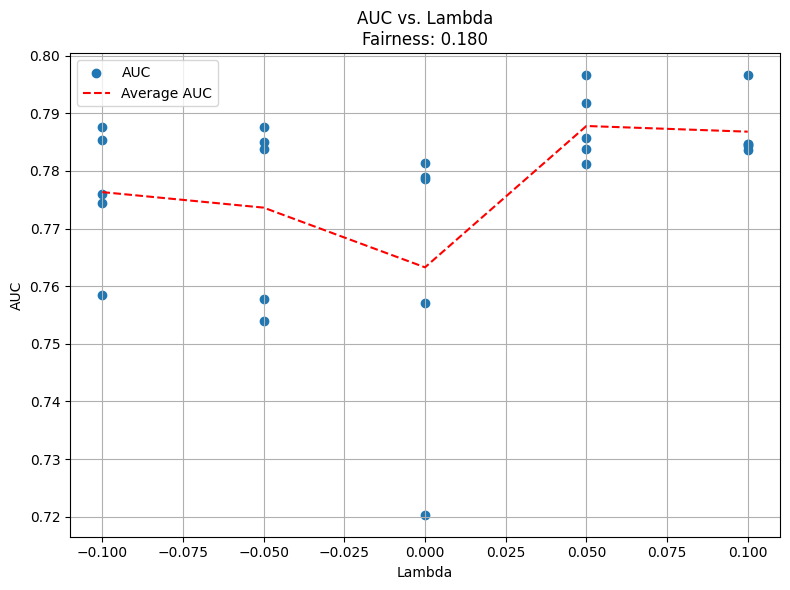

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
average_auc = pred_data.groupby('Lambda')['AUC'].mean()
fairness_score = pred_data['Equalized Odds Ratio'].mean()

plt.scatter(pred_data['Lambda'], pred_data['AUC'], marker='o', label='AUC')
plt.plot(average_auc.index, average_auc.values, color='red', linestyle='--', label='Average AUC')
plt.title(f'AUC vs. Lambda\nFairness: {fairness_score:.3f}')
plt.xlabel('Lambda')
plt.ylabel('AUC')
# plt.ylim([0.2, 1])
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


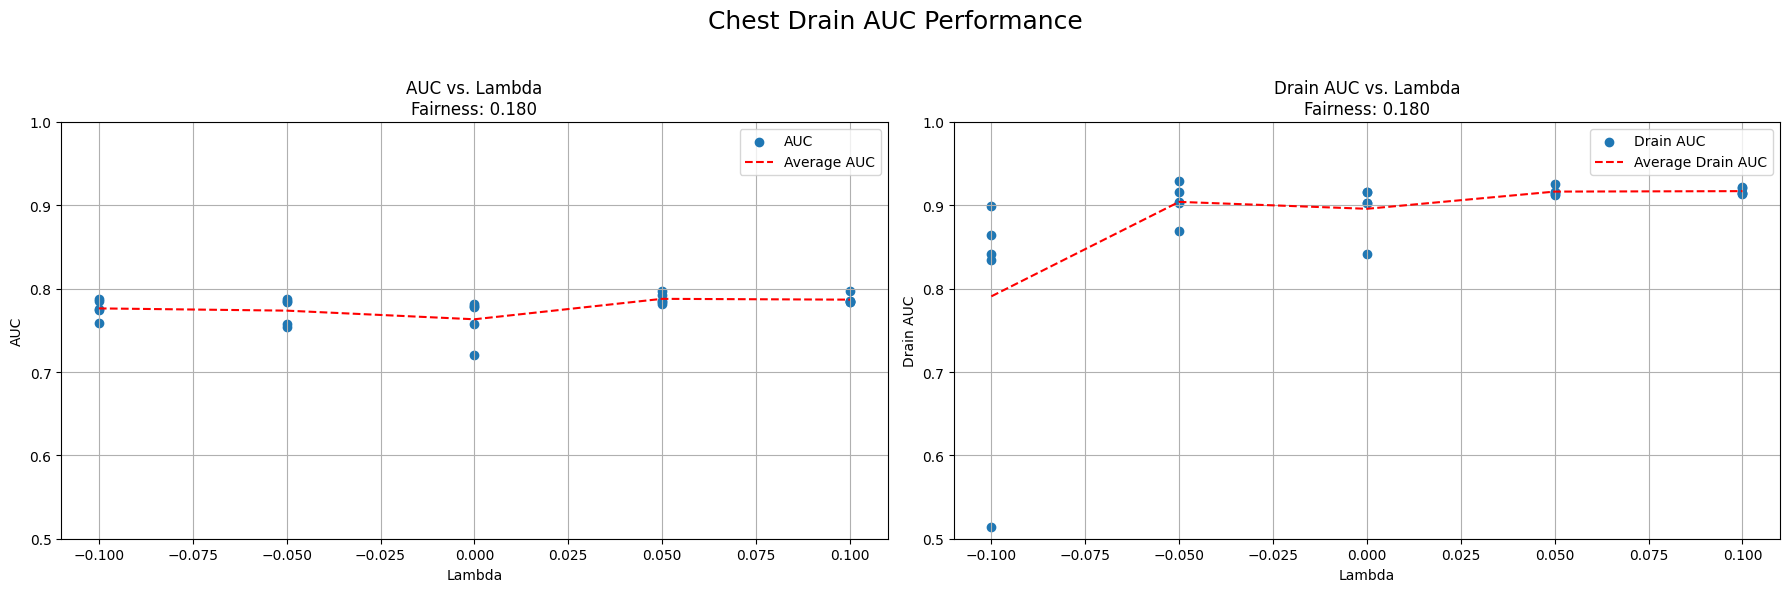

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
average_auc = pred_data.groupby('Lambda')['AUC'].mean()
average_sens_auc = pred_data.groupby('Lambda')['Drain AUC'].mean()
fairness_score = pred_data['Equalized Odds Ratio'].mean()

axes[0].scatter(pred_data['Lambda'], pred_data['AUC'], marker='o', label='AUC')
axes[0].plot(average_auc.index, average_auc.values, color='red', linestyle='--', label='Average AUC')
axes[0].set_title(f'AUC vs. Lambda\nFairness: {fairness_score:.3f}')
axes[0].set_xlabel('Lambda')
axes[0].set_ylabel('AUC')
axes[0].set_ylim([0.5, 1])
axes[0].grid(True)
axes[0].legend()

axes[1].scatter(pred_data['Lambda'], pred_data['Drain AUC'], marker='o', label='Drain AUC')
axes[1].plot(average_sens_auc.index, average_sens_auc.values, color='red', linestyle='--', label='Average Drain AUC')
axes[1].set_title(f'Drain AUC vs. Lambda\nFairness: {fairness_score:.3f}')
axes[1].set_xlabel('Lambda')
axes[1].set_ylabel('Drain AUC')
axes[1].set_ylim([0.5, 1])
axes[1].grid(True)
axes[1].legend()

fig.suptitle('Chest Drain AUC Performance\n', fontsize=18)
plt.tight_layout()
plt.show()

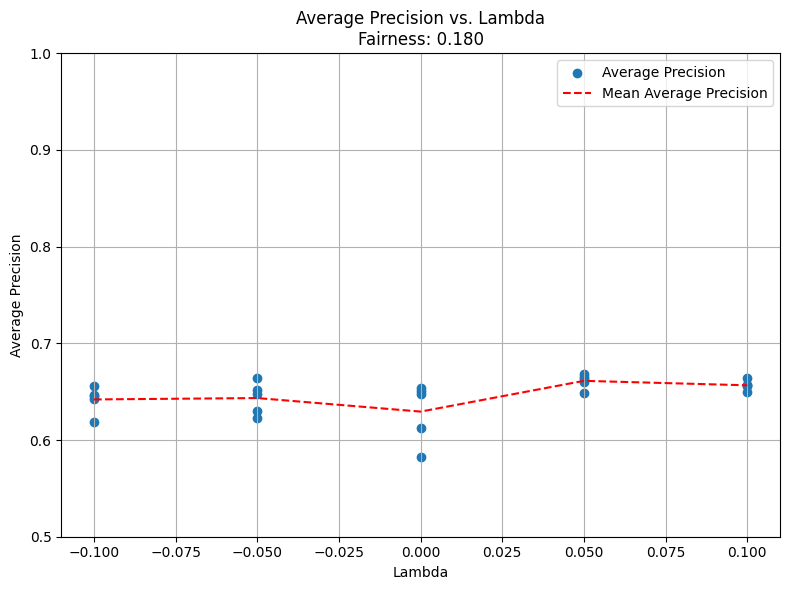

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
average_avg_precision = pred_data.groupby('Lambda')['Average Precision'].mean()
fairness_score = pred_data['Equalized Odds Ratio'].mean()

plt.scatter(pred_data['Lambda'], pred_data['Average Precision'], marker='o', label='Average Precision')
plt.plot(average_avg_precision.index, average_avg_precision.values, color='red', linestyle='--', label='Mean Average Precision')
plt.title(f'Average Precision vs. Lambda\nFairness: {fairness_score:.3f}')
plt.xlabel('Lambda')
plt.ylabel('Average Precision')
plt.ylim([0.5, 1])
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


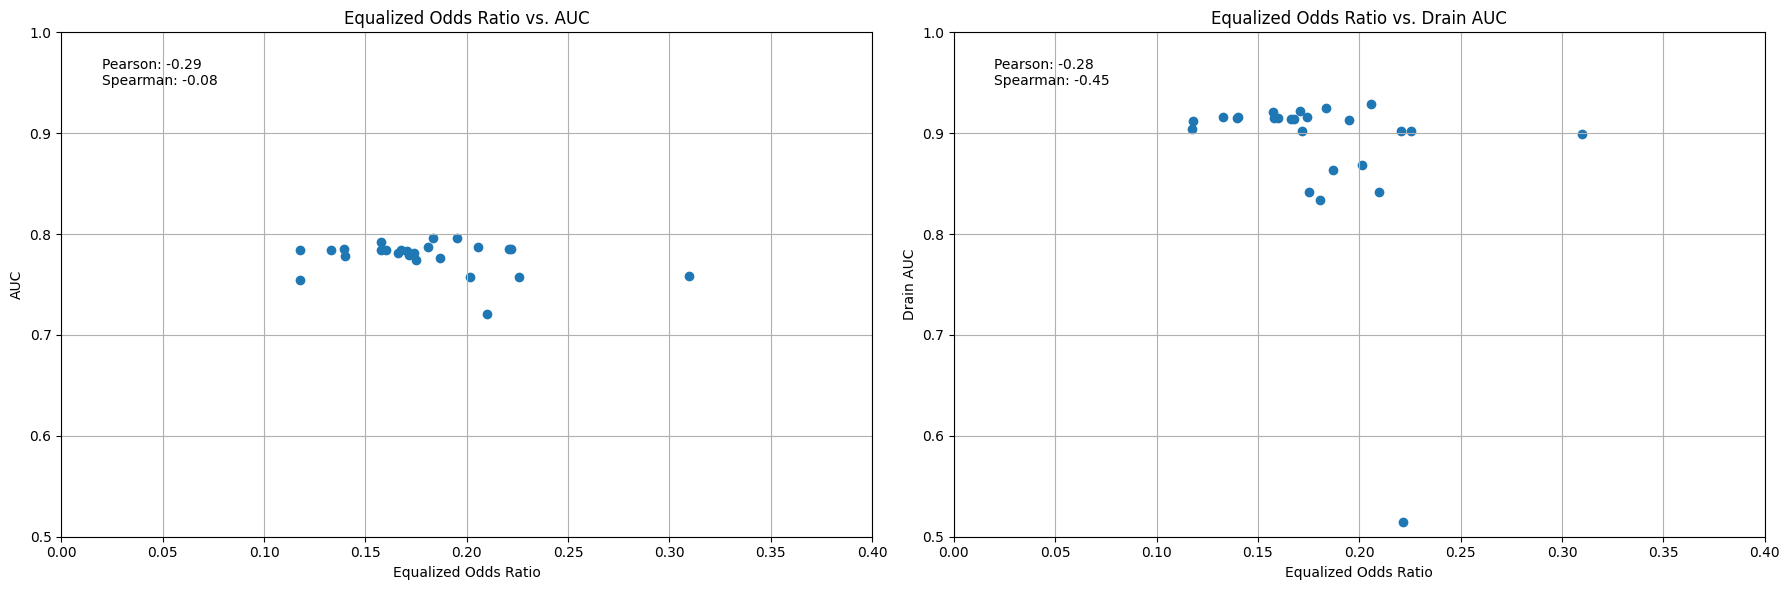

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

def annotate_correlations(x, y, ax):
    pearson_corr, _ = pearsonr(x, y)
    spearman_corr, _ = spearmanr(x, y)
    ax.text(0.05, 0.95, f'Pearson: {pearson_corr:.2f}\nSpearman: {spearman_corr:.2f}', 
            transform=ax.transAxes, ha='left', va='top', fontsize=10)

axes[0].scatter(pred_data['Equalized Odds Ratio'], pred_data['AUC'], marker='o')
axes[0].set_title('Equalized Odds Ratio vs. AUC')
axes[0].set_ylabel('AUC')
axes[0].set_xlabel('Equalized Odds Ratio')
axes[0].grid(True)
axes[0].set_xlim([0, 0.4])
axes[0].set_ylim([0.5, 1])
annotate_correlations(pred_data['AUC'], pred_data['Equalized Odds Ratio'], axes[0])

axes[1].scatter(pred_data['Equalized Odds Ratio'], pred_data['Drain AUC'], marker='o')
axes[1].set_title('Equalized Odds Ratio vs. Drain AUC')
axes[1].set_ylabel('Drain AUC')
axes[1].set_xlabel('Equalized Odds Ratio')
axes[1].grid(True)
axes[1].set_xlim([0, 0.4])
axes[1].set_ylim([0.5, 1])
annotate_correlations(pred_data['Drain AUC'], pred_data['Equalized Odds Ratio'], axes[1])

plt.tight_layout()
plt.show()

In [27]:
bb = pd.read_csv('../shortcuts-chest-xray/testing/Pred_Biased_Biased_Sex_2_0.csv')

In [30]:
y_true = bb['Pneumothorax'].map({1.: 1 , 0.: 0, -1.: 0}).fillna(0)
y_score = bb['y_score_Problem_in']

0       0.193835
1       0.077784
2       0.959992
3       0.252487
4       0.054590
          ...   
4213    0.077102
4214    0.297038
4215    0.020085
4216    0.415092
4217    0.022916
Name: y_score_Problem_in, Length: 4218, dtype: float64

In [31]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score, pos_label=1)
auc = metrics.auc(fpr, tpr)

auc

0.9013872358029589

In [39]:
sens_y_true = rr['Sex'].map({'Female': 1 , 'Male': 0, 'Unknown': 0}).fillna(0)
sens_y_score = rr['sensitive_y_score_Problem_in']
sens_y_pred = bb['sensitive_y_pred_Problem_in']

In [37]:
sens_y_true.value_counts()

1    2229
0    1989
Name: Sex, dtype: int64

In [40]:
sens_y_pred.value_counts()

1    2370
0    1848
Name: sensitive_y_pred_Problem_in, dtype: int64

In [43]:
count = sum(bb['Sex'].map({'Female': 1 , 'Male': 0, 'Unknown': 0}).fillna(0) == bb['sensitive_y_pred_Problem_in'])

In [45]:
count

4009/4218

0.9504504504504504

In [34]:
fpr, tpr, thresholds = metrics.roc_curve(sens_y_true, sens_y_score, pos_label=1)
auc = metrics.auc(fpr, tpr)

auc

0.9888101471507378

In [46]:
rr = pd.read_csv('../shortcuts-chest-xray/testing/Pred_Random_Random_Sex_2_0.csv')
y_true = rr['Pneumothorax'].map({1.: 1 , 0.: 0, -1.: 0}).fillna(0)
y_score = rr['y_score_Problem_in']
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score, pos_label=1)
auc = metrics.auc(fpr, tpr)

In [47]:
auc

0.7739734644385402

In [50]:
sens_y_true = rr['Sex'].map({'Female': 1 , 'Male': 0, 'Unknown': 0}).fillna(0)
sens_y_score = rr['sensitive_y_score_Problem_in']
sens_y_pred = rr['sensitive_y_pred_Problem_in']
print(len(sens_y_true))
count = sum(rr['Sex'].map({'Female': 1 , 'Male': 0, 'Unknown': 0}).fillna(0) == rr['sensitive_y_pred_Problem_in'])
count

3847


2695

In [51]:
fpr, tpr, thresholds = metrics.roc_curve(sens_y_true, sens_y_score, pos_label=1)
auc = metrics.auc(fpr, tpr)

auc

0.8659805842185555

In [54]:
from sklearn.metrics import average_precision_score
ap_score = average_precision_score(y_true, y_score)

In [55]:
ap_score

0.3573469790289639